In [4]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42

import bbi
import pybedtools as pbt
import pickle
import cooler
from copy import deepcopy
import itertools 

import sys
sys.path.append("./code")

from tad_functions import *
from treg_functions import *
from hic_zscore_functions import *
from plotting_functions import *
from aux_functions import *
from init_tss_annotations import *
gpath = './annotations/chromsizes'
import statsmodels.stats
import statsmodels.stats.multitest


import matplotlib.pyplot as plt

plt.rcParams['axes.axisbelow'] = True

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
ACOMPARTMENT_CUTOFF = .7
ACOMPARTMENT_CUTOFF_LOOSE = 0

In [7]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [8]:
import cooler
from importlib import reload
import sys
sys.path.append("./code")

import pandas as pd
from ast import literal_eval
import treg_functions

In [9]:
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import scipy, scipy.stats
from hic_zscore_functions import *
from treg_functions import *
from old_make_figures import *
from tad_functions import *


Make loop anchors

In [10]:
import process_loops_from_mustache
from process_loops_from_mustache import *
import glob


def load_mustache_loops_separate():
    dfs = {}
    init_dfs = {}
    
    keysoi = [
        'final_loop_call_for_paper_supplement_Merged_all', 'final_loop_call_for_paper_supplement_Treg_all', 
        'final_loop_call_for_paper_supplement_Treg_rep1_MAPQ30_raw_5000', 'final_loop_call_for_paper_supplement_Treg_rep2_MAPQ30_raw_5000', 
        'final_loop_call_for_paper_supplement_Treg_rep3_MAPQ30_raw_5000', 'final_loop_call_for_paper_supplement_Tconv_all', 
        'final_loop_call_for_paper_supplement_Tn_rep1_MAPQ30_raw_5000', 'final_loop_call_for_paper_supplement_Tn_rep2_MAPQ30_raw_5000', 
        'final_loop_call_for_paper_supplement_Tn_rep3_MAPQ30_raw_5000',
    ]
    for key in keysoi:
        if '_all' in key:
            file = f'./call_loops/output/{key}.mcool/5000__0.05__0.85__1.2/loops.tsv'
        else:
            file = f'./call_loops/output/{key}.cool/5000__0.05__0.85__1.2/loops.tsv'
        init_df = pd.read_csv(file, sep='\t')
        newloopset, anc_mapping, mustache_loop_df = filter_raw_mustache_loops(init_df.copy())
        name = file.split("/")[-3].split(".")[-2]
        
        dfs[name] = mustache_loop_df
        init_dfs[name] = init_df
    
    j = []
    for key in keysoi:
        j.append(dfs[key])
    full_loop_df = pd.concat(j, axis=0)
    print("Original # loops:", len(full_loop_df))
    newloops, anc_mapping, df = filter_raw_mustache_loops(full_loop_df)
    
    new_dfs = []
    for key in keysoi:
        bt = loops_from_df(dfs[key])
        loopset = remap_ancs(bt, anc_mapping)
        grange_list = loopset_to_granges(loopset)
        tmpdf = pd.DataFrame(index=grange_list)
        tmpdf[key] = True
        new_dfs.append(tmpdf)
        
    all_loops = pd.concat(new_dfs, axis=1)
    all_loops = all_loops.fillna(False)
    all_loops = all_loops.astype(int)
    print("Final # loops:", len(all_loops))

    return all_loops, init_dfs

all_loops_df, init_dfs = load_mustache_loops_separate()
all_loops = add_chr_to_bedtool(pbt.BedTool('final_loops/processed_DESEQ/thresh=0/all_loops.csv'))

Original # loops: 59175
Final # loops: 18438


In [11]:
from process_loops_from_mustache import *
v_merged = init_dfs['final_loop_call_for_paper_supplement_Merged_all']
v_treg = init_dfs['final_loop_call_for_paper_supplement_Treg_all']
v_tcon = init_dfs['final_loop_call_for_paper_supplement_Tconv_all']

v_merged = v_merged[v_merged['FDR'] < .02]
v_treg = v_treg[v_treg['FDR'] < .02]
v_tcon = v_tcon[v_tcon['FDR'] < .02]

treg_and_tcon, tcon_mapped_to_treg = add_loops_to_reference(v_treg, v_tcon, res=5000, d = 2)
merged_all_tcon, tcon_mapped_to_all = add_loops_to_reference(v_merged, tcon_mapped_to_treg, res=5000, d = 2)
merged_all_tcon_treg, treg_mapped_to_all = add_loops_to_reference(merged_all_tcon, v_treg, res=5000, d = 2)

In [12]:
import process_loops_from_mustache
from process_loops_from_mustache import *

import glob
dfs = {}
init_dfs = {}
for file in glob.glob('./call_loops/output/*/5000__0.05__0.85__1.2/*'):
    init_df = pd.read_csv(file, sep='\t')
    newloopset, anc_mapping, mustache_loop_df = filter_raw_mustache_loops(init_df.copy())
    name = file.split("/")[-3].split(".")[-2]
    dfs[name] = mustache_loop_df
    init_dfs[name] = init_df

In [13]:

all_color_dict = {
    'gray' : '#63666A',
    'lightblue' : 'lightblue'
}

In [14]:
treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
tcon_250kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/250000')


treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
tcon_50kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/50000')

treg_cool_5kb = cooler.Cooler('./Treg_all.mcool::/resolutions/5000')
tcon_cool_5kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/5000')
merged_cool_5kb = cooler.Cooler('./Merged_all.mcool::/resolutions/5000')


In [15]:
cooldict_5kb = {
    'treg' : treg_cool_5kb,
    'tcon' : tcon_cool_5kb,
    'merged' : merged_cool_5kb,
}

cooldict_250kb = {
    'treg' : treg_250kb,
    'tcon' : tcon_250kb,
}

replicate_cooldict = {
    'Treg rep1' : cooler.Cooler('./coolfiles/Treg_rep1_MAPQ30_raw_50000.cool'),
    'Treg rep2' : cooler.Cooler('./coolfiles/Treg_rep2_MAPQ30_raw_50000.cool'),
    'Treg rep3' : cooler.Cooler('./coolfiles/Treg_rep3_MAPQ30_raw_50000.cool'),
}

In [16]:
resting_gene_bedtool = pbt.BedTool('./peaks/Treg_rest_vs_Tcon_rest_thresh=0.25.csv.narrowPeak')
resting_gene_bedtool = resting_gene_bedtool.filter(lambda x: float(x[8]) > 4).saveas()

ATAC peaks

In [17]:
atac_peaks = pbt.BedTool('./atac/processed/Treg_rest_vs_Tcon_rest_thresh=0.csv')

Load TF annotations

In [18]:
tfs = pd.read_csv('/Genomics/argo/users/gdolsten/pritlab/jupys/tregs/rudensky_scrna/prelim-analysis/tfdb/Mus_musculus_TF', sep='\t')
tfnames = tfs['Symbol']

Load Compartments

In [19]:
my_treg_comp = np.load('for_s1/my_treg_comp.npy')
my_tcon_comp = np.load('for_s1/my_tcon_comp.npy')

my_treg_comp_50kb = np.load('for_s1/my_treg_comp_50kb.npy')
my_tcon_comp_50kb = np.load('for_s1/my_tcon_comp_50kb.npy')

Load self object

In [20]:
from make_figure4 import *
import pickle


row_colors = ['lightgreen', 'green', 'orange']

columns_to_names = {
    0 : 'Constitutive',
    4 : 'Dynamic',
    18 : 'Repressive',
}

row_colors_dict = {
'Constitutive' : 'lightgreen',
'Dynamic' : 'green',
'Repressive' : 'orange',
}

self = pickle.load(open('./for_s1/self_object', 'rb'))

In [21]:
from initialize import *

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)


(_, _, region_to_inds_50kb, all_region_to_ind_50kb, 
    inds_to_region_50kb, all_ind_to_region_50kb,
    chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(treg_50kb)

Make TSS DF

In [42]:
def make_250kb_annotations():
    n = np.arange(len(my_treg_comp))
    
    _250kb_hub_annotations = pd.DataFrame(index = n)
    _250kb_hub_annotations['Hub'] = "Others"
    
    active_hub_a_comp = np.nanmean(my_treg_comp[self.goodinds[(self.clustdict['all'] == 0) | (self.clustdict['all'] == 4)]])
    n = n[~np.isin(n, self.goodinds[(self.merged_clustdict['all'] == 0) | (self.merged_clustdict['all'] == 4)])]
    o = np.argsort(-my_treg_comp[n])
    vals = my_treg_comp[n][o]
    for i in np.arange(len(vals)):
        if np.nanmean(vals[:i]) < active_hub_a_comp:
            break
    print(i)
    _250kb_hub_annotations['Hub'].loc[n[o][:i]] = 'matched_A compartment'
    
    for u in [0, 4, 18]:
        _250kb_hub_annotations.loc[self.goodinds[self.merged_clustdict['all']==u], 'Hub'] = columns_to_names[u]
    return _250kb_hub_annotations
    
_250kb_hub_annotations =  make_250kb_annotations()
_250kb_hub_annotations.to_csv('./annotations/_250kb_hub_annotations.tsv', sep='\t')

1776


/tmp/ipykernel_3274312/186958453.py:12: RuntimeWarning: Mean of empty slice
  if np.nanmean(vals[:i]) < active_hub_a_comp:


In [44]:
from gtf_functions import make_tss_df

gtf_file = pbt.BedTool('./rudensky_scrna/prelim-analysis/bulk_rna_data/annotations/gencode.vM23.annotation.gtf')
transcripts_file = gtf_file.filter(lambda b: b[2] == 'transcript').saveas()
exons = gtf_file.filter(lambda b: b[2] == 'exon').saveas()
my_tss_df, my_transcript_df = make_tss_df(transcripts_file, {'chr' + x for x in PARSED_CHROMS_nochr})

my_tss_df = my_tss_df.loc[~(my_tss_df['support_level'] == 'NA') & (my_tss_df['transcript_type'] == 'protein_coding')]
my_tss_df['support_level'] = my_tss_df['support_level'].astype(int)
my_tss_df = my_tss_df.sort_values("support_level").drop_duplicates("gene_name")


my_tss_df = my_tss_df[my_tss_df['chrom'].isin(add_chr_to_list(parsed_chroms))]
my_tss_df['ind'] = my_tss_df['start']//250_000 + my_tss_df['chrom'].apply(lambda x: chrom_to_start[x[3:]])
my_tss_df['cluster'] = -1
my_tss_df['cluster'] = my_tss_df['cluster'].astype(object)
my_tss_df['hub'] = "none"
for u in _250kb_hub_annotations['Hub'].unique():
    inds = _250kb_hub_annotations.index[_250kb_hub_annotations['Hub'] == u]
    my_tss_df.loc[my_tss_df['ind'].isin(inds), 'hub'] = u

my_tss_df['hub'] = my_tss_df['hub'].astype(object)

for u in np.unique(self.clustdict['all']):
    inds_in_cluster = self.goodinds[self.clustdict['all']==u]
    my_tss_df.loc[my_tss_df['ind'].isin(inds_in_cluster), 'cluster'] = u

my_tss_df.to_csv('./annotations/full_tss_df.csv', sep=',')
my_tss_df = my_tss_df[my_tss_df['gene_name'].isin(gene_dict['Resting'].index)]

# my_tss_df.to_csv('./annotations/my_tss_df.csv', sep=',')

In [24]:
my_tss_df = pd.read_csv('./annotations/my_tss_df.csv', index_col = 0)

Load Gene Expression

In [25]:
import pandas as pd
geneLengths = pd.read_csv('/Genomics/argo/users/gdolsten/pritlab/jupys/tregs/rudensky_scrna/prelim-analysis/bulk_rna_data/counts/SRP272473.SRR12264706.activated_Treg.rep3_counts.txt',
           sep='\t', skiprows=1,).set_index("Geneid")
geneLengths = geneLengths['Length']


active_gene_lfcs = pbt.BedTool('./peaks/Treg_actv_vs_Tcon_actv_thresh=0.25.csv.narrowPeak').to_dataframe().set_index('name')
resting_gene_lfcs = pbt.BedTool('./peaks/Treg_rest_vs_Tcon_rest_thresh=0.25.csv.narrowPeak').to_dataframe().set_index('name')

active_gene_lfcs = active_gene_lfcs[active_gene_lfcs['itemRgb'] > 4]
resting_gene_lfcs = resting_gene_lfcs[resting_gene_lfcs['itemRgb'] > 4]

active_gene_lfcs = active_gene_lfcs[active_gene_lfcs.index.isin(my_tss_df['gene_name']) & 
                                    active_gene_lfcs.index.isin(geneLengths.index)]
resting_gene_lfcs = resting_gene_lfcs[resting_gene_lfcs.index.isin(my_tss_df['gene_name']) & 
                                    resting_gene_lfcs.index.isin(geneLengths.index)]

active_gene_lfcs = active_gene_lfcs[~active_gene_lfcs.index.duplicated()]
resting_gene_lfcs = resting_gene_lfcs[~resting_gene_lfcs.index.duplicated()]

active_gene_lfcs['rpkm'] = active_gene_lfcs['itemRgb'] / geneLengths.loc[active_gene_lfcs.index]
resting_gene_lfcs['rpkm'] = resting_gene_lfcs['itemRgb'] / geneLengths.loc[resting_gene_lfcs.index]

gene_dict = {
    'Active' : active_gene_lfcs,
    'Resting' : resting_gene_lfcs,
}

In [26]:
gene_dict['Resting'].to_csv('./annotations/resting_gene_dict.csv', sep='\t')

In [27]:
import initialize
from initialize import *

gene_to_ind, ind_to_gene = initialize_genes(all_ind_to_region, all_region_to_ind)

for x, y in ind_to_gene.items():
    ind_to_gene[x] = [_ for _ in y if _ in gene_dict['Resting'].index]

Load SEs

In [29]:
SEs = pbt.BedTool('superenhancers/common_SE_liftover.bed')
SE_treg = pbt.BedTool('superenhancers/Treg_SE_liftover.bed')
SE_tn = pbt.BedTool('superenhancers/Tn_SE_liftover.bed')
SEs_all = SEs.cat(SE_treg).cat(SE_tn)
SE_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SEs_all, c=True), -1).astype(int)

SE_treg_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SE_treg, c=True), -1).astype(int)
SE_tcon_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SE_tn, c=True), -1).astype(int)
SE_common_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SEs, c=True), -1).astype(int)

In [30]:
bw_val_df_all_50kb = pd.read_csv('./for_s1/bw_vals_50kb.csv')
bw_val_df_all_250kb = pd.read_csv('./for_s1/bw_vals_250kb.csv')

In [31]:
deseq_effect_mat = np.load('./for_s1/deseq_effect_mat.npy')
deseq_lfc_mat = np.load('./for_s1/deseq_lfc_mat.npy')
deseq_pval_mat = np.load('./for_s1/deseq_pval_mat.npy')

Load loops

In [131]:
loopdict = {
    'NS' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/ns_loops.csv'),
    'Tcon' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Tcon_loops.csv'),
    'Treg' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Treg_loops.csv'),
}

anchordict = {
    'All' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/all_ancs.csv'),
    'NS' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/ns_ancs.csv'),
    'Tcon' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Tcon_ancs.csv'),
    'Treg' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Treg_ancs.csv'),
}

anchordict_thresh_025 = {
    'All' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/all_ancs.csv'),
    'NS' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/ns_ancs.csv'),
    'Tcon' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/Tcon_ancs.csv'),
    'Treg' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/Treg_ancs.csv'),
}

loop_colordict = {
    'NS' : 'lightgray',
    'Tcon' : 'blue',
    'Treg' : 'red',
}

Load TADs

In [309]:
insu_pref = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/insulations/'
res = 5000
d = 16
insu_df_treg = pd.read_csv(insu_pref + f'Rename_Treg_all_no_chrM_res={res}_pixels={d}.bw', sep='\t')
insu_df_tcon = pd.read_csv(insu_pref + f'Rename_Tconv_all_no_chrM_res={res}_pixels={d}.bw', sep='\t')

insu_df_tcon['is_boundary_strict'] = insu_df_tcon[f'boundary_strength_{d*res}'] > .4
insu_df_treg['is_boundary_strict'] = insu_df_treg[f'boundary_strength_{d*res}'] > .4

inds_tcon = insu_df_tcon[insu_df_tcon['is_boundary_strict'] | insu_df_treg['is_boundary_strict']]
inds_treg = insu_df_treg[insu_df_tcon['is_boundary_strict'] | insu_df_treg['is_boundary_strict']]


all_boundary_info = pd.concat([inds_tcon[['chrom', 'start', 'end']],
           inds_tcon[['boundary_strength_80000', 'log2_insulation_score_80000', 'is_boundary_strict']].add_prefix("tcon_"),
           inds_treg[['boundary_strength_80000', 'log2_insulation_score_80000', 'is_boundary_strict']].add_prefix("treg_")
           ], axis=1)

all_boundary_info['tcon_boundary_strength_80000'] = all_boundary_info['tcon_boundary_strength_80000'].fillna(-100)
all_boundary_info['tcon_log2_insulation_score_80000'] = all_boundary_info['tcon_log2_insulation_score_80000'].fillna(100)
all_boundary_info['tcon_is_boundary_strict'] = all_boundary_info['tcon_is_boundary_strict'].fillna(-100)
all_boundary_info['treg_boundary_strength_80000'] = all_boundary_info['treg_boundary_strength_80000'].fillna(-100)
all_boundary_info['treg_log2_insulation_score_80000'] = all_boundary_info['treg_log2_insulation_score_80000'].fillna(100)

all_boundary_info['treg_is_boundary_strict'] = all_boundary_info['treg_is_boundary_strict'].astype(int)
all_boundary_info['tcon_is_boundary_strict'] = all_boundary_info['tcon_is_boundary_strict'].astype(int)

tad_boundaries = add_chr_to_bedtool(pbt.BedTool.from_dataframe(all_boundary_info).slop(b=10_000, genome='mm10')).merge(
    c=[4,5,6,7,8,9],
    o=['max', 'min', 'max', 'max', 'min', 'max']
)

tad_boundaries = tad_boundaries.to_dataframe()
tad_boundaries[tad_boundaries==100] = np.nan
tad_boundaries[tad_boundaries==-100] = np.nan

tad_boundary_df = tad_boundaries.copy()
tad_boundary_df.columns = all_boundary_info.columns

tad_boundaries = pbt.BedTool.from_dataframe(tad_boundaries)

Load Metadomains

In [219]:
all_intra_treg_metadomains = np.load('intermediate_files/all_intra_treg_metadomains.npy')
all_intra_tcon_metadomains = np.load('intermediate_files/all_intra_tcon_metadomains.npy')
all_inter_treg_metadomains = np.load('./intermediate_files/all_inter_treg_metadomains.npy')
all_inter_tcon_metadomains = np.load('./intermediate_files/all_inter_tcon_metadomains.npy')

all_intra_metadomains = (all_intra_treg_metadomains + all_intra_tcon_metadomains > 0)
all_inter_metadomains = (all_inter_treg_metadomains + all_inter_tcon_metadomains > 0)

inter_and_intra_metadomains_tcon = all_intra_tcon_metadomains + all_inter_tcon_metadomains
inter_and_intra_metadomains_treg = all_intra_treg_metadomains + all_inter_treg_metadomains

Load Log O/E matrices

In [48]:
from construct_oe_mat import construct_oe_mat_dict
treg_tcon_oe_mat = construct_oe_mat_dict(cooldict_250kb, all_ind_to_region, parsed_chroms, 
                      chrom_to_start, chrom_to_end, verbose=True, pc=1e-4, log=True)

sep_oe_mat_treg = treg_tcon_oe_mat['treg']
sep_oe_mat_tcon = treg_tcon_oe_mat['tcon']

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with treg
Done with tcon


Load differential hub DFs

In [67]:
newline = '\n'

# hub_pileup_stat_df_250kb = pd.read_csv('./diff_ms_dfs/stat_df.csv', index_col = 0)
# hub_pileup_pval_df_250kb = pd.read_csv('./diff_ms_dfs/pval_df.csv', index_col = 0)

# hub_pileup_stat_df_250kb.columns = hub_pileup_stat_df_250kb.columns.astype(int)
# hub_pileup_pval_df_250kb.columns = hub_pileup_pval_df_250kb.columns.astype(int)


hub_pileup_stat_df_250kb = pd.read_csv('./diff_ms_dfs/stat_df_NEW.csv', index_col = 0)
hub_pileup_pval_df_250kb = pd.read_csv('./diff_ms_dfs/pval_df_NEW.csv', index_col = 0)

hub_pileup_stat_df_250kb.columns = hub_pileup_stat_df_250kb.columns.astype(int)
hub_pileup_pval_df_250kb.columns = hub_pileup_pval_df_250kb.columns.astype(int)

HIC_PCO = .01
HIC_STATCO = 1.5

In [50]:
def make_metadomain_hub_freq_df():
    metadomain_mat_dict = {
            'Treg' : (inter_and_intra_metadomains_tcon == 0) & (inter_and_intra_metadomains_treg > 0),
            'Both' : (inter_and_intra_metadomains_tcon > 0) & (inter_and_intra_metadomains_treg > 0),
            'Tcon' : (inter_and_intra_metadomains_tcon > 0) & (inter_and_intra_metadomains_treg == 0),
            'Neither' : (inter_and_intra_metadomains_tcon == 0) & (inter_and_intra_metadomains_treg == 0),
    
    }
    
    metadomain_hub_freq_df = pd.DataFrame()
    for key, metadomain_mat in metadomain_mat_dict.items():
        data = []
        us = [0, 4, 18]
        for u in us:
            inds = self.goodinds[self.merged_clustdict['all']==u]
            data.append(np.sum(metadomain_mat[inds, :][:, inds]))
        series_data = pd.Series(data, index=us)
        metadomain_hub_freq_df[key] = series_data
    metadomain_hub_freq_df.index = [columns_to_names.get(x, "Other") for x in metadomain_hub_freq_df.index]
    metadomain_hub_freq_df = (metadomain_hub_freq_df.T / metadomain_hub_freq_df.sum(axis=1)).T
    metadomain_hub_freq_df = metadomain_hub_freq_df.drop("Neither", axis=1)    
    return metadomain_hub_freq_df

In [51]:
metadomain_hub_freq_df = make_metadomain_hub_freq_df()

Load Motifs

In [465]:
%autoreload 2
from config import get_motif_counts
from motif_metadata_functions import get_motif_metadata

meme_motif_df, motif_id_to_name_dict = get_motif_counts(bedtool_to_index(add_chr_to_bedtool(atac_peaks)))
motif_metadata = get_motif_metadata(motif_id_to_name_dict)

2
2 2303 93417 91114


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/pyjaspar/__init__.py:338: BiopythonWarning: Failed to fetch internal database ID for JASPAR motif with matrix ID 'MA1621.1'. No JASPAR motif with this matrix ID appears to exist.
  warnings.warn(


Load H3K27ac

In [519]:
from config import get_h3k27ac_motif_counts

h3k27ac_motif_df, _ = get_h3k27ac_motif_counts()

In [46]:
# all_h3k27ac = add_chr_to_bedtool(pbt.BedTool('peaks/differential/all_threshold_27ac.csv')).to_dataframe()
# all_h3k27ac.index = bedtool_to_index(add_chr_to_bedtool(pbt.BedTool('peaks/differential/all_threshold_27ac.csv')))
# all_h3k27ac['score'] = -all_h3k27ac['score']
# all_h3k27ac = all_h3k27ac[(all_h3k27ac['name'] < 400) | (all_h3k27ac['name'] > 10)]
# all_h3k27ac.to_csv('./annotations/final_h3k27ac.csv'

Load scRNA correlations

In [58]:
from supp_figures_plotting_functions import load_rna
treg_precursor_rna_corr, tregs_rna_corr = load_rna()

Load metaloop anchors dataframe

In [59]:
metaloop_anchors = add_chr_to_bedtool(pbt.BedTool('./final_loops/metaloops/refined_metaloop_anchors.bed'))

In [262]:
metaloops = pbt.BedTool('./final_loops/metaloops/refined_metaloops/refined_metaloops.bed')

Load ChIP Compendium

In [552]:
adata = sc.read_h5ad('./final_chipseq_adata/FINAL_adata_updated')

#### Table S1

In [577]:
from supp_figures_plotting_functions import make_table_s1

!mkdir -p plots/paper/tables
table_s1 = make_table_s1()

FileNotFoundError: [Errno 2] No such file or directory: './plots/paper/tables/table_s4_hic.tsv'

#### Table S2

In [ ]:
from supp_figures_plotting_functions import make_table_s2

tables_s2 = make_table_s2(all_loops, tad_boundary_df)

#### Table S3

Deseq2

In [ ]:
all_data = []
rows, cols = np.where(np.triu(deseq_pval_mat < .05))
for row, col in zip(rows, cols):
    data = (list(all_ind_to_region[row]) + list(all_ind_to_region[col])
            + [inter_and_intra_metadomains_treg[row, col] > 0]
            + [inter_and_intra_metadomains_tcon[row, col] > 0]
            + [deseq_effect_mat[row, col]]
            + [deseq_pval_mat[row, col]]
            + [deseq_lfc_mat[row, col]]
            + ['; '.join(ind_to_gene.get(row, []))]
            + ['; '.join(ind_to_gene.get(col, []))]
           )
    all_data.append(data)

In [ ]:
intra_deseq_values = pd.DataFrame(all_data,
                          columns = ['chrom1', 's1', 'e1',
                                    'chrom2', 's2', 'e2',
                                    'treg_metadomain',
                                     'tcon_metadomain',
                                    'Wald Statistic',
                                     'FDR',
                                     'DESeq2_LFC Treg / Tcon',
                                     'genes_anchor_1',
                                     'genes_anchor_2'])
intra_deseq_values['is_interchromosomal'] = intra_deseq_values['chrom1'] != intra_deseq_values['chrom2']
intra_deseq_values.to_excel('./plots/paper/tables/table_s3_differential_interactions.xlsx', index=False)

#### Table S4

Metadomains

In [ ]:
all_data = []
rows, cols = np.where(np.triu(all_intra_metadomains + all_inter_metadomains > 0))
for row, col in zip(rows, cols):
    data = (list(all_ind_to_region[row]) + list(all_ind_to_region[col])
            + [inter_and_intra_metadomains_treg[row, col] > 0]
            + [inter_and_intra_metadomains_tcon[row, col] > 0]
            + [deseq_effect_mat[row, col]]
            + [deseq_pval_mat[row, col]]
            + [deseq_lfc_mat[row, col]]
            + ['; '.join(ind_to_gene.get(row, []))]
            + ['; '.join(ind_to_gene.get(col, []))]
           )
    all_data.append(data)

In [ ]:
metadomains = pd.DataFrame(all_data,
                          columns = ['anchor1_chr', 'anchor1_start', 'anchor1_end', 
                                     'anchor2_chr', 'anchor2_start', 'anchor2_end',
                                    'is_treg_metadomain',
                                     'is_tcon_metadomain',
                                     'DESeq2_Wald_Statistic',
                                     'DESeq2_FDR',
                                     'DESeq2_LFC Treg / Tcon',
                                     'genes_in_anchor_1',
                                     'genes_in_anchor_2'])
metadomains['is_intrachromosomal_metadomain'] = metadomains['chrom1'] == metadomains['chrom2']
metadomains['is_interchromosomal_metadomain'] = metadomains['chrom1'] != metadomains['chrom2']
metadomains.to_csv('./plots/paper/tables/table_s4_metadomains.tsv', sep='\t', index = None)

#### Table S4 (Metadomain clustering)

In [ ]:
genomic_regions = pd.DataFrame([all_ind_to_region[x] for x in _250kb_hub_annotations['Hub'].index],
                              columns = ['chr', 'metadomain_start', 'metadomain_end'])
annotations = _250kb_hub_annotations
chip = pd.DataFrame(bw_val_df_all_250kb[['Treg CTCF', 'Treg ATAC',
                     'Treg H3K27ac',  'Treg H3K27me3', 'Treg H3K4me1', 'Treg H3K4me3',
                           ]])
SEs = pd.concat([pd.Series(SE_treg_count), pd.Series(SE_tcon_count), pd.Series(SE_common_count)], axis=1,
               )
SEs.columns = ['SE_Treg', 'SE_Tcon', 'SE_common']

metadomain_clustering = pd.concat([genomic_regions, annotations, chip, SEs], axis=1)
metadomain_clustering.to_excel('./plots/paper/tables/table_s5_metadomains.xlsx', index=False)

#### Table S5 (Metaloops)

In [578]:
supp_metaloop_dataframe = metaloops.to_dataframe()
supp_metaloop_dataframe = pd.concat([
metaloop_dataframe['chrom'],
metaloop_dataframe['start'],
metaloop_dataframe['start'] + 5_000,
metaloop_dataframe['chrom'],
metaloop_dataframe['end'],
metaloop_dataframe['end'] + 5_000,
metaloop_dataframe['score'],
metaloop_dataframe['strand'],
metaloop_dataframe['thickEnd'],
metaloop_dataframe['itemRgb'],
    ], axis=1)

supp_metaloop_dataframe.columns = ['chrom_anc1' ,'metaloop_anc1_start',
                                  'metaloop_anc1_end',
                                  'chrom_anc2',
                                  'metaloop_anc2_start',
                                  'metaloop_anc2_end',
                                  'original_metadomain_anc1_start',
                                  'original_metadomain_anc1_end',
                                   'original_metadomain_anc2_start',
                                   'original_metadomain_anc2_end'
                                  ]
supp_metaloop_dataframe.to_excel('./plots/paper/tables/table_s6_metaloop_dataframe.xlsx', index=False)

#### Figure S1

A. Reads in Dataset

In [113]:
!mkdir -p ./plots/paper/s1

Imported plotting functions


Imported plotting functions


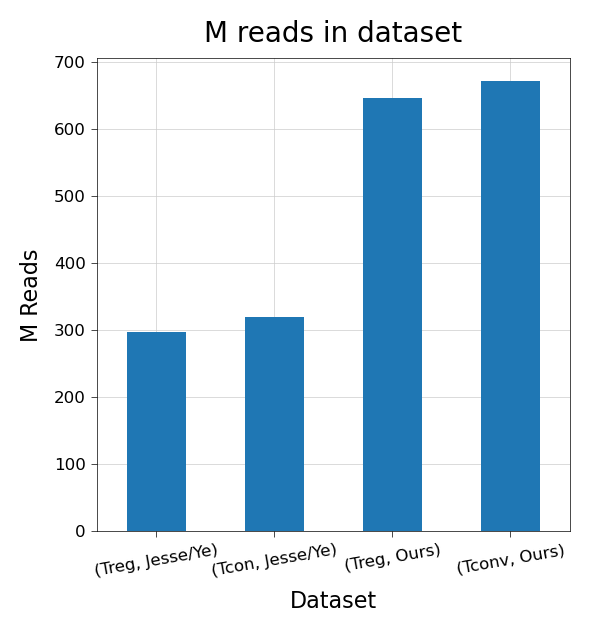

In [119]:
from supp_figures_plotting_functions import make_hic_jesseye_readcount_barplot

fig = make_hic_jesseye_readcount_barplot()
fig.savefig('./plots/paper/s1/loop_manhattan.pdf', bbox_inches='tight')

B. Reproducibility

In [1740]:
coolfiles = {
    'Treg_rep1' : cooler.Cooler('./coolfiles/Treg_rep1_MAPQ30_raw_100000.cool'),
    'Treg_rep2' : cooler.Cooler('./coolfiles/Treg_rep2_MAPQ30_raw_100000.cool'),
    'Treg_rep3' : cooler.Cooler('./coolfiles/Treg_rep3_MAPQ30_raw_100000.cool'),
    'Tn_rep1' : cooler.Cooler('./coolfiles/Tn_rep1_MAPQ30_raw_100000.cool'),
    'Tn_rep2' : cooler.Cooler('./coolfiles/Tn_rep2_MAPQ30_raw_100000.cool'),
    'Tn_rep3' : cooler.Cooler('./coolfiles/Tn_rep3_MAPQ30_raw_100000.cool'),
}

AUTOSOMES = cooler.Cooler('./coolfiles/Treg_rep1_MAPQ30_raw_100000.cool').chromnames[:-3]

from aux_functions import *
from make_figure4 import normalize_raw_intra
data_dfs = []
for chrom in AUTOSOMES:
    data_df = pd.DataFrame()
    for name,  cool in coolfiles.items():
        data = []
        mat = cool.matrix().fetch(chrom)
        m = normalize_raw_intra(mat, nan_to_zero=False, pc = 1e-4)
        x, y = np.triu_indices(m.shape[0])
        dist = np.abs(x-y)
        x, y = x, y
        data_df[name] = m[x, y]
    
    data_df['chrom'] = chrom
    data_df['distance'] = dist
    data_df = data_df.dropna()
    data_df.columns = data_df.columns.str.replace("Tn", "Tcon")
    data_dfs.append(data_df)

data_df_merged = pd.concat(data_dfs, axis=0)
data_df_merged.columns = data_df_merged.columns.str.replace("Tn", "Tcon")

all_rs = []
for u in data_df_merged['distance'].unique():
    rs = data_df_merged[data_df_merged['distance']==u].drop('distance', axis=1).groupby('chrom').corr().reset_index().melt(['chrom', 'level_1'])
    rs['distance'] = u
    all_rs.append(rs)

all_rs = pd.concat(all_rs, axis=0)
all_rs = all_rs[all_rs['level_1']!=all_rs['variable']]
all_rs['cond1'] = all_rs['level_1'].apply(lambda x: x.split("_rep")[0])
all_rs['cond2'] = all_rs['variable'].apply(lambda x: x.split("_rep")[0])
all_rs['final_cond'] = 'Treg-Tcon'
all_rs.loc[(all_rs['cond1'] == 'Treg') & (all_rs['cond2'] == 'Treg'), 'final_cond'] = 'Treg-Treg'
all_rs.loc[(all_rs['cond1'] == 'Tcon') & (all_rs['cond2'] == 'Tcon'), 'final_cond'] = 'Tcon-Tcon'
all_rs['kb'] = (all_rs['distance'] * 100_000)/1e3
all_rs['mb'] = (all_rs['distance'] * 100_000)/1e6
all_rs = all_rs.reset_index()

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/

In [1749]:
rs2 = all_rs.groupby(['chrom', 'level_1', 'variable', 'mb'])['value'].mean().reset_index()

In [1752]:
all_rs['final_cond2'] = all_rs['level_1'] + '-' + all_rs['variable']

In [1759]:
all_rs = all_rs[all_rs['level_1'] > all_rs['variable']]

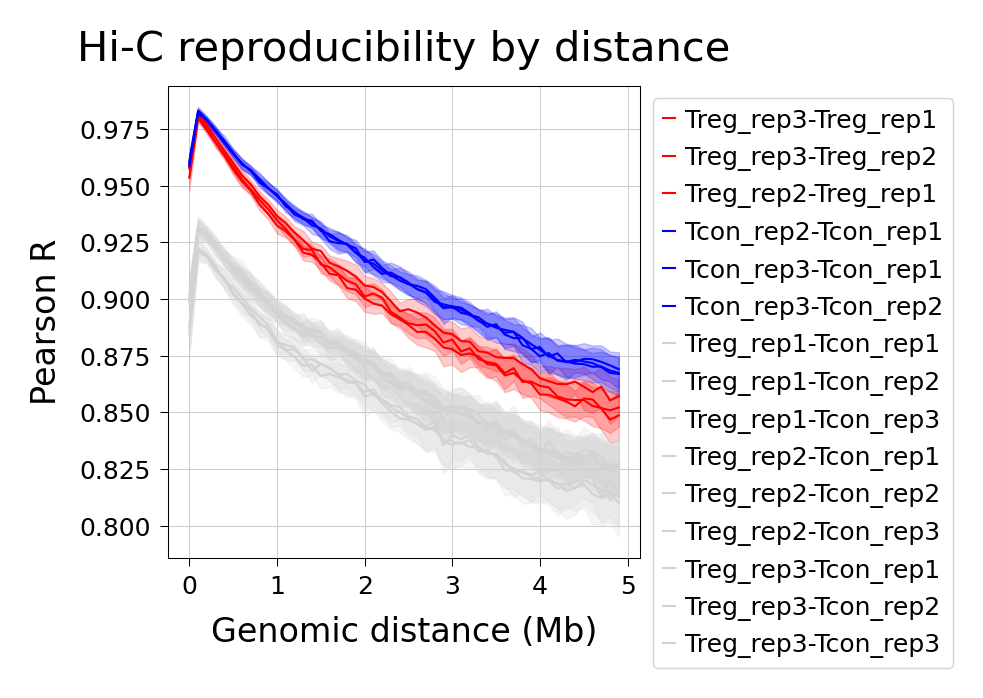

In [1765]:
fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 40*mm), dpi = 150)
sns.lineplot(data=all_rs[all_rs['distance'] < 50], x = 'mb', y = 'value', hue='final_cond2', ax=axs,
            palette=['red', 'red', 'red', 'blue', 'blue', 'blue', 'lightgray', 'lightgray', 'lightgray', 
                     'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray'],
            hue_order=[ 'Treg_rep3-Treg_rep1', 'Treg_rep3-Treg_rep2', 'Treg_rep2-Treg_rep1', 'Tcon_rep2-Tcon_rep1', 
                       'Tcon_rep3-Tcon_rep1', 'Tcon_rep3-Tcon_rep2', 'Treg_rep1-Tcon_rep1', 'Treg_rep1-Tcon_rep2', 
                       'Treg_rep1-Tcon_rep3', 'Treg_rep2-Tcon_rep1', 'Treg_rep2-Tcon_rep2', 'Treg_rep2-Tcon_rep3', 
                       'Treg_rep3-Tcon_rep1', 'Treg_rep3-Tcon_rep2', 'Treg_rep3-Tcon_rep3',]
            )
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Genomic distance (Mb)')
plt.ylabel('Pearson R')
plt.title("Hi-C reproducibility by distance")
fig.savefig('./plots/paper/s1/reproducibility_by_distance.pdf', bbox_inches='tight')

#### Figure S2

A. Looping venn diagram

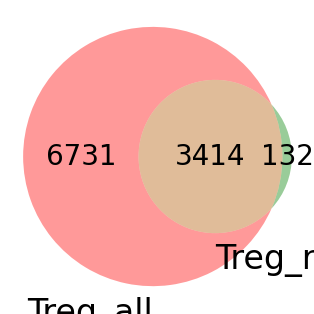

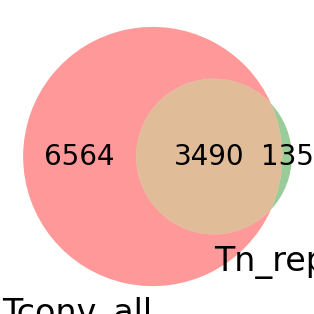

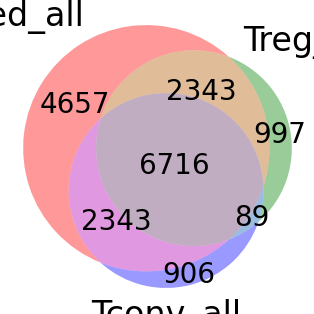

In [338]:
from supp_figures_plotting_functions import make_venn_diagrams

fig_treg, fig_tcon, fig_merged = make_venn_diagrams(all_loops_df)
# fig_treg.savefig("./plots/paper/s2/loop_venn_treg.pdf", bbox_inches='tight')
# fig_tcon.savefig("./plots/paper/s2/loop_venn_tcon.pdf", bbox_inches='tight')
# fig_merged.savefig("./plots/paper/s2/loop_venn_merged.pdf", bbox_inches='tight')

B. Jaccard looping

Imported plotting functions


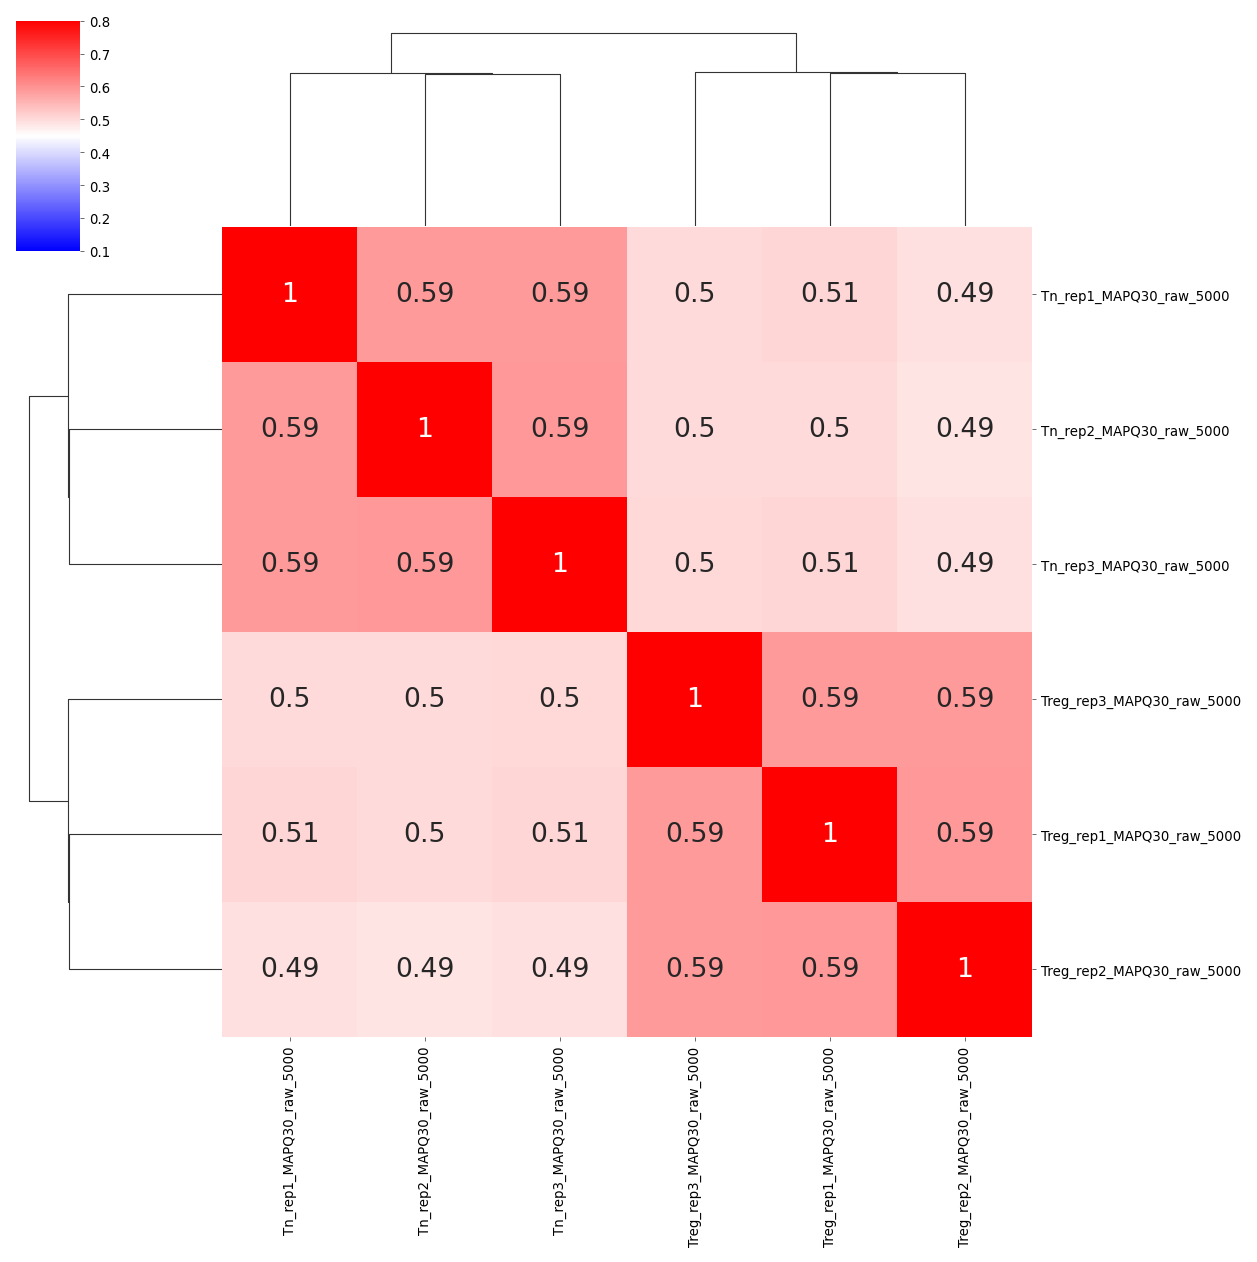

In [123]:
%autoreload 2
from supp_figures_plotting_functions import make_jaccard_clustermap

fig_jacc = make_jaccard_clustermap(all_loops_df)
fig_jacc.savefig("./plots/paper/s2/loop_jacc.pdf", bbox_inches='tight')

C. Mustache FDRs

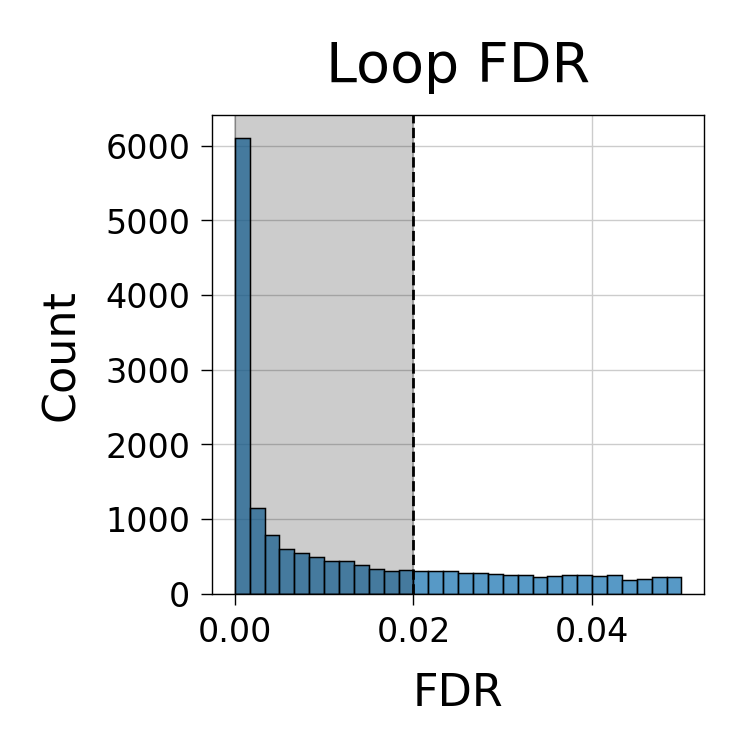

In [131]:
from supp_figures_plotting_functions import make_fdr_histogram

fig = make_fdr_histogram(init_dfs)
fig.savefig("./plots/paper/s2/loop_fdrs.pdf", bbox_inches='tight')

D1. Random examples

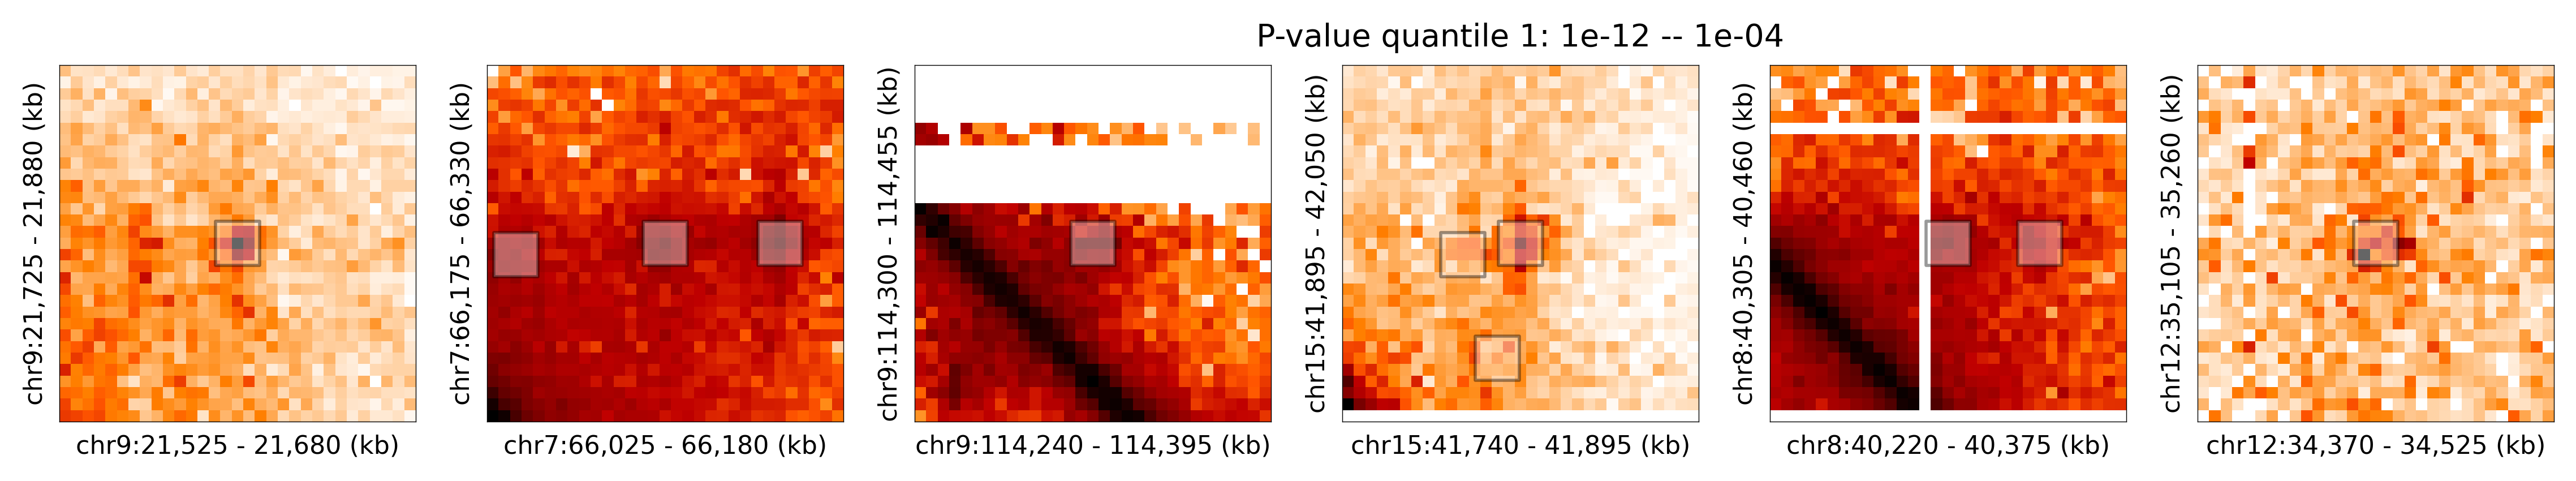

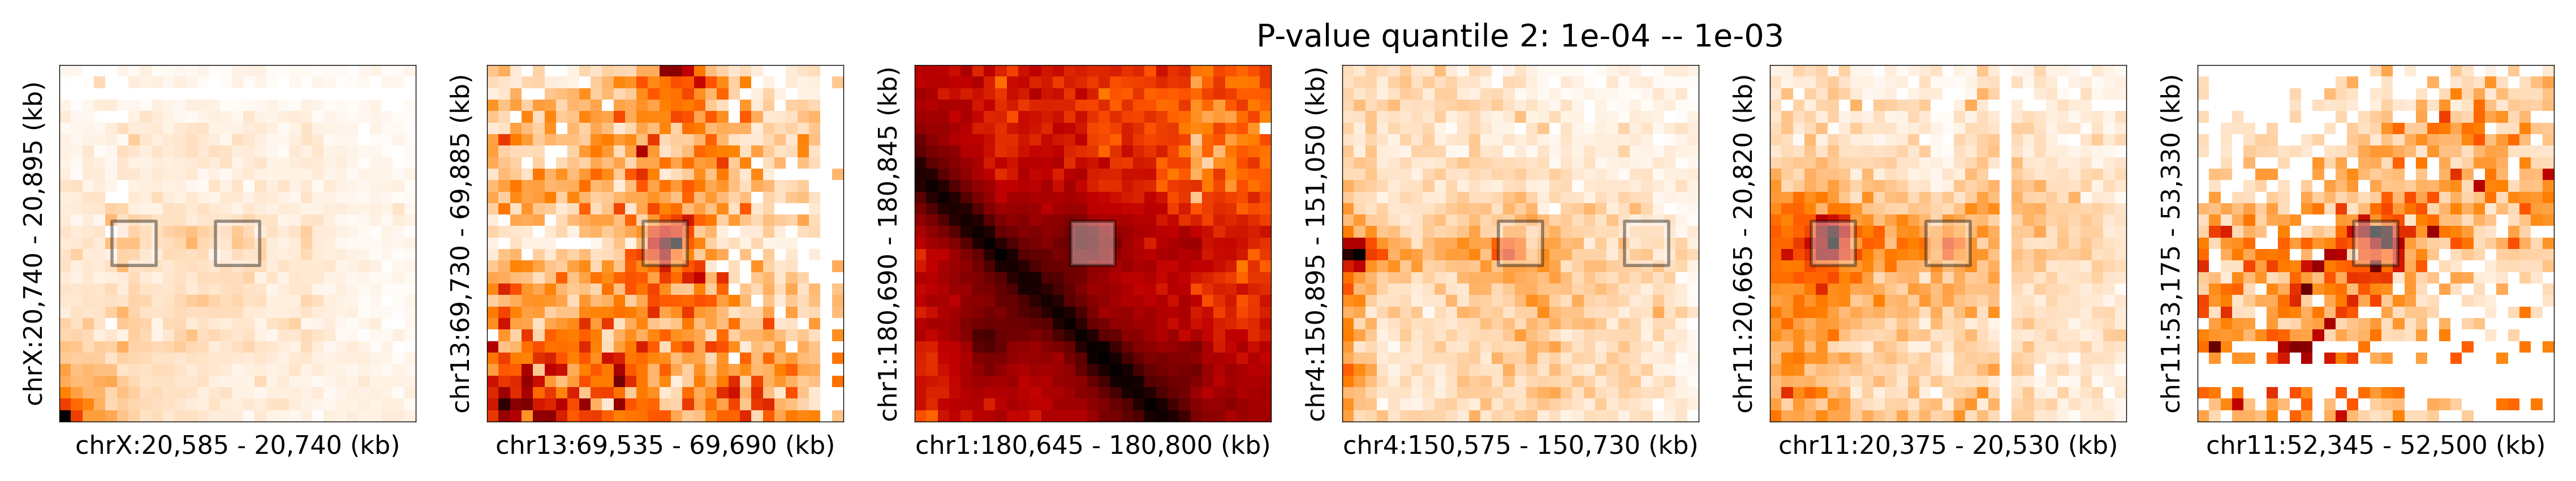

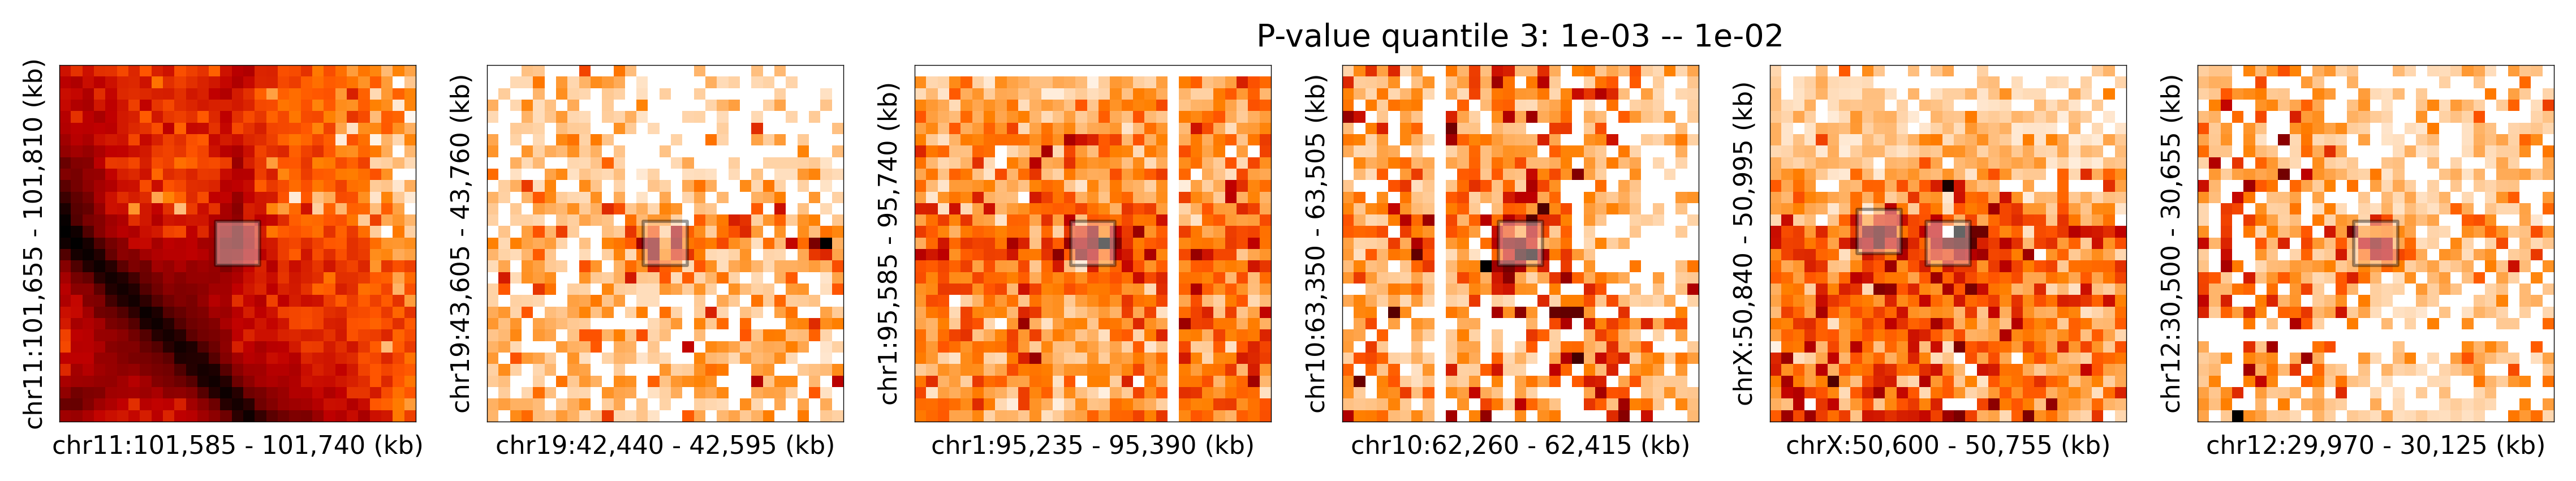

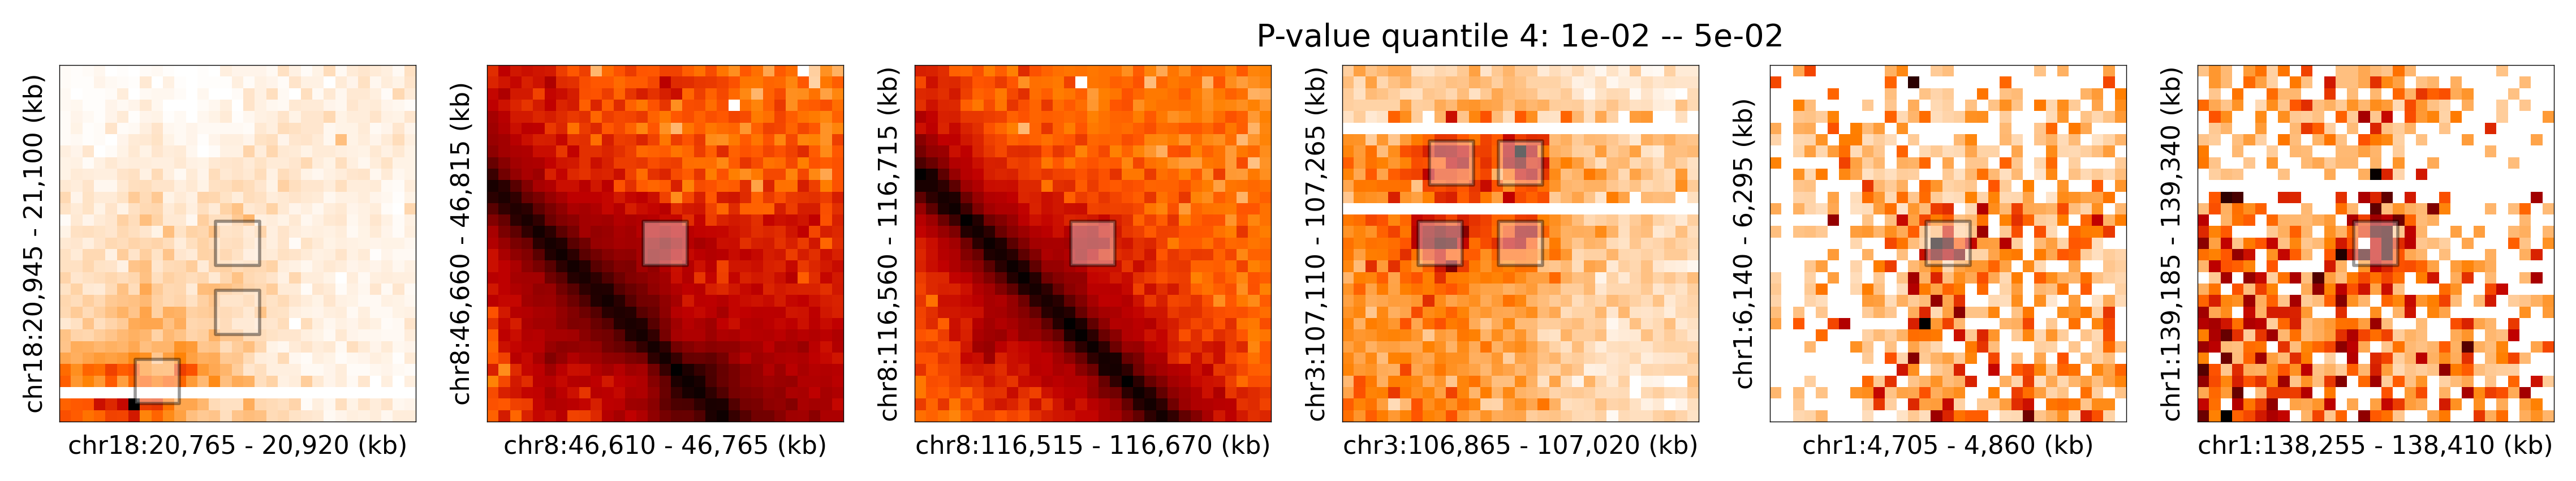

In [135]:
from supp_figures_plotting_functions import plot_random_examples

figs = plot_random_examples(init_dfs, cooldict_5kb)

D2. Looops by replicate

In [126]:
name = 'by_replicates'
oe_df = pd.read_csv(f'./data_for_enhancer_umap/oe_df_{name}.csv', sep='\t', index_col = 0)

with open(f'./full_pileup_dict_{name}', 'rb') as f:
    full_pileup_dict = pickle.load(f)

In [94]:
loops_with_FDR = pd.read_csv('final_loops/all_loops.csv', sep='\t', index_col = 0)

In [133]:
def df_to_loop_grange_list(df):
    loop_grange_list = []
    for _, row in  df.iterrows():
        loop_grange = granges_to_loop_grange(tuple_to_grange(*add_chr_to_anc(make_str(row[:3].values))),
                                             tuple_to_grange(*add_chr_to_anc(make_str(row[3:6].values))))
        loop_grange_list.append(loop_grange)
    return loop_grange_list



Imported plotting functions


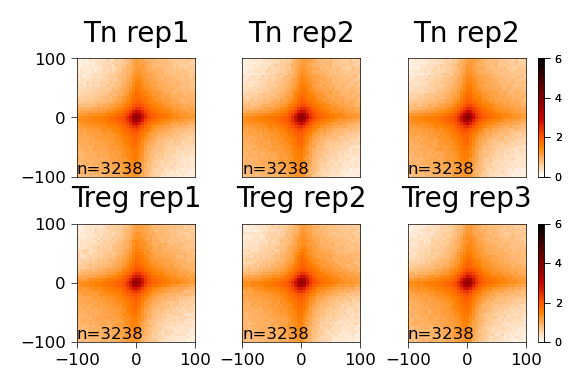

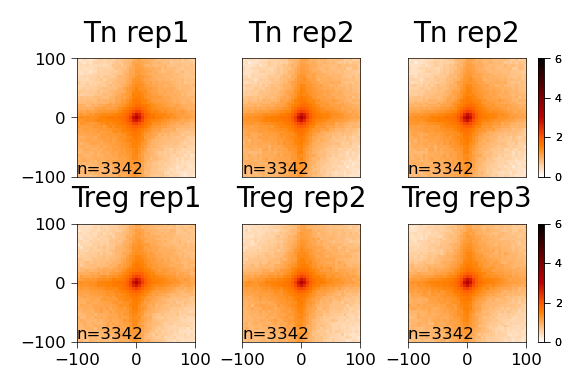

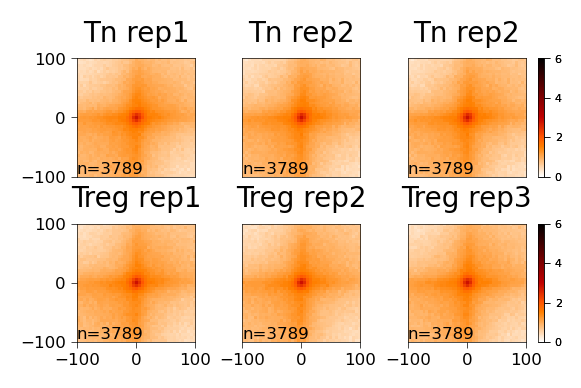

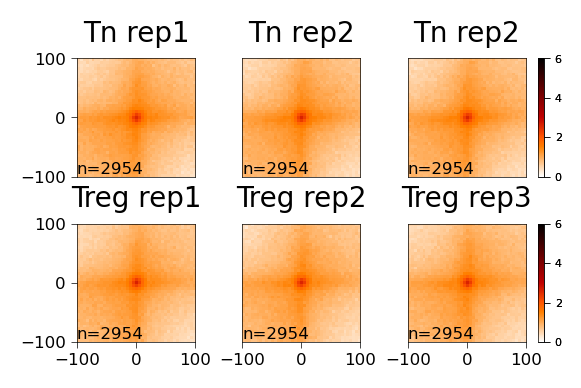

In [158]:
from supp_figures_plotting_functions import plot_apa

quants = [0, .0001, .002, .01, .02, 1]
qs = pd.cut(loops_with_FDR['FDR'], quants, labels=False)
for u in np.unique(qs):
    idx = qs == u
    loop_granges = pd.Series(arr(df_to_loop_grange_list(loops_with_FDR[idx].iloc[:, :6])))
    oe_idx = oe_df.index.isin(loop_granges)
    fig  = plot_apa(full_pileup_dict, idx = oe_idx, res=5000)
    fig.savefig(f'./plots/paper/s2/baseline_loops_{quants[u]}-{quants[u+1]}.pdf', 
               bbox_inches='tight')

E. Manhattan plot

Imported plotting functions


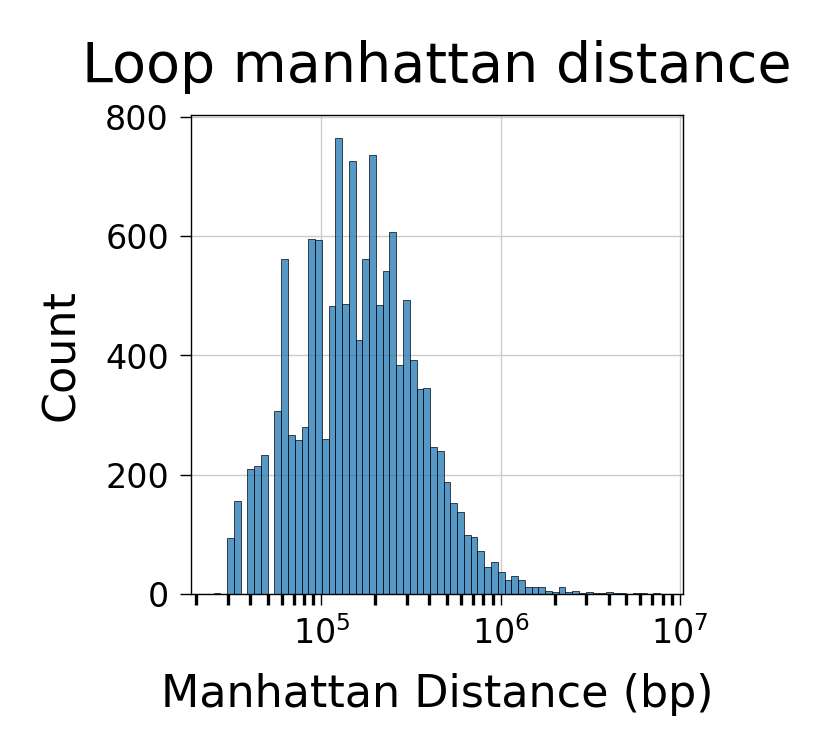

In [176]:
from supp_figures_plotting_functions import make_manhattan_distance_plot

make_manhattan_distance_plot(all_loops)

F. DESeq2 MA Plot

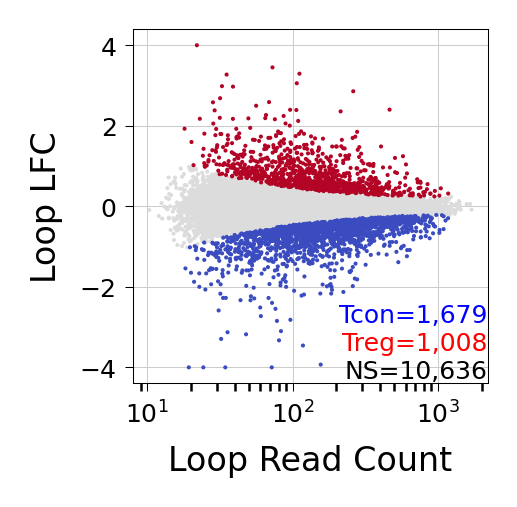

In [172]:
from supp_figures_plotting_functions import deseq_ma_plot

fig = deseq_ma_plot(all_loops.to_dataframe(header=None))
fig.savefig("./plots/paper/s2/deseq_maplot.pdf", bbox_inches='tight')

Compare Jesse/Ye loops with our loops

Imported plotting functions


/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin1_start'], df['bin1_end'] = zip(*new_coords_bin1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin2_start'], df['bin2_end'] = zip(*new_coords_bin2)


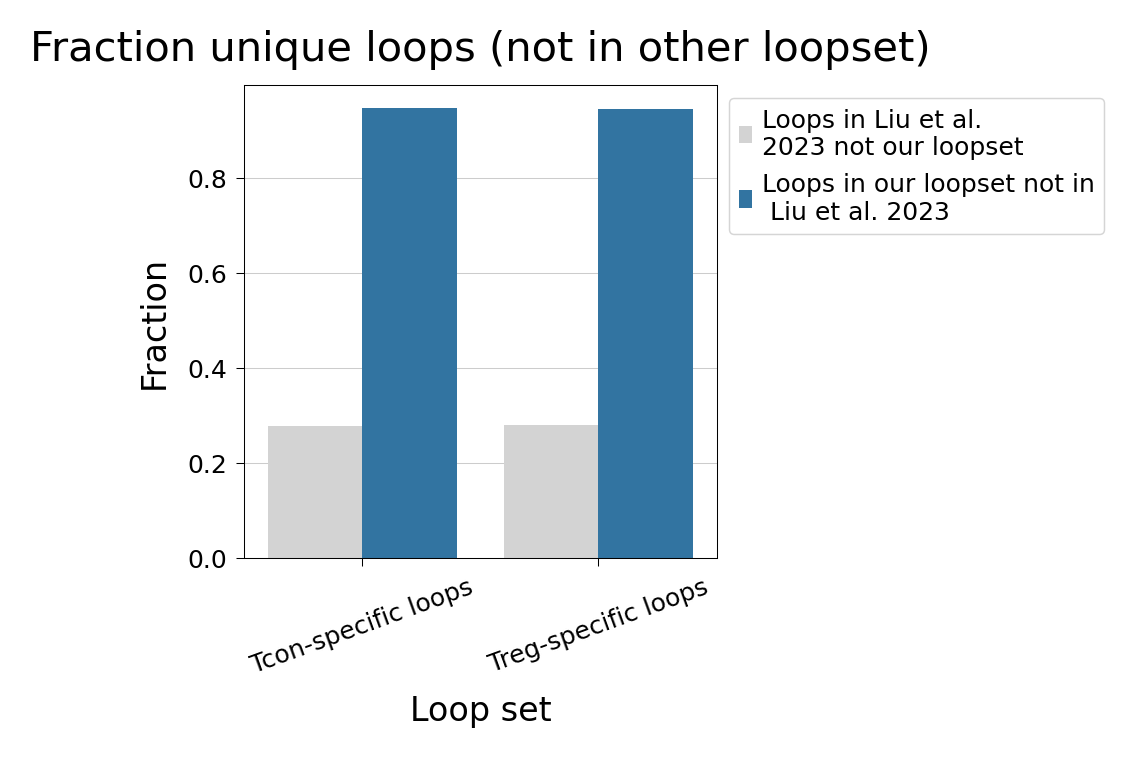

In [186]:
from supp_figures_plotting_functions import compare_jesseye_loops_to_our_loops

compare_jesseye_loops_to_our_loops(loopdict)

#### Figure S2

In [307]:
import aux_functions
from aux_functions import *

In [73]:
%autoreload 2
from supp_figures_plotting_functions import process_deseq2_output

d = process_deseq2_output()

Imported plotting functions


A. Venn Diagrams

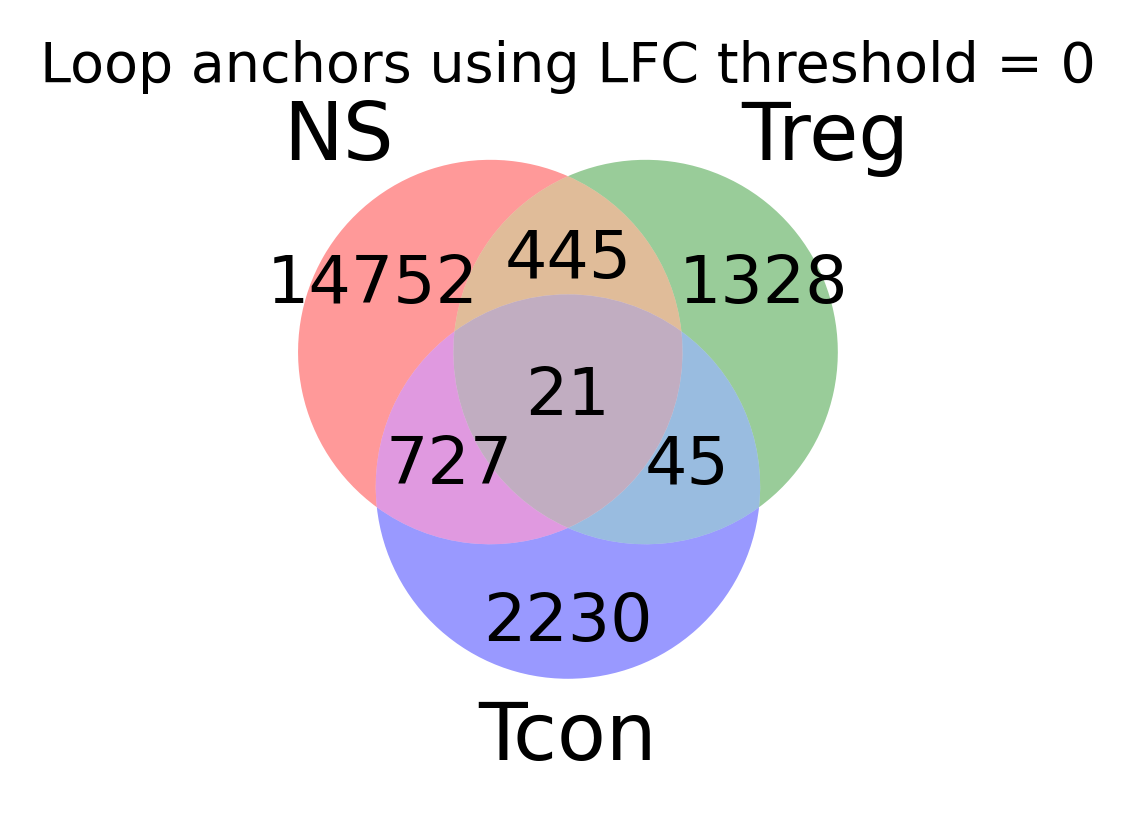

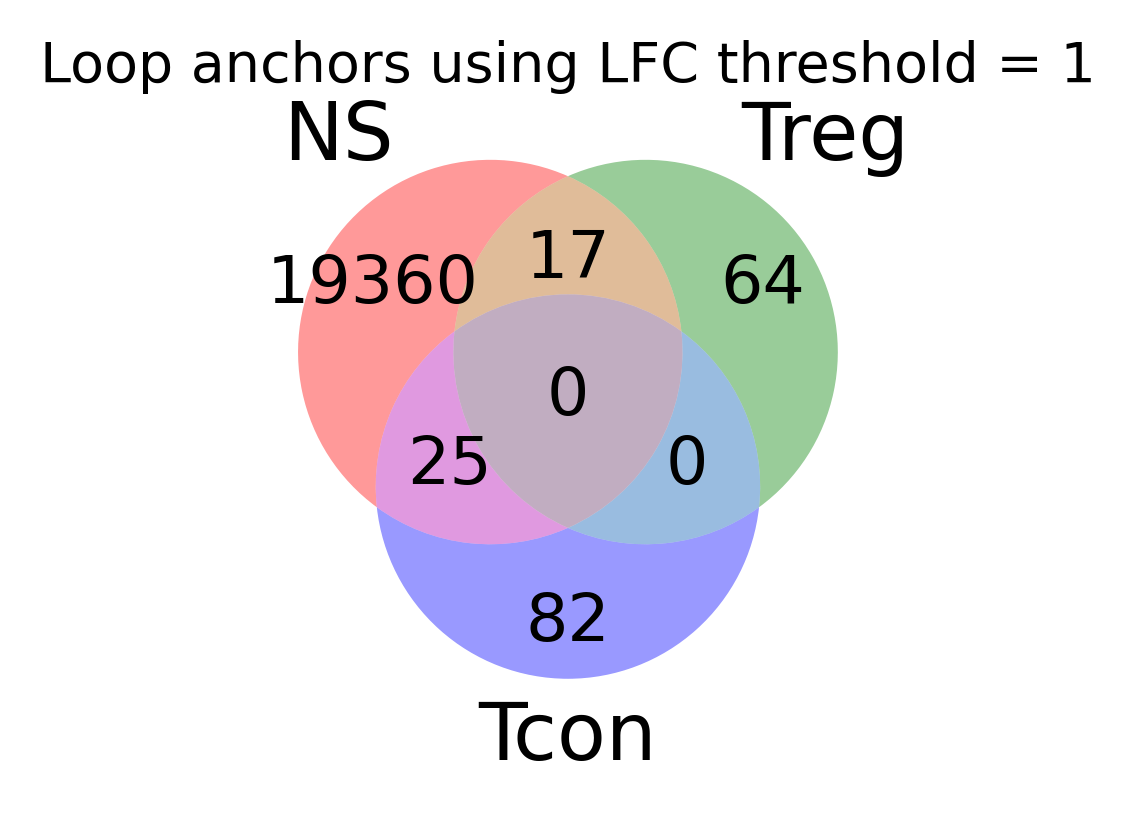

In [183]:
from supp_figures_plotting_functions import make_venn_diagram_plot_s3

make_venn_diagram_plot_s3()


B. LFC plots

Imported plotting functions
1
1


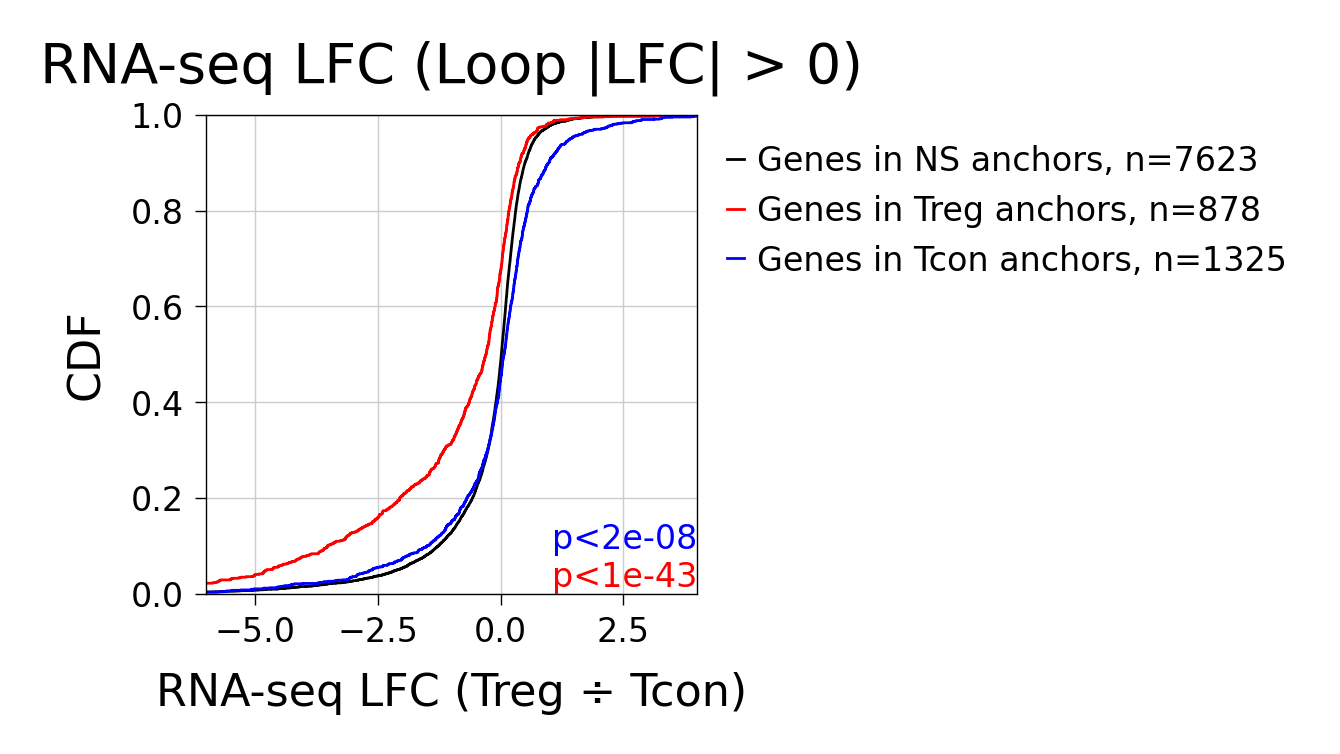

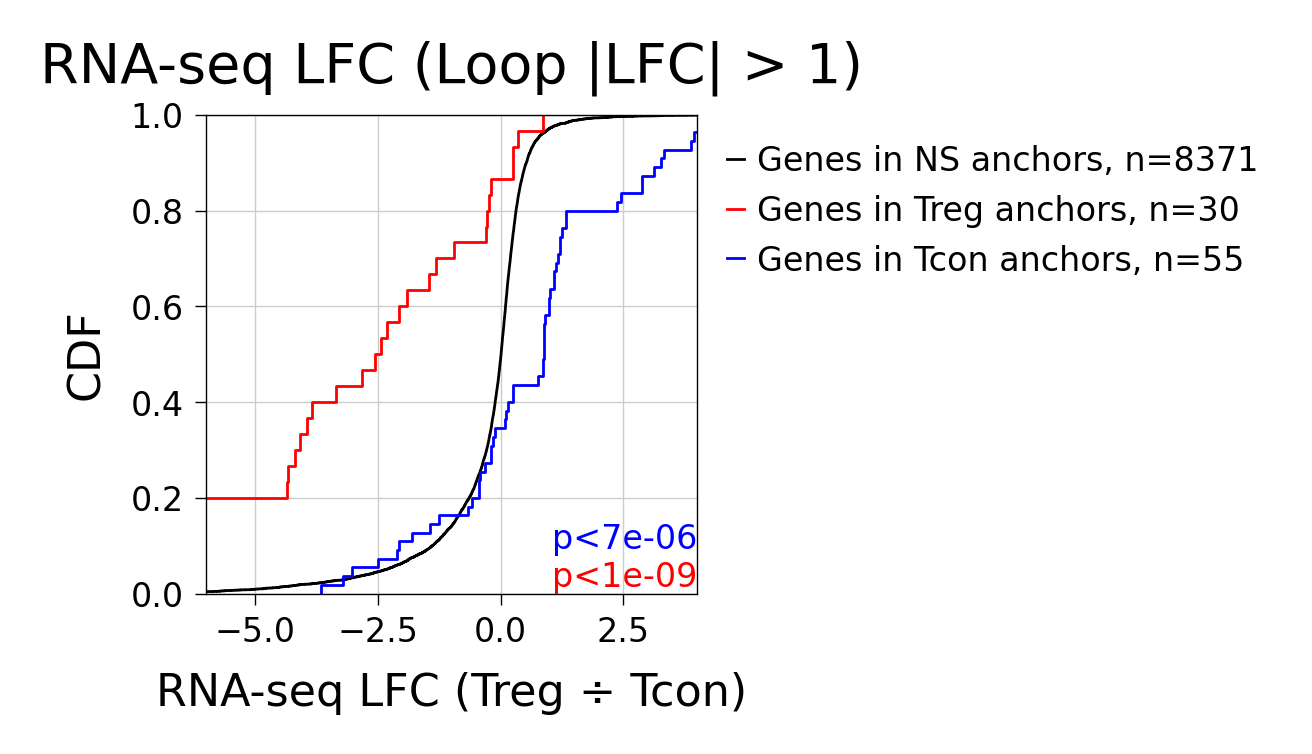

In [43]:
%autoreload 2
from supp_figures_plotting_functions import make_loop_lfc_cdf_plot

make_loop_lfc_cdf_plot(resting_gene_bedtool)

C. TAD Boundaries

Imported plotting functions
3
Could not fetch in  Treg  error:  Genomic region out of bounds: [119750000, 120155000)
Could not fetch in  Treg  error:  Genomic region out of bounds: [181735000, 182140000)
Could not fetch in  Treg  error:  Genomic region out of bounds: [145045000, 145450000)
Done with Treg


/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:269: RuntimeWarning: Mean of empty slice
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:270: RuntimeWarning: Mean of empty slice
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:278: RuntimeWarning: divide by zero encountered in log2


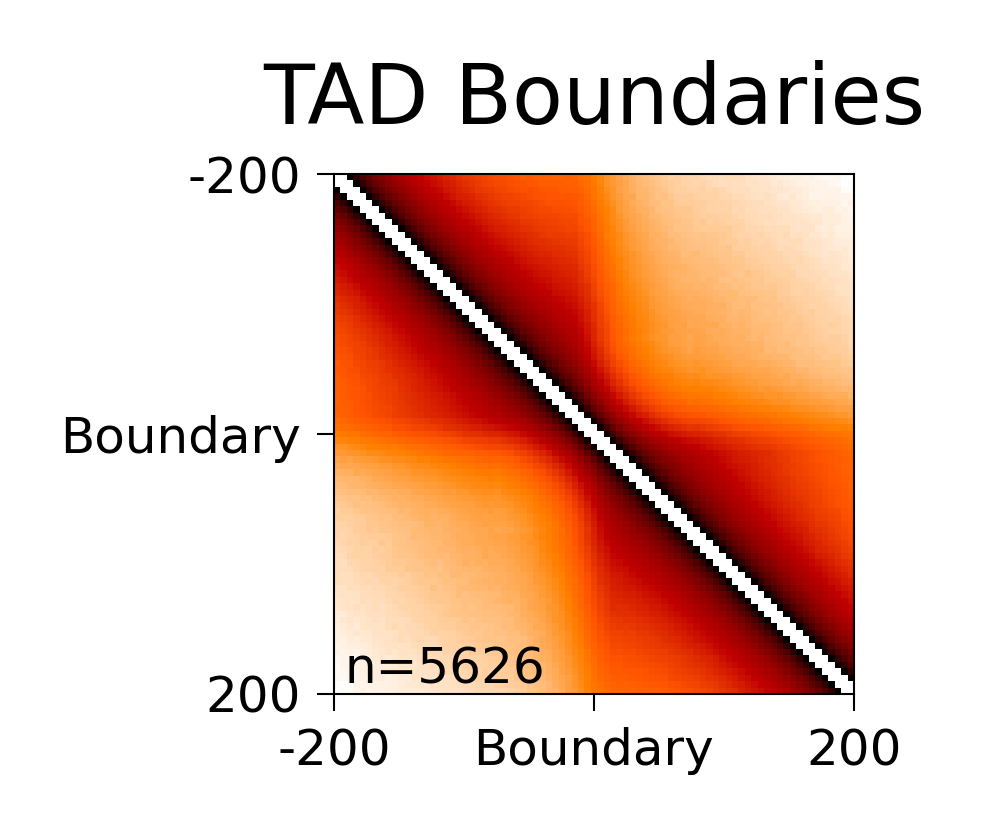

In [316]:
%autoreload 2

from supp_figures_plotting_functions import make_tad_plot2
from apa_figures import apa_diag_nonorm

make_tad_plot2()

TSS with loops

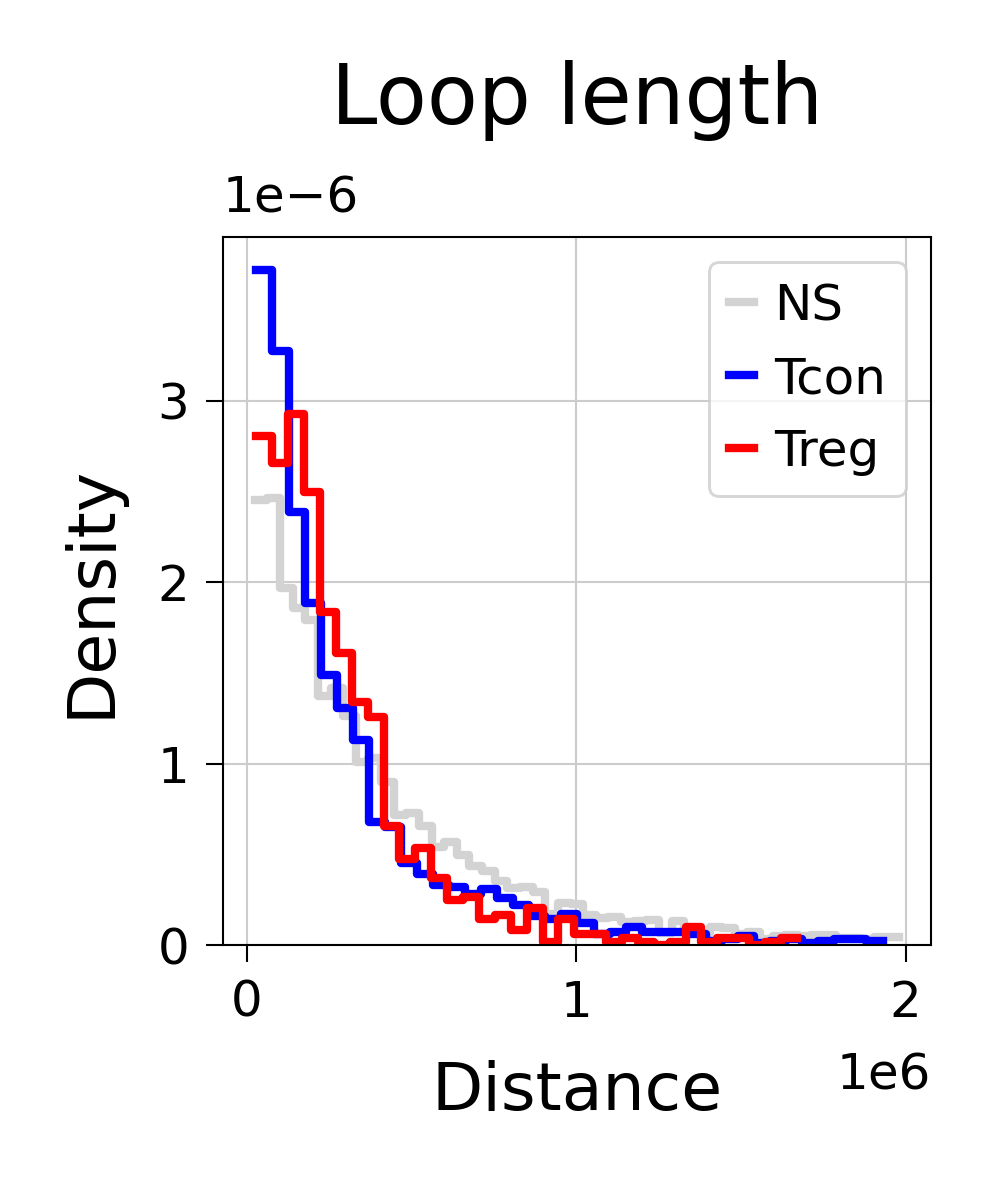

In [320]:
from supp_figures_plotting_functions import make_looplength_plot

make_looplength_plot(loopdict, loop_colordict)

G

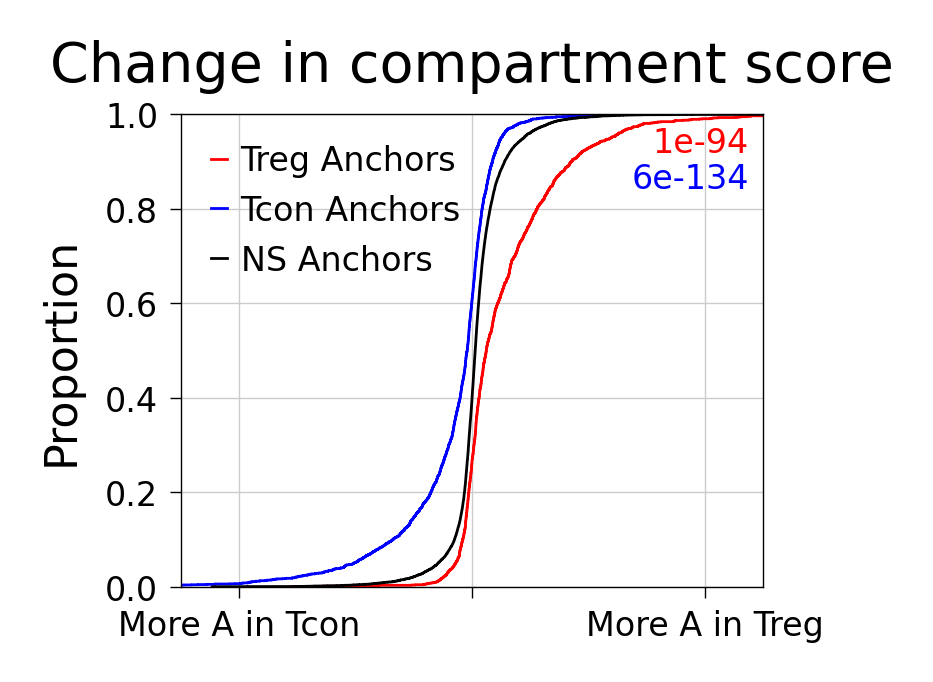

In [1119]:
treg_ancs = np.where(get_col(pbt.BedTool(all_ind_to_region_50kb).intersect(anchordict['Treg'], c=True), -1).astype(int)>0)[0]
tcon_ancs = np.where(get_col(pbt.BedTool(all_ind_to_region_50kb).intersect(anchordict['Tcon'], c=True), -1).astype(int)>0)[0]
ns_ancs = np.where(get_col(pbt.BedTool(all_ind_to_region_50kb).intersect(anchordict['NS'], c=True), -1).astype(int)>0)[0]

d = (my_treg_comp_50kb-my_tcon_comp_50kb)
fig, axs = init_subplots_exact(1, 1, fgsz=(37*mm, 30*mm), dpi = 200)
sns.ecdfplot(d[treg_ancs], color='red', ax=axs, label=f'Treg Anchors')
sns.ecdfplot(d[tcon_ancs], color='blue', ax=axs, label=f'Tcon Anchors')
sns.ecdfplot(d[ns_ancs], color='black', ax=axs, label=f'NS Anchors')

treg_pstr = format_pvalue(nonan_test(d[treg_ancs], d[ns_ancs])[1])
tcon_pstr = format_pvalue(nonan_test(d[tcon_ancs], d[ns_ancs])[1])
plt.text(0.975, .975, treg_pstr, color='red', transform = plt.gca().transAxes, va='top', ha='right', fontsize=6)
plt.text(0.975, .9, tcon_pstr, color='blue', transform = plt.gca().transAxes, va='top', ha='right', fontsize=6)
plt.xticks([-1, 0, 1])
plt.xlim([-1.25, 1.25])
axs.set_xticklabels(["More A in Tcon", '', 'More A in Treg'])
plt.title("Change in compartment score")
plt.legend(frameon=False)
fig.savefig('./plots/paper//compartment_score_loop_anchors.pdf', bbox_inches='tight')

Fraction of TSS with loops

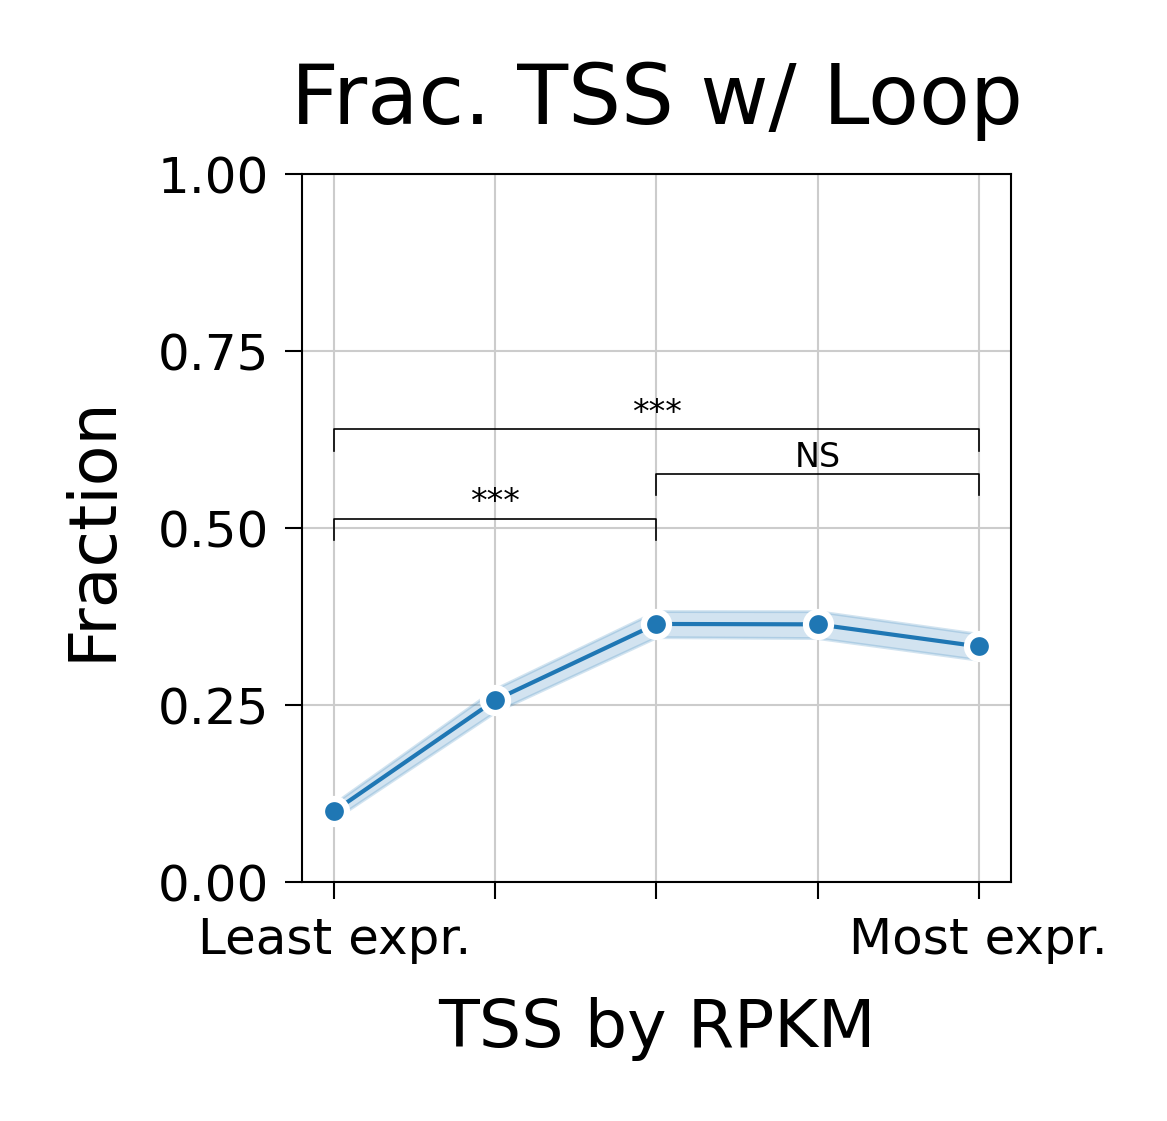

In [1472]:
v = make_tss_lineplot3(gene_dict['Resting'], anchordict)

In [1471]:
from plot_pvals import add_stat_annotation_boxplot_no_hue
def make_tss_lineplot3(resting_gene_lfcs, anchordict):
    idx = resting_gene_lfcs.index[my_tss_df.set_index('gene_name').loc[resting_gene_lfcs.index]['chrom'].isin(add_chr_to_list(parsed_chroms))]
    transcribed_genes = resting_gene_lfcs.loc[idx]
    v = transcribed_genes['rpkm']
    
    v = v.loc[idx]
    
    # v = transcribed_genes['itemRgb'][idx]
    # return v, transcribed_genes['itemRgb'][idx]
    quantile_cut = pd.qcut(v, np.linspace(0, 1, 6))
    
    # Accessing the codes (integer representation) of the bins
    categorical_data = quantile_cut.cat
    codes = categorical_data.codes

    tmp_gene_bedtool = pbt.BedTool.from_dataframe(my_tss_df.set_index('gene_name').loc[idx][['chrom', 'start', 'end']])
    anchors = add_chr_to_bedtool(anchordict['All'])
    has_anchor = pd.Series(get_col(tmp_gene_bedtool.intersect(anchors, c=True), -1).astype(int),
                          index = v.index) > 0
    data = pd.concat([codes, has_anchor, v], axis=1)
    data.columns = ['quantile', 'has_anchor', 'rpkm']
    
    data['quantile'] /= data['quantile'].max()
    fig, ax = init_subplots_exact(1, 1, fgsz=(30*mm, 30*mm), dpi=300)
    sns.lineplot(data=data, x='quantile', y='has_anchor', marker='o', markersize=3)
    # plt.plot(arr(quantiles) / np.max(arr(quantiles)), ls, marker='o', markersize=2)
    plt.xlabel("TSS by RPKM")
    plt.ylabel("Fraction")
    plt.title("Frac. TSS w/ Loop")
    plt.yticks([0, .25, .5, .75, 1])
    plt.xticks([0, .25, .5, .75, 1])
    
    _, p = scipy.stats.fisher_exact([ [(data[data==1]['has_anchor'] > 0).sum(), (data[data==1]['has_anchor'] == 0).sum()],
                                     [(data[data==0]['has_anchor'] > 0).sum(), (data[data==0]['has_anchor'] == 0).sum()],
                                    ])
    add_stat_annotation_boxplot_no_hue(ax, data, 'quantile', 'has_anchor',
                                      [0, .25, .5, .75, 1], [
                                          [0, .5],
                                          [.5, 1],
                                          [0, 1],
                                              ], ymax=.4, h=.03,
                                       x_skip = 1/4,
                                      )
    plt.ylim([0, 1])    
    ax.set_xticklabels(['Least expr.', '', '', '', 'Most expr.'])
    fig.savefig('./plots/paper/s3/frac_genes_in_loops.pdf', bbox_inches='tight', dpi=300)
    plt.show()


In [887]:
def make_tss_lineplot2(resting_gene_lfcs, gene_lengths, my_tss_df, anchordict):
    transcribed_genes = resting_gene_lfcs
    idx = gene_lengths.index.intersection(transcribed_genes.index)
    
    gene_lengths = gene_lengths.loc[idx]
    transcribed_genes = transcribed_genes.loc[idx]
    my_tss_df = my_tss_df.set_index('gene_name').loc[idx]

    v = transcribed_genes['itemRgb'] / gene_lengths

    quantile_cut = pd.qcut(v, np.linspace(0, 1, 10))
    
    # Accessing the codes (integer representation) of the bins
    categorical_data = quantile_cut.cat
    codes = categorical_data.codes

    ls = []
    readcount = []
    quantiles = []
    for i in sorted(codes.unique()):
        genesoi = codes.index[codes == i]
        subdf = my_tss_df.loc[genesoi].reset_index()
        rpkms = v.loc[genesoi]
        tmp_gene_bedtool = pbt.BedTool.from_dataframe(subdf[['chrom', 'start', 'end']])
        ls.append(bedprop(tmp_gene_bedtool, add_chr_to_bedtool(anchordict['All'])))
        readcount.append(rpkms.mean())
        quantiles.append(i)
    
    fig, ax = init_subplots_exact(1, 1, fgsz=(30*mm, 30*mm), dpi=300)
    plt.plot(arr(quantiles) / np.max(arr(quantiles)), ls, marker='o', markersize=2)
    plt.xlabel("TSS by gene expression")
    plt.ylabel("Fraction")
    plt.title("Frac. TSS w/ Loop")
    plt.yticks([0, .25, .5, .75, 1])
    plt.xticks([0, .25, .5, .75, 1])
    ax.set_xticklabels(['Least expr.', '', '', '', 'Most expr.'])
    fig.savefig('./plots/paper/s3/frac_genes_in_loops.pdf', bbox_inches='tight', dpi=300)
    plt.show()


I. Loops crossing TAD boundaries

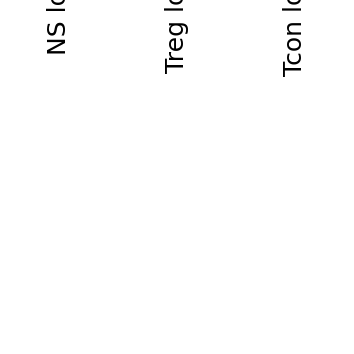

In [2420]:
from supp_figures_plotting_functions import loop_tad_overlap

loop_tad_overlap(loopdict, tad_boundaries)

### Supplement 3

Look at notebooks in "plot_coolbox"

### Supplement 4

Look at notebooks in "cABC analysis"

### Figure S5

A. 

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


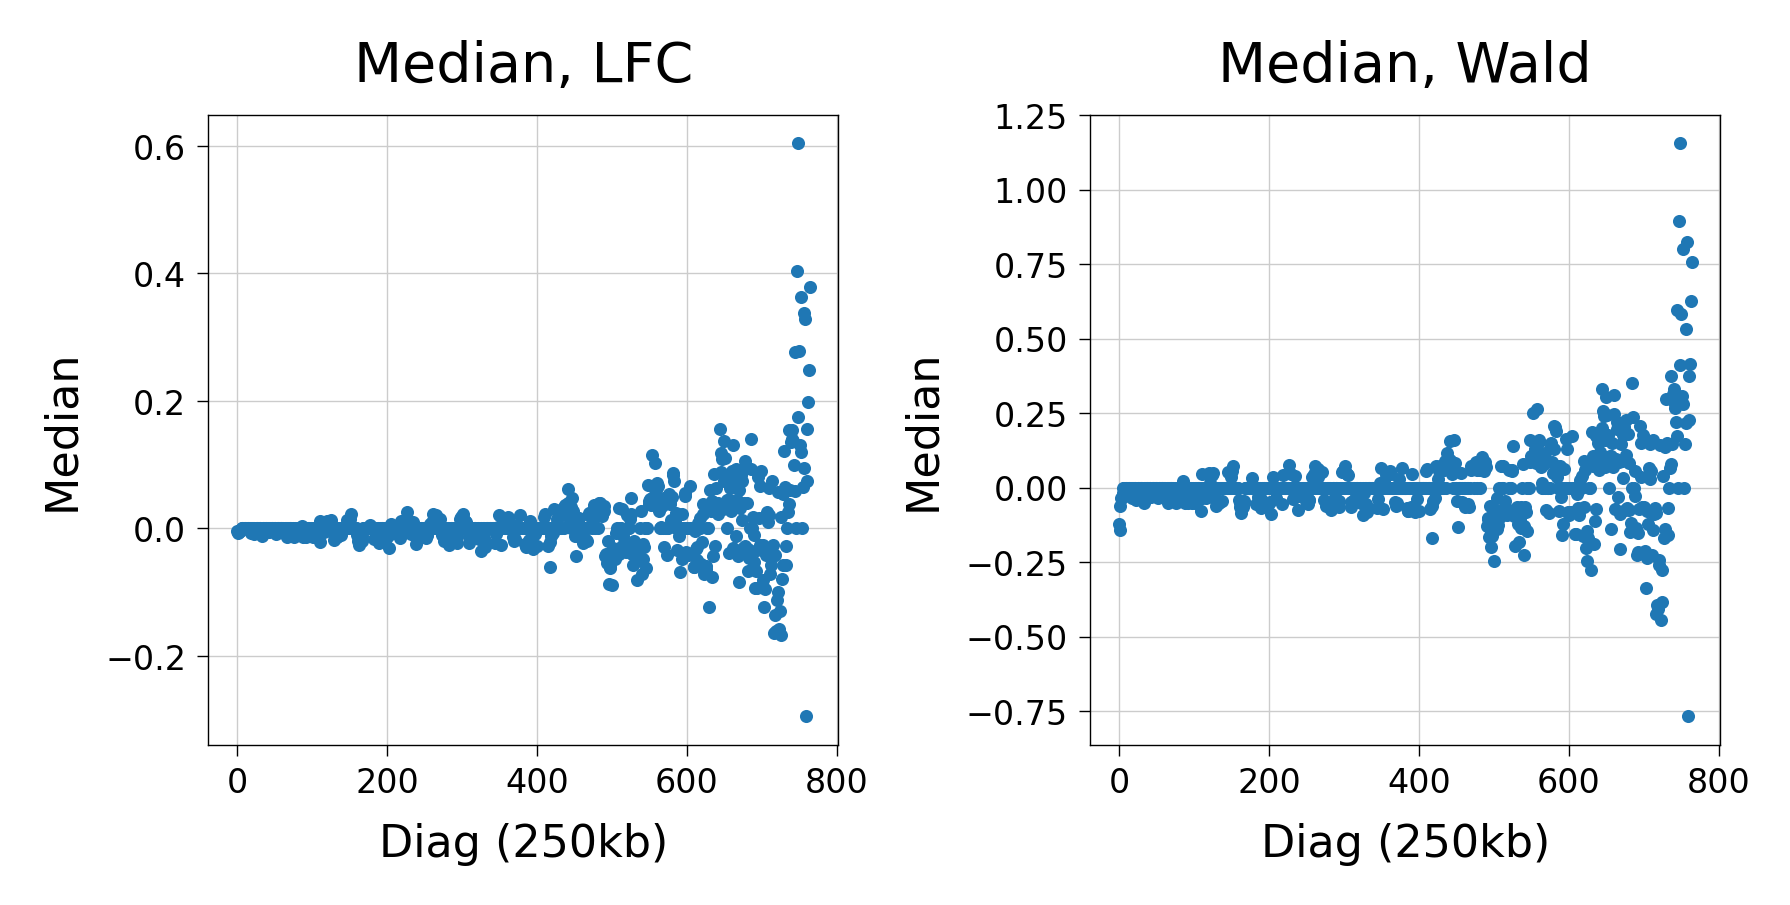

In [331]:
from supp_figures_plotting_functions import balanced_supplement_plots

fig = balanced_supplement_plots(deseq_lfc_mat, deseq_effect_mat)


B. Genes per 250kb bin

Imported plotting functions


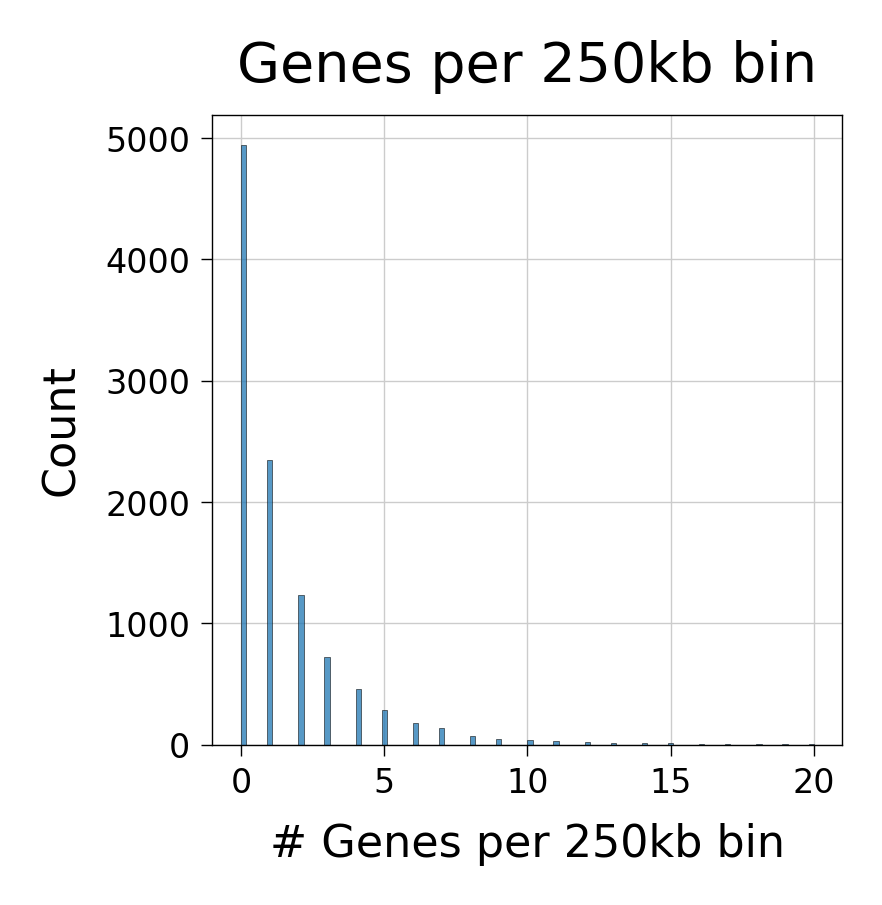

In [207]:
from supp_figures_plotting_functions import n_genes_per_bin

fig = n_genes_per_bin(ind_to_gene, all_ind_to_region)

C-D. Chromosome-wide DESeq2 Heatmaps

5


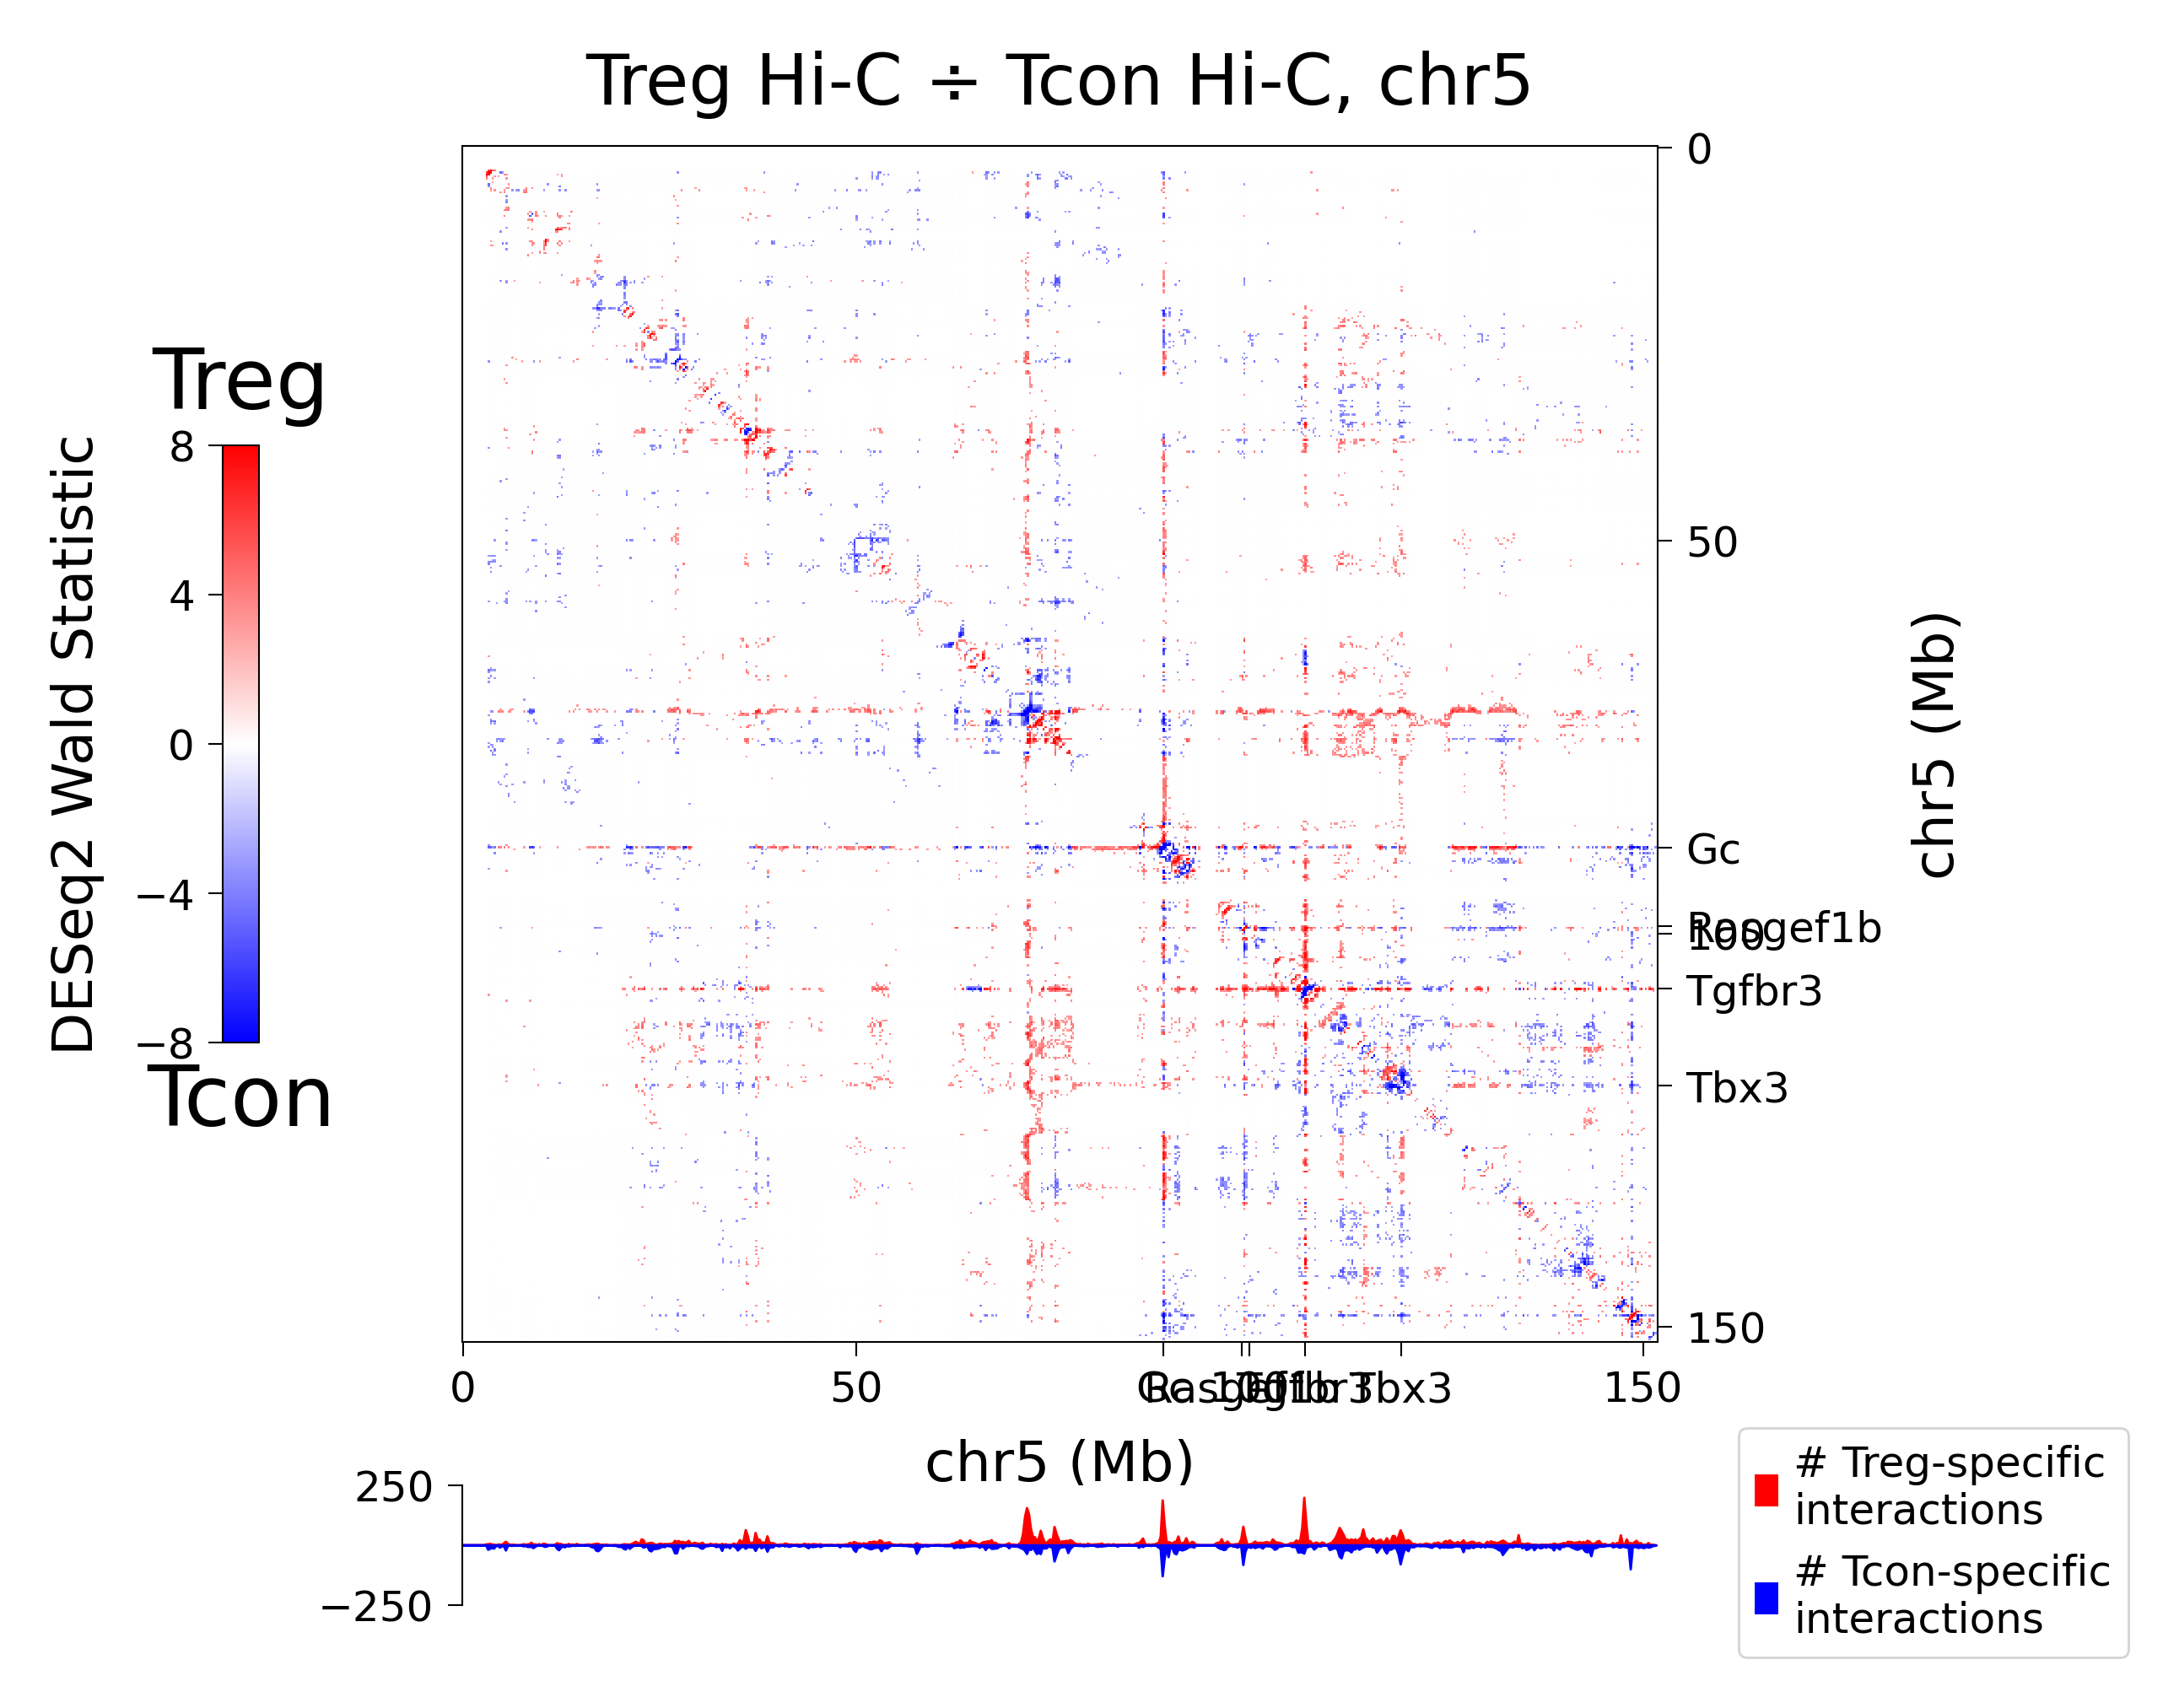

In [352]:
from supp_figures_plotting_functions import make_chromosomewide_deseq_plot

label_list = [[3208, 'Tgfbr3'], [3176, 'Rasgef1b'], [3136, 'Gc'], [3257, 'Tbx3']]
fig = make_chromosomewide_deseq_plot(deseq_effect_mat, deseq_pval_mat, '5', chrom_to_start, chrom_to_end, label_list, dpi = 300)
fig.savefig('./plots/paper/s8/chr5.pdf', bbox_inches='tight', dpi = 300)

4


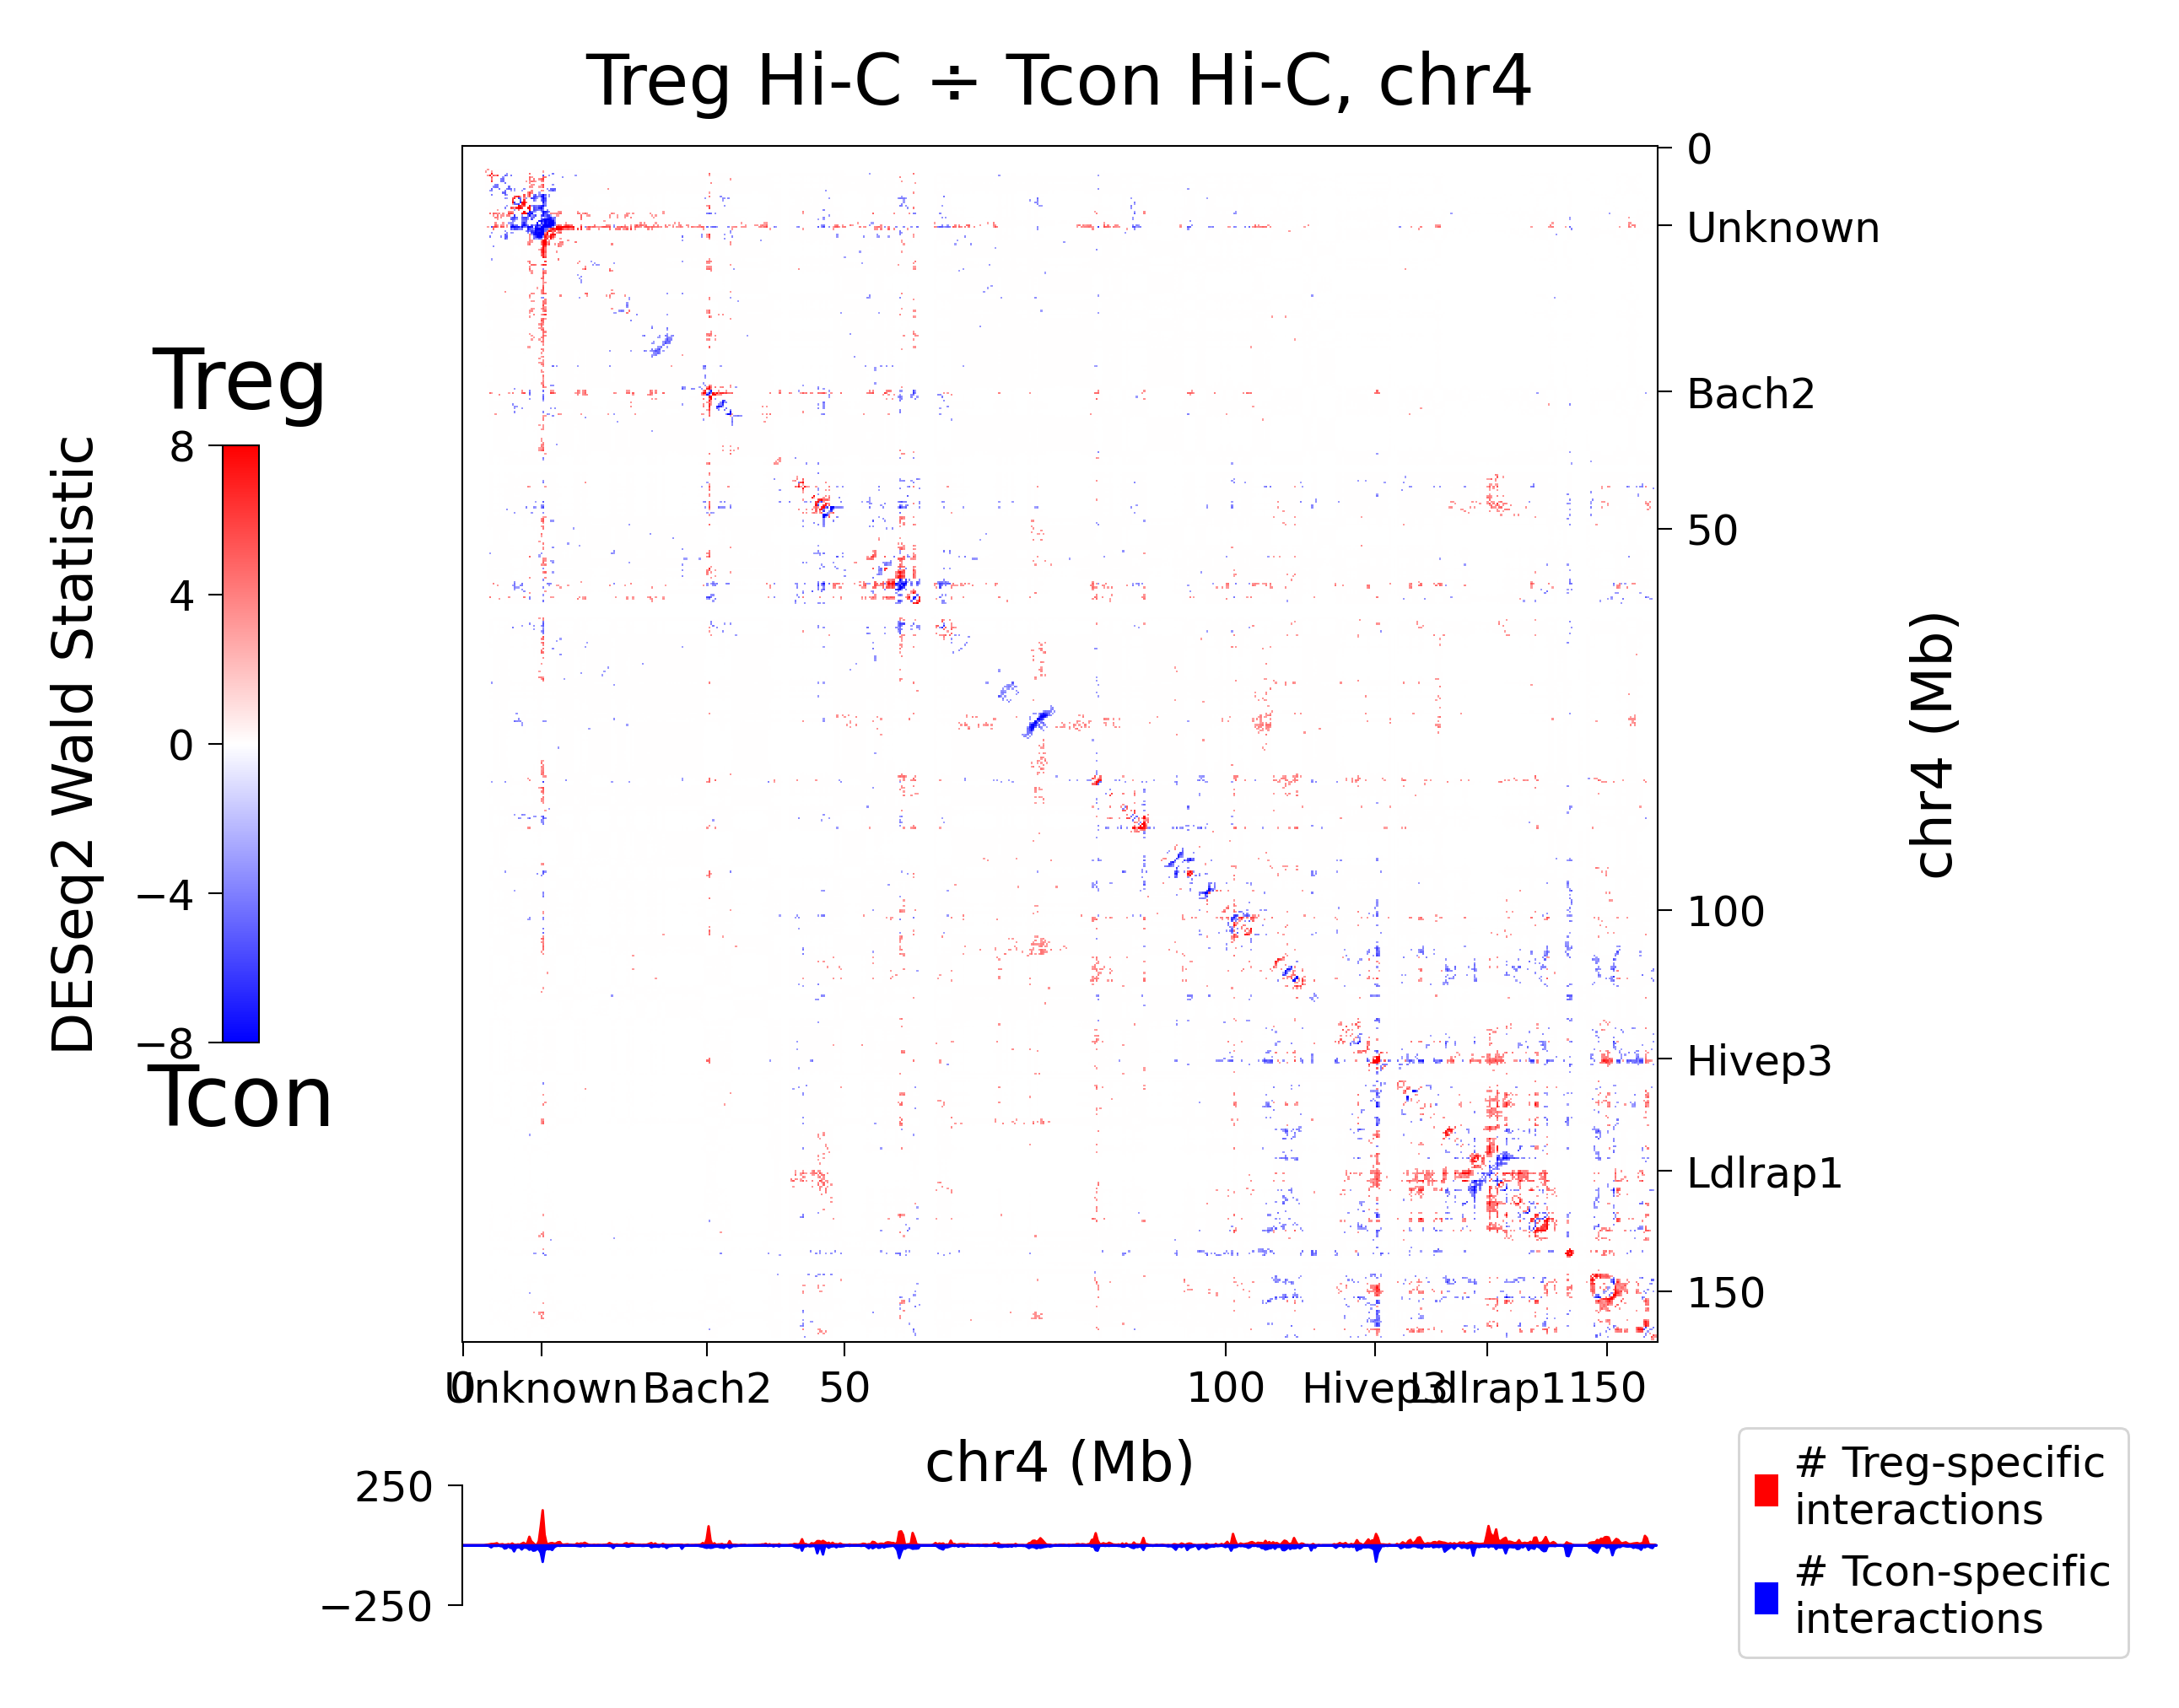

In [205]:
from supp_figures_plotting_functions import make_chromosomewide_deseq_plot

label_list = [[2281, 'Bach2'], [2194, 'Unknown'], [2631, 'Hivep3'], [2690, 'Ldlrap1']]
fig = make_chromosomewide_deseq_plot(deseq_effect_mat, deseq_pval_mat, '4', chrom_to_start, chrom_to_end, label_list, dpi = 300)
fig.savefig('./plots/paper/s8/chr4.pdf', bbox_inches='tight', dpi = 300)

In [ ]:
from supp_figures_plotting_functions import make_chromosomewide_deseq_plot

label_list = [[1287, 'Atp8b4'], [1254, 'Gm13986'], [981, 'Lypd6b'], [1325, 'Plcb4']]
fig = make_chromosomewide_deseq_plot(deseq_effect_mat, deseq_pval_mat, '2', chrom_to_start, chrom_to_end, label_list, dpi = 300)
fig.savefig('./plots/paper/s8/chr2.pdf', bbox_inches='tight', dpi = 300)

E-F. Differential interactions manhattan plots

In [338]:
import logging
logging.getLogger().setLevel(logging.WARNING)

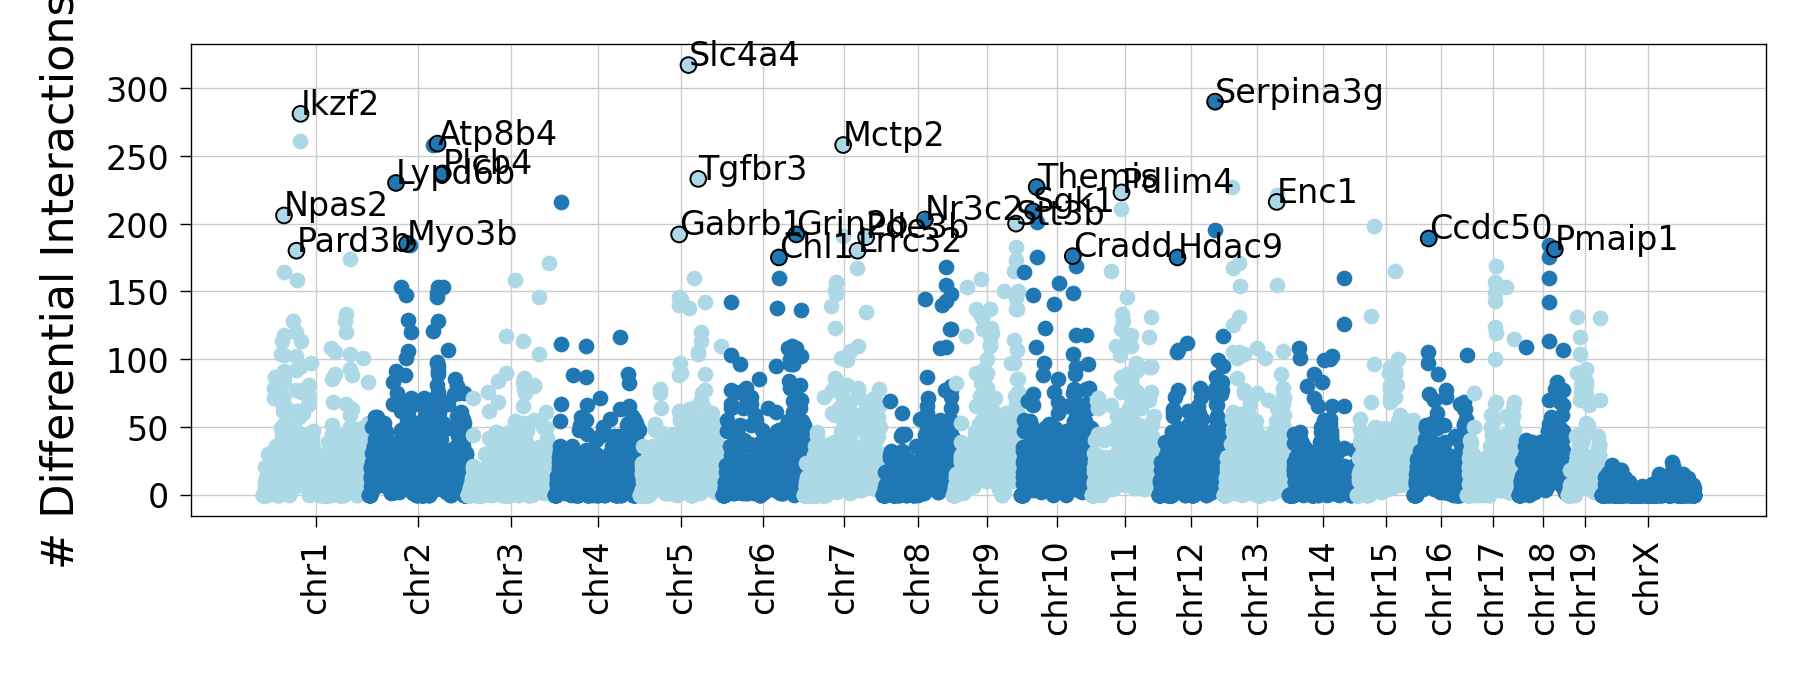

In [340]:
from supp_figures_plotting_functions import make_manhattan_plot

fig = make_manhattan_plot(deseq_pval_mat, all_ind_to_region, chrom_to_start, chrom_to_end, ind_to_gene, bin_cutoff=0, 
                          label_cutoff=175, dpi=200)
fig.savefig('./plots/paper/s8/manhattan_plot.pdf', bbox_inches='tight')

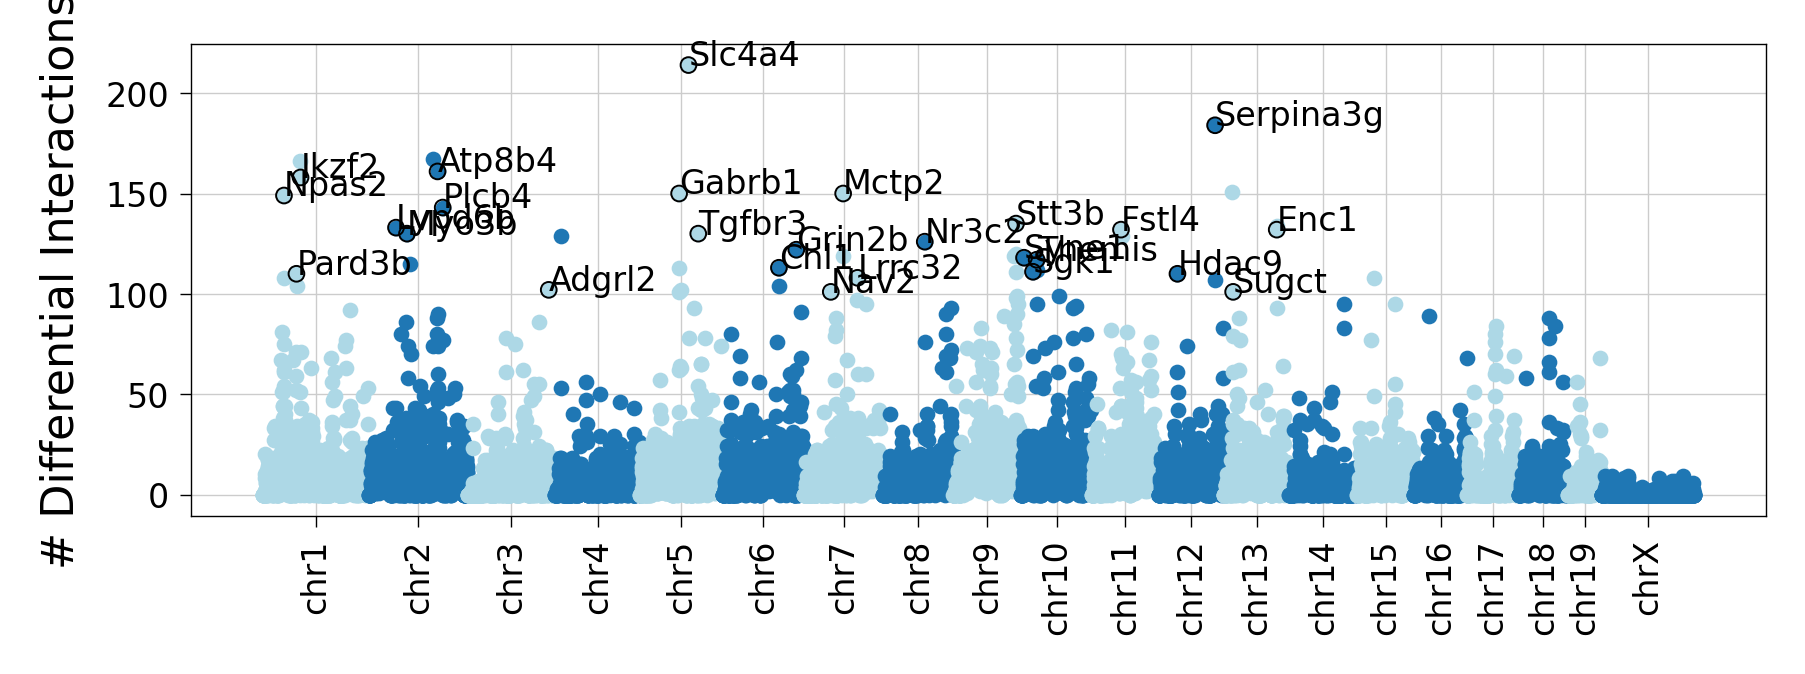

In [224]:
from supp_figures_plotting_functions import make_manhattan_plot

fig = make_manhattan_plot(deseq_pval_mat, all_ind_to_region, chrom_to_start, chrom_to_end, ind_to_gene, 
                          bin_cutoff=80, label_cutoff=100, dpi=200)
fig.savefig('./plots/paper/s8/manhattan_plot_distal.pdf', bbox_inches='tight')

G. Reproducibility of DESeq2

In [1047]:
from supp_figures_plotting_functions import deseq2_reproducibility_heatmap

g = deseq2_reproducibility_heatmap(deseq_pval_mat, deseq_effect_mat)
g.cax.set_ylabel('Z-score')
g.fig.savefig('./plots/paper/s6/ikzf2_replicate_heatmap.pdf', bbox_inches='tight')


/tmp/ipykernel_717572/3239441578.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.


### S6

All plots for long-range contacts shown in "plot_metadomains" folder

### Figure S7

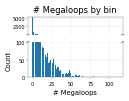

In [267]:
from supp_figures_plotting_functions import generate_metadomain_count_plot
generate_metadomain_count_plot(deseq_effect_mat, all_intra_metadomains, cutoff=4)

B. metadomain volcano plot

Imported plotting functions


/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:972: UserWarning: The following kwargs were not used by contour: 'label'


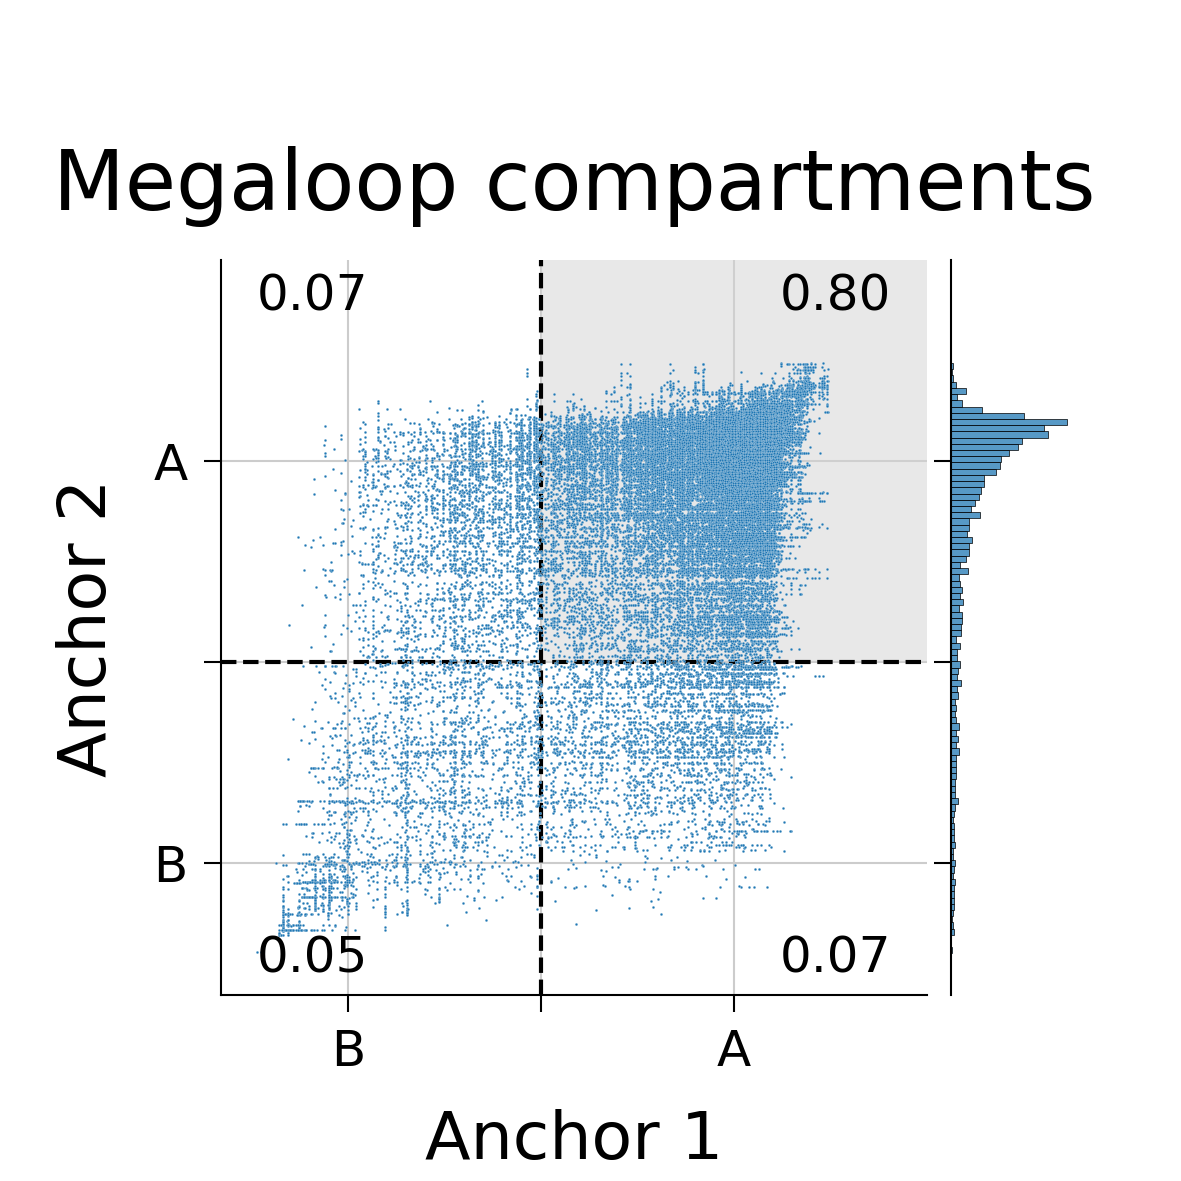

In [1309]:
from supp_figures_plotting_functions import generate_metadomain_compartment_plot

fig = generate_metadomain_compartment_plot(all_intra_metadomains, my_treg_comp, ACOMPARTMENT_CUTOFF_LOOSE, )
fig.savefig('./plots/paper/s11/compartment_of_metadomains.pdf', dpi=1000)    

C. 

In [1376]:
jac_coeffs = pd.DataFrame()
conds = ['treg_rep1_', 'treg_rep2_', 'treg_rep3_', 'tcon_rep1_', 'tcon_rep2_', 'tcon_rep3_']
for i in conds:
    jacs = []
    for j in conds:
        num = ((results.loc[i]>0) & (results.loc[j]>0)).sum()
        den = ((results.loc[i]>0) | (results.loc[j]>0)).sum()
        jac = num / den
        jacs.append(jac)
    jac_coeffs[i] = jacs
jac_coeffs.index = jac_coeffs.columns

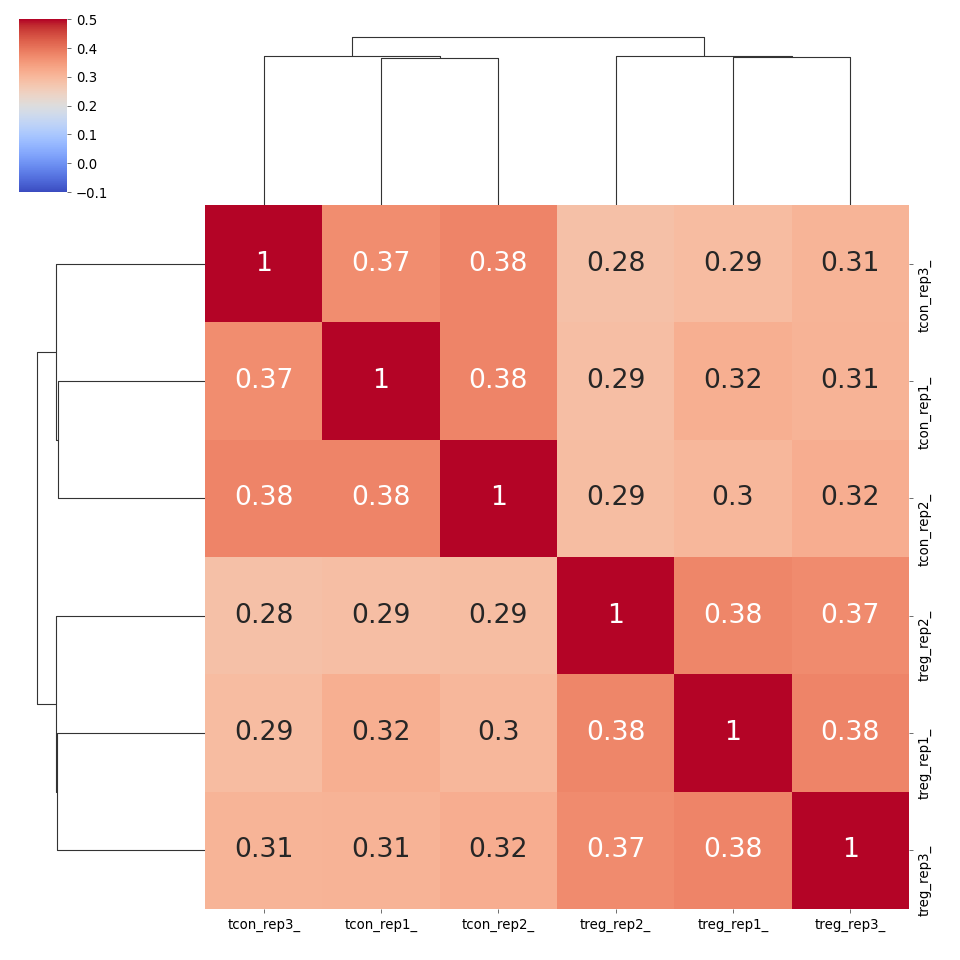

In [1387]:
g = sns.clustermap(jac_coeffs, vmax=.5, cmap='coolwarm', vmin=-.1, annot=True, figsize=(6, 6))
g.fig.savefig('./plots/paper/s11/longshot_reproducibility.pdf', bbox_inches='tight')

D. 

Imported plotting functions


/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


ignoring None-Ptprt
ignoring Themis-None
ignoring None-Dusp6
ignoring Ankmy2-Dock4
ignoring Ank-None
ignoring Ank-None
ignoring Trio-None
ignoring Trio-None
ignoring Rftn1-None
ignoring None-None
ignoring Csnk1g3-Lmnb1
ignoring None-None


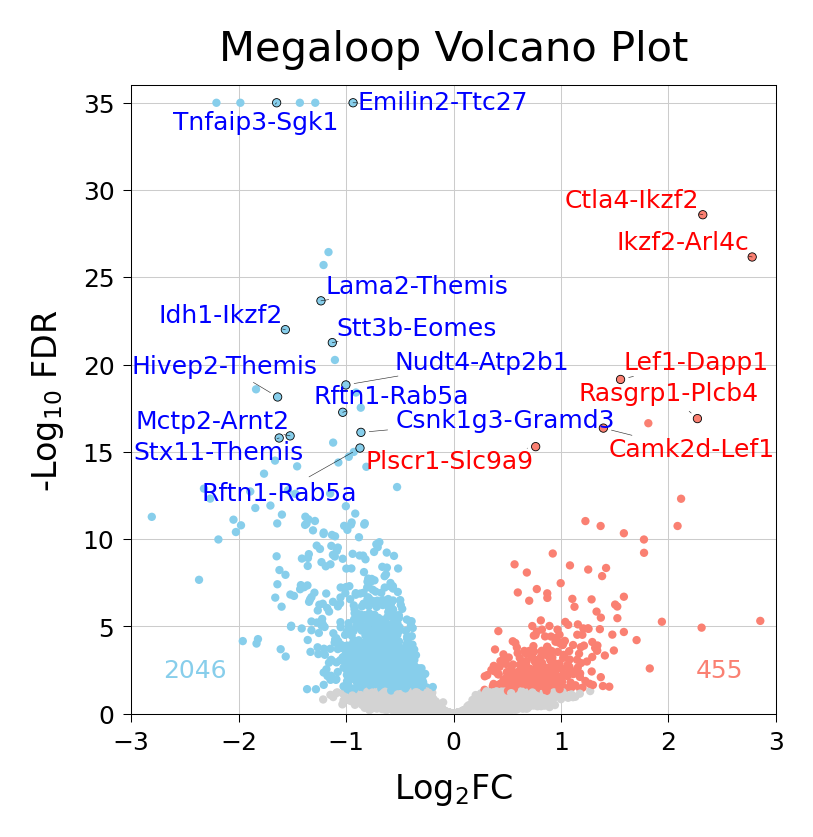

In [311]:
from volcano_plot import volcano_plot
from supp_figures_plotting_functions import generate_metadomain_volcano_plot

ignore_set = { 'Trio-Ctnnd2', 'Ank-Ctnnd2', 'Fam105a-Ctnnd2', 'Dazl-Kcnh8', 'AY702103-Efhb', 'Ankmy2-Dock4', 'Csnk1g3-Lmnb1', 'Mctp2-Cemip' }
generate_metadomain_volcano_plot(all_intra_metadomains,  deseq_lfc_mat,  deseq_pval_mat,  
                               ind_to_gene,  ignore_set,  './plots/paper/s11/intra_volcano_plot.pdf')

E. Pileup shown in "Pileup_Intra pileup"

F.

(965, 5)


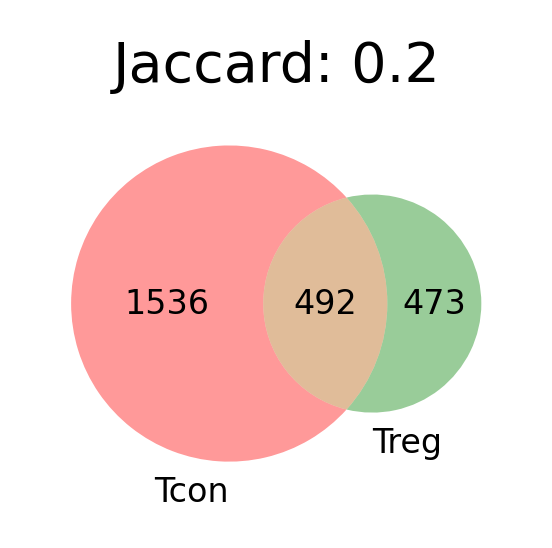

(14482, 5)


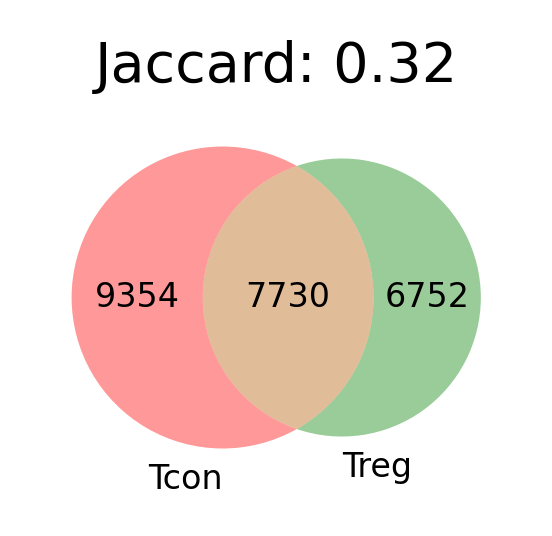

In [309]:
from supp_figures_plotting_functions import generate_metadomain_venn_diagrams

generate_metadomain_venn_diagrams(deseq_pval_mat, all_intra_treg_metadomains, all_intra_tcon_metadomains)

### Figure S8

A-B. Chromosome heatmap clustering

/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:190: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:193: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordering = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, matrix)


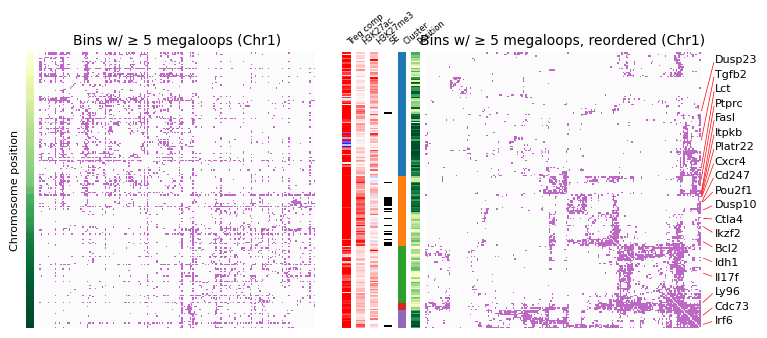

In [398]:
from supp_figures_plotting_functions import generate_chromosome_heatmap
logging.getLogger().setLevel(logging.CRITICAL)
intra_clustering = generate_chromosome_heatmap('1', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50,
                                              n_clusters=5)

10


/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:176: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:176: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)


10


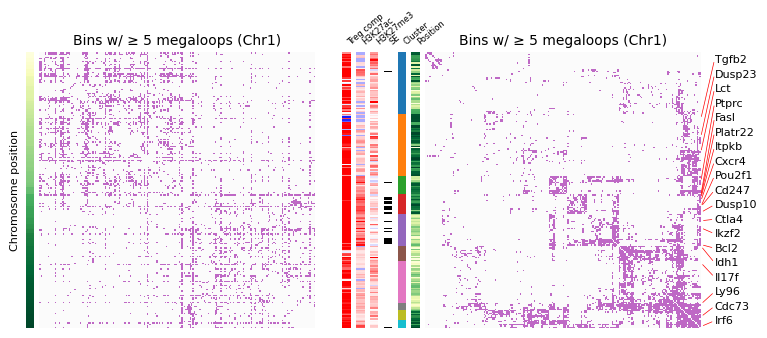

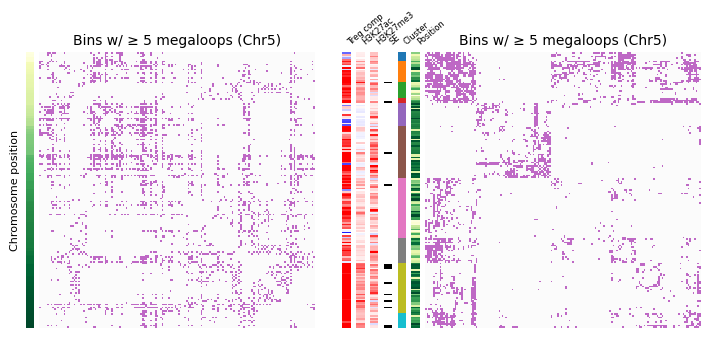

In [274]:
!mkdir -p plots/paper/s12

generate_chromosome_heatmap('5', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50)

/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:176: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)


10


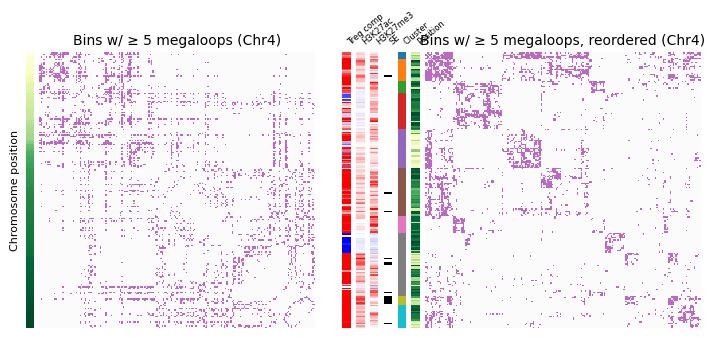

In [313]:
from supp_figures_plotting_functions import generate_chromosome_heatmap

generate_chromosome_heatmap('4', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50)


/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:176: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)


10


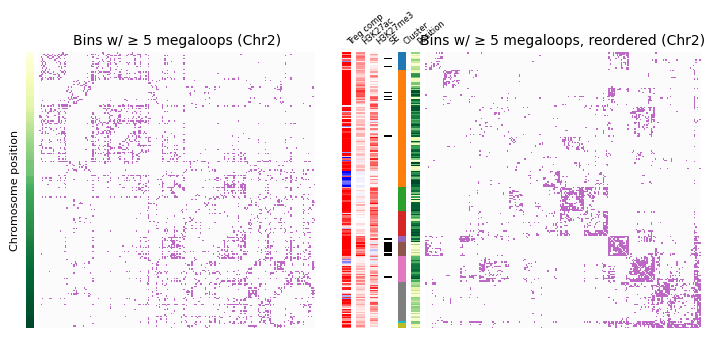

In [314]:
from supp_figures_plotting_functions import generate_chromosome_heatmap

generate_chromosome_heatmap('2', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50)


### Figure S9


[0.0, 5000000.0, 10000000.0, 15000000.0, 20000000.0, 25000000.0, 16625000.0] ['0 Mb', '5 Mb', '10 Mb', '15 Mb', '20 Mb', '25 Mb', 'Ly96']


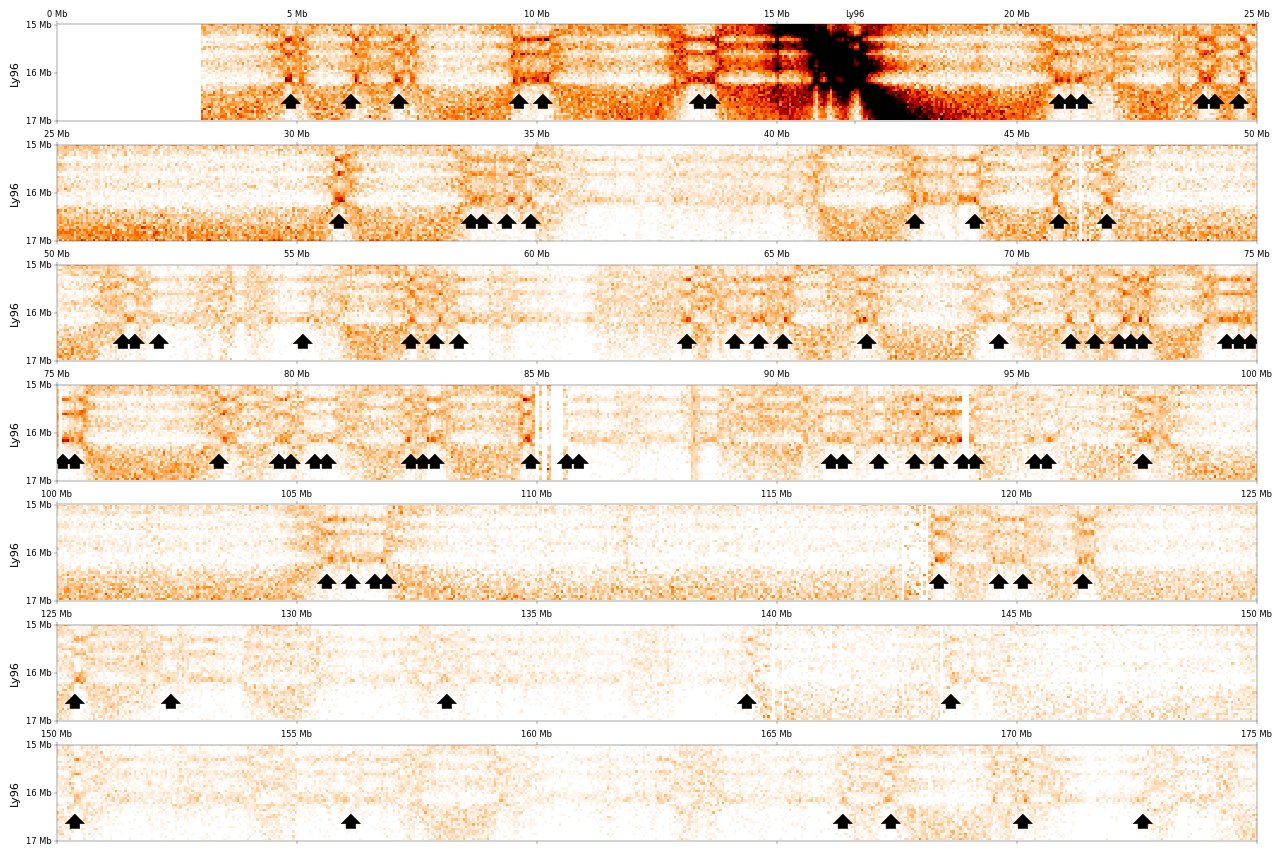

In [336]:
!mkdir -p ./plots/paper/s13
from supp_figures_plotting_functions import make_wrapped_plot

fig = make_wrapped_plot(inter_and_intra_metadomains, treg_50kb, all_ind_to_region, chrom_to_start, 
                      chrom_to_end, og_ind=66, compare_with = '1', dpi = 50, gene='Ly96')
fig.savefig('./plots/paper/s13/ly96_chr1_wrapped_plot.pdf', bbox_inches='tight')

[50000000.0, 55000000.0, 60000000.0, 65000000.0, 70000000.0, 75000000.0, 69625000.0] ['50 Mb', '55 Mb', '60 Mb', '65 Mb', '70 Mb', '75 Mb', 'Ikzf2']


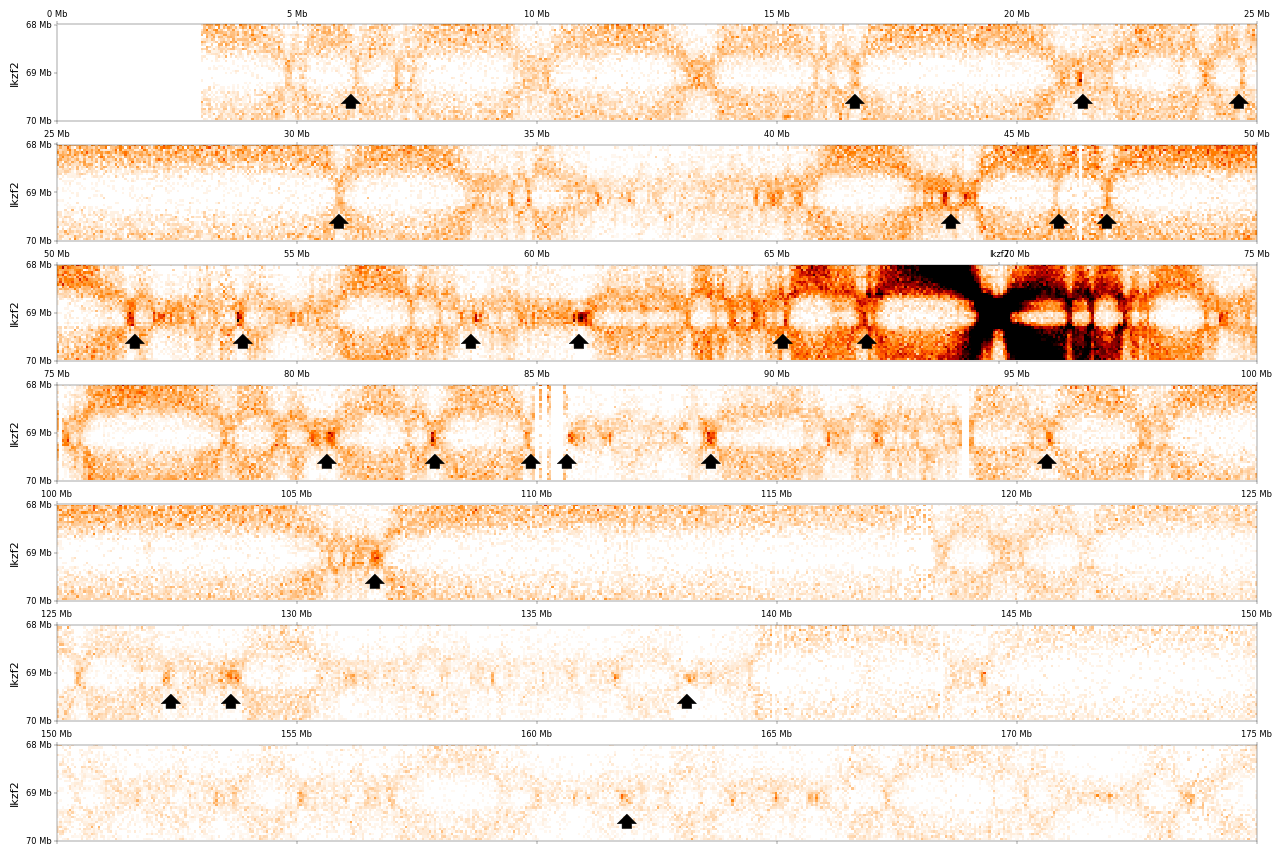

In [337]:
fig = make_wrapped_plot(inter_and_intra_metadomains, treg_50kb, all_ind_to_region, chrom_to_start, 
                      chrom_to_end, og_ind=278, compare_with = '1', dpi = 50, gene='Ikzf2')
fig.savefig('./plots/paper/s13/ikzf2_chr1_wrapped_plot.pdf', bbox_inches='tight')

### Figure S10

A. Hi-C plots shown in Final_Plot Metadomains

B. Pileup shown in Pileup_Intra metadomains

C. 

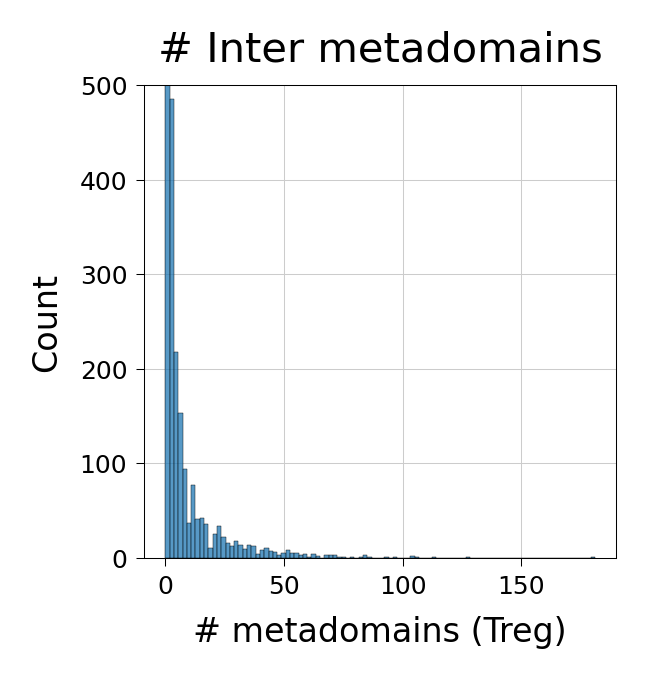

In [348]:
from supp_figures_plotting_functions import inter_metadomain_barplot

inter_metadomain_barplot(all_inter_treg_metadomains);

D-E.

Imported plotting functions


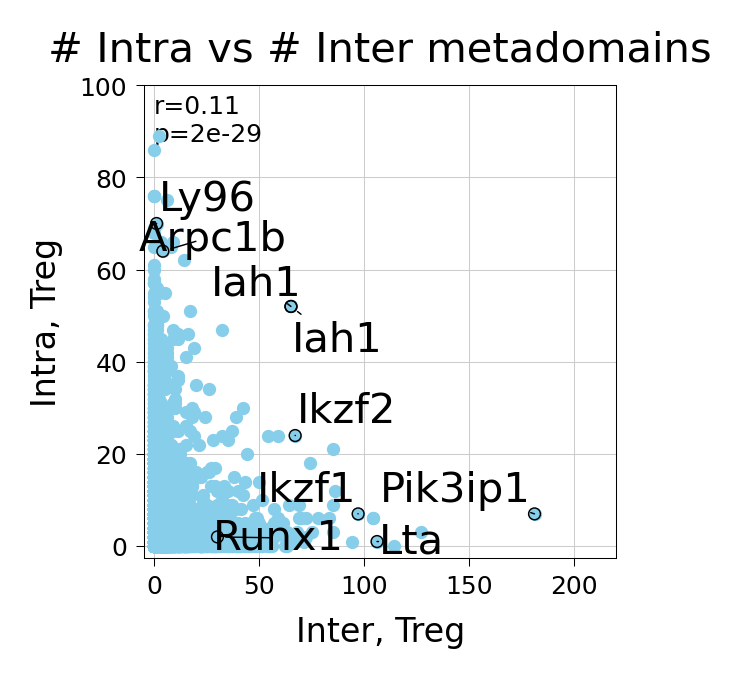

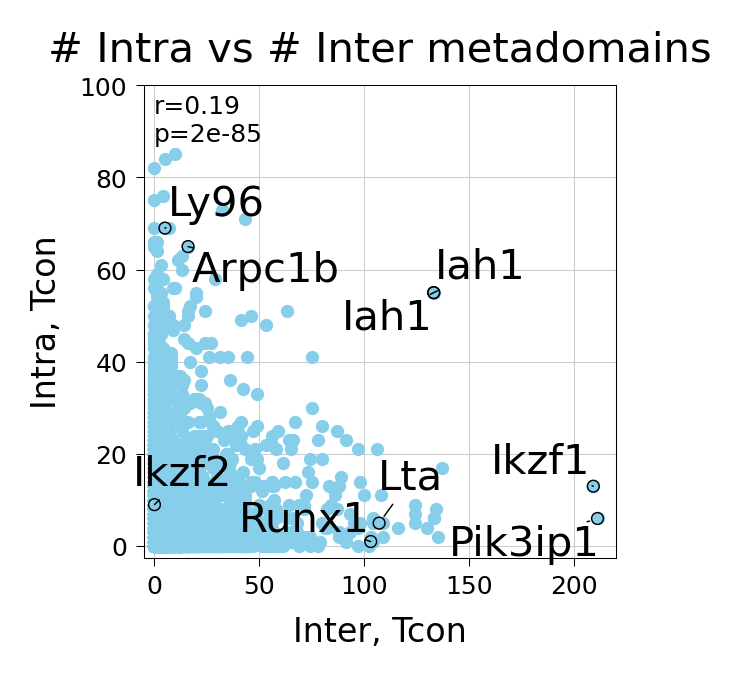

In [328]:
from supp_figures_plotting_functions import inter_intra_metadomains

fig = inter_intra_metadomains(all_inter_treg_metadomains, all_intra_treg_metadomains, ind_to_gene, celltype='Treg')
fig.savefig('./plots/paper/s14/number_treg_intra_inter_metadomains.pdf', bbox_inches = 'tight', dpi=1000)

fig = inter_intra_metadomains(all_inter_tcon_metadomains, all_intra_tcon_metadomains, ind_to_gene, celltype='Tcon')
fig.savefig('./plots/paper/s14/number_tcon_intra_inter_metadomains.pdf', bbox_inches = 'tight', dpi=1000)

F.

Imported plotting functions


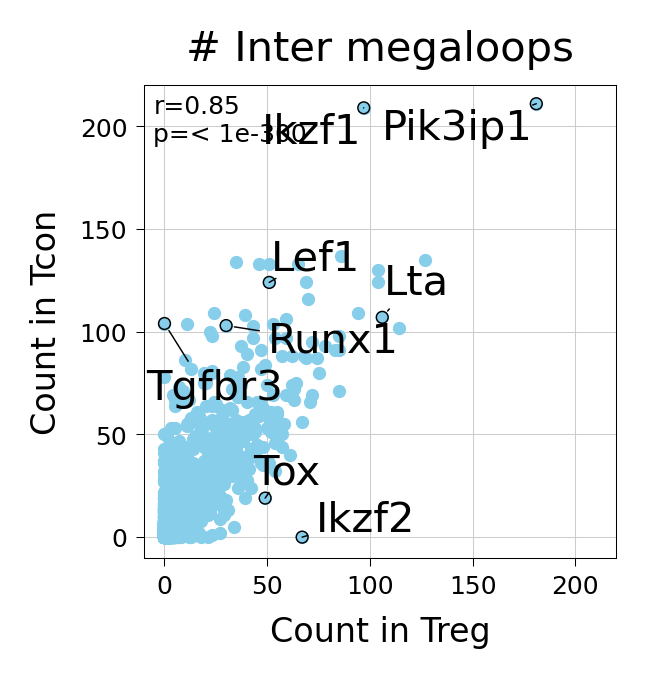

In [370]:
from supp_figures_plotting_functions import treg_tcon_inter_metadomains

fig = treg_tcon_inter_metadomains(all_inter_treg_metadomains, all_inter_tcon_metadomains, ind_to_gene)
fig.savefig('./plots/paper/s14/treg_tcon_inter_metadomains.pdf', bbox_inches = 'tight',
           dpi=1000)

G. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1231: RuntimeWarning: invalid value encountered in divide
  x, y = np.ravel(np.log2(1+bw_val_df_all_250kb[key])), delta


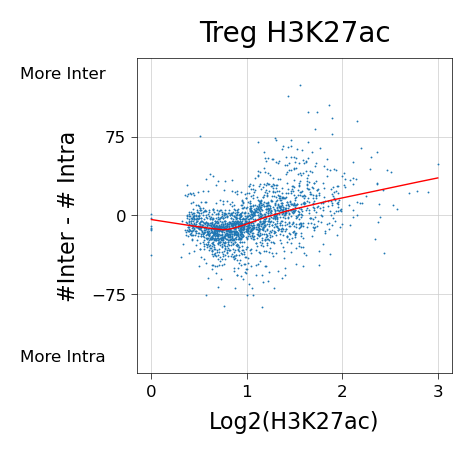

In [380]:
from supp_figures_plotting_functions import inter_vs_intra_h3k27ac_scatterplot

fig = inter_vs_intra_h3k27ac_scatterplot(all_intra_treg_metadomains, all_inter_treg_metadomains, 
                                   all_intra_metadomains, all_inter_metadomains, bw_val_df_all_250kb)
fig.savefig('./plots/paper/s15/inter_vs_intra_h3k27ac_scatter.pdf', bbox_inches = 'tight', dpi = 300)

H. 

Imported plotting functions


/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1197: RuntimeWarning: invalid value encountered in divide
  x, y = np.ravel(np.log2(1+bw_val_df_all_250kb[key])), all_intra_treg_megaloops.sum(axis=1)/all_mega


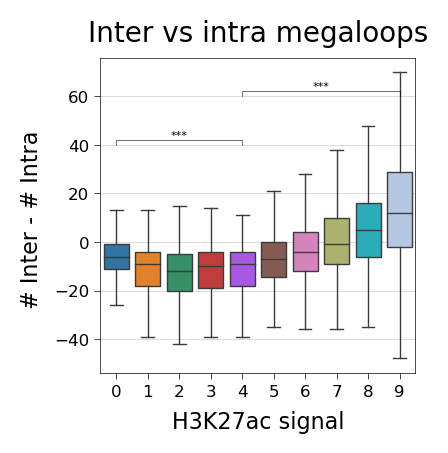

In [379]:
from supp_figures_plotting_functions import inter_vs_intra_h3k27ac_boxplot

fig = inter_vs_intra_h3k27ac_boxplot(all_intra_treg_metadomains, all_inter_treg_metadomains, 
                                   all_intra_metadomains, all_inter_metadomains, bw_val_df_all_250kb)
fig.savefig('./plots/paper/s15/inter_vs_intra_h3k27ac_box.pdf', bbox_inches = 'tight', dpi = 300)

I. 

Imported plotting functions


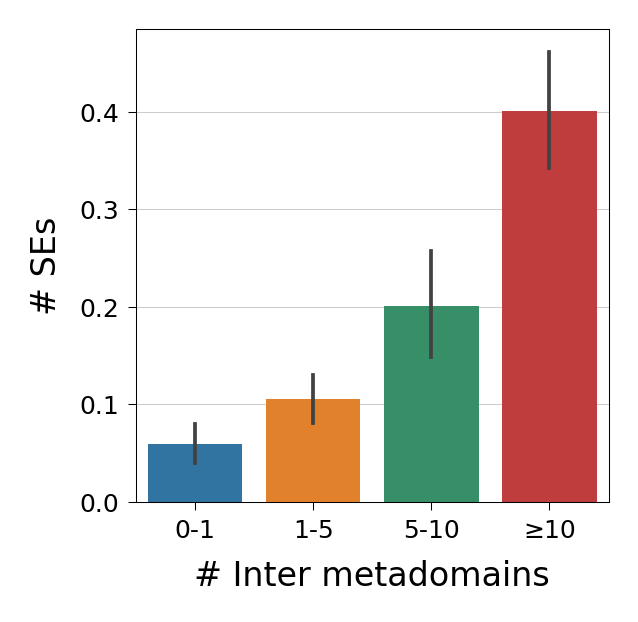

In [636]:
from supp_figures_plotting_functions import inter_metadomains_vs_SE

fig = inter_metadomains_vs_SE(all_inter_treg_metadomains, SE_count)
fig.savefig('./plots/paper/s14/treg_inter_metadomains_vs_SE.pdf', bbox_inches = 'tight',
           dpi=1000)

### Figure S11

In [ ]:
gene_names = ['Ly96', 'Ctla4', 'Ikzf2', 'Ets1', 'Pdlim7']
for c, i in enumerate([66, 243, 278, 5216, 7299]):
    name = gene_names[c]
    fig = make_wrapped_plot(inter_and_intra_metadomains, treg_50kb, all_ind_to_region, chrom_to_start, 
                            chrom_to_end, og_ind=i, compare_with = '3', dpi = 50, ylabel=name,
                            intra=False, gene=name)
    fig.savefig(f'./plots/paper/s16/{name}_chr1_wrapped_plot.pdf', bbox_inches='tight')

### Figure S12

Plot made in "plot_metadomains" folder

### Figure S13

A. Inter vs. Intra metadomains

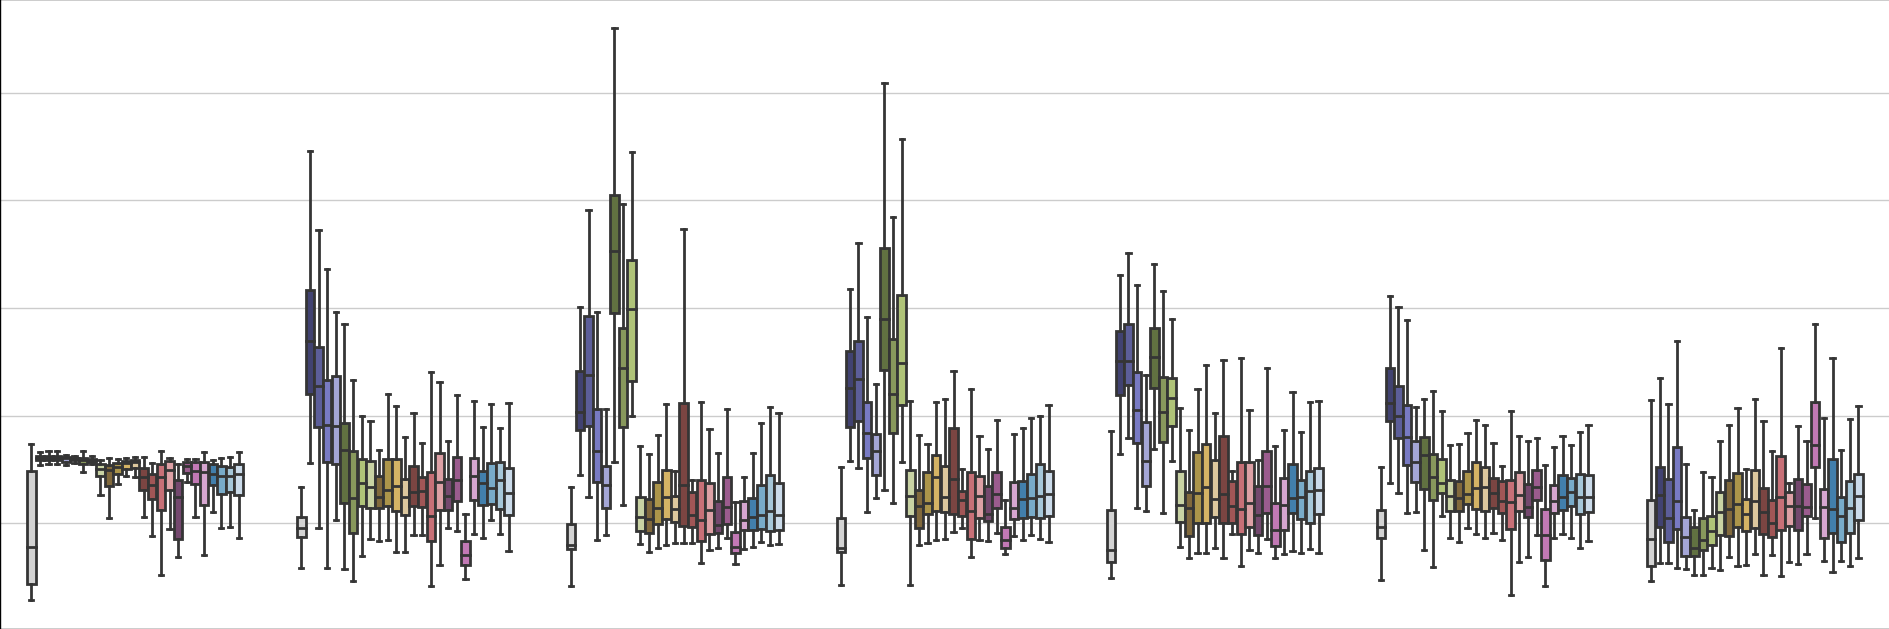

In [319]:
from supp_figures_plotting_functions import plot_inter_metadomain_clustering_chip

fig = plot_inter_metadomain_clustering_chip(bw_val_df_all_250kb, self, my_treg_comp)
fig.savefig('./plots/paper/s15/INTER_CHIP.pdf', bbox_inches='tight')

B-C. 

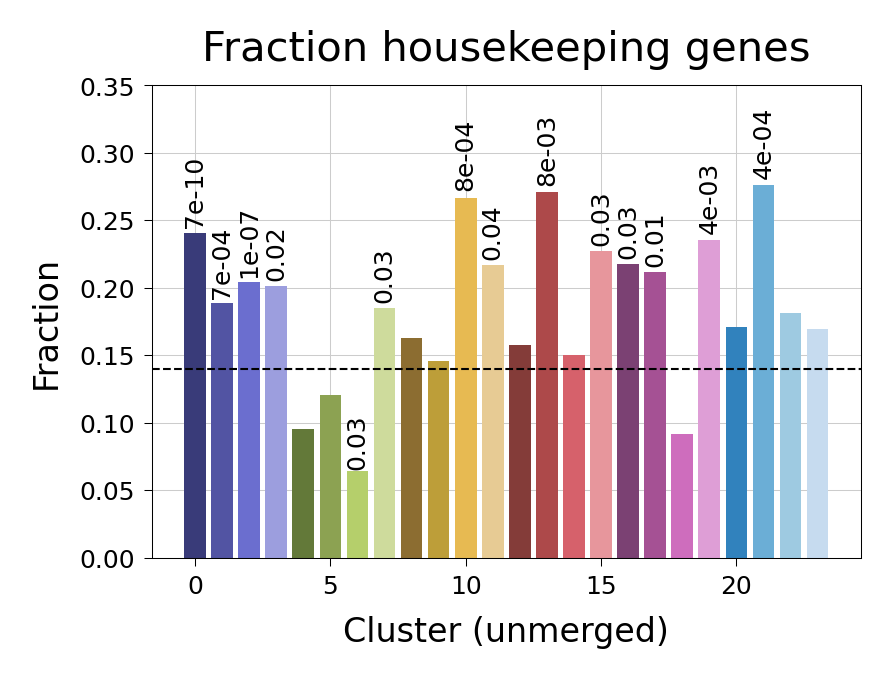

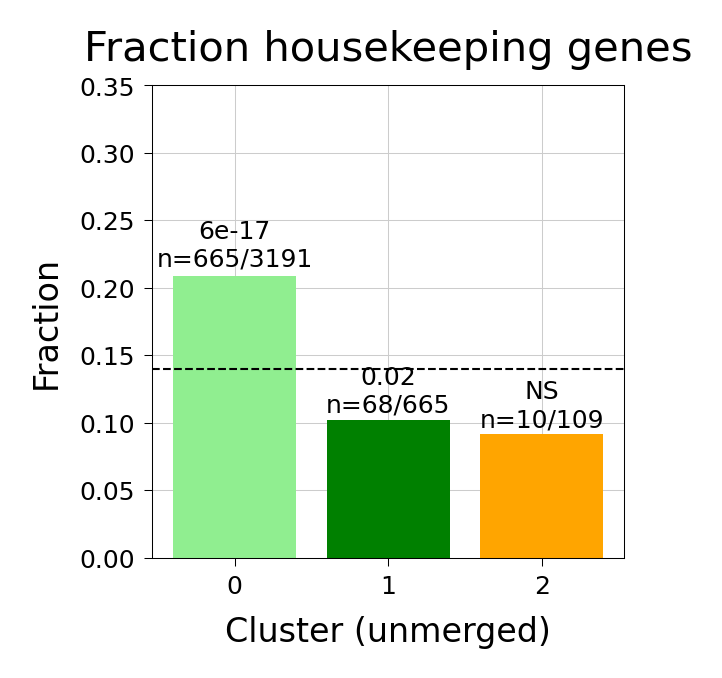

In [751]:
from supp_figures_plotting_functions import housekeeping_barplots

housekeeping_barplots(self, gene_to_ind, ind_to_gene, row_colors)

D. 

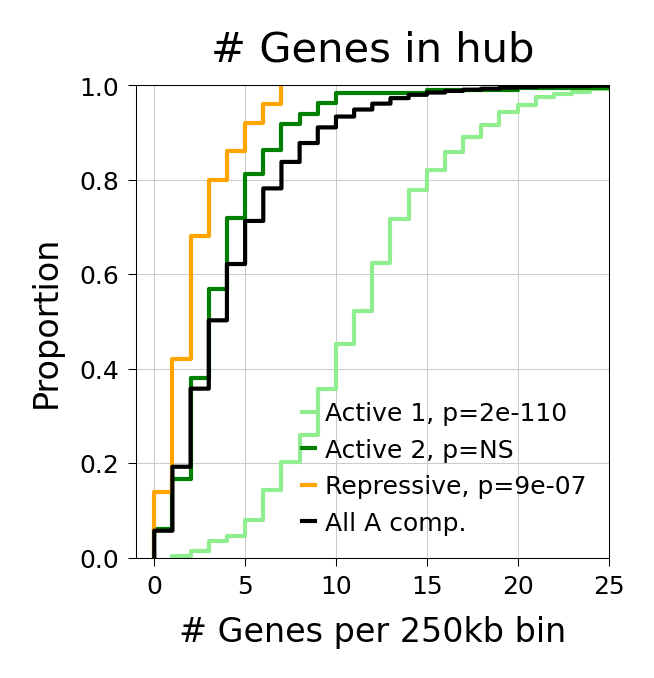

In [775]:
from supp_figures_plotting_functions import n_genes_per_hub

fig = n_genes_per_hub(self, ind_to_gene, columns_to_names, row_colors_dict, my_treg_comp)
fig.savefig('./plots/paper/s15/genes_in_hub.pdf', bbox_inches='tight')

E

Imported plotting functions


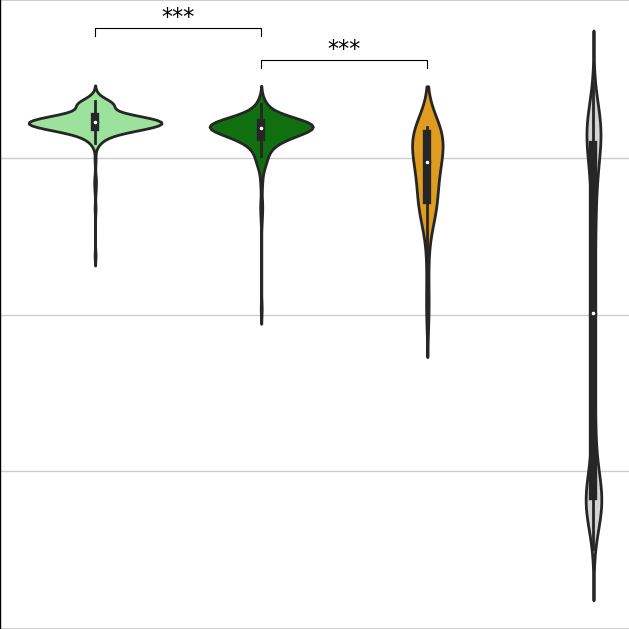

In [2089]:
from supp_figures_plotting_functions import treg_comp_violin_plot

treg_comp_violin_plot(my_treg_comp, self, columns_to_names)

F.

Imported plotting functions


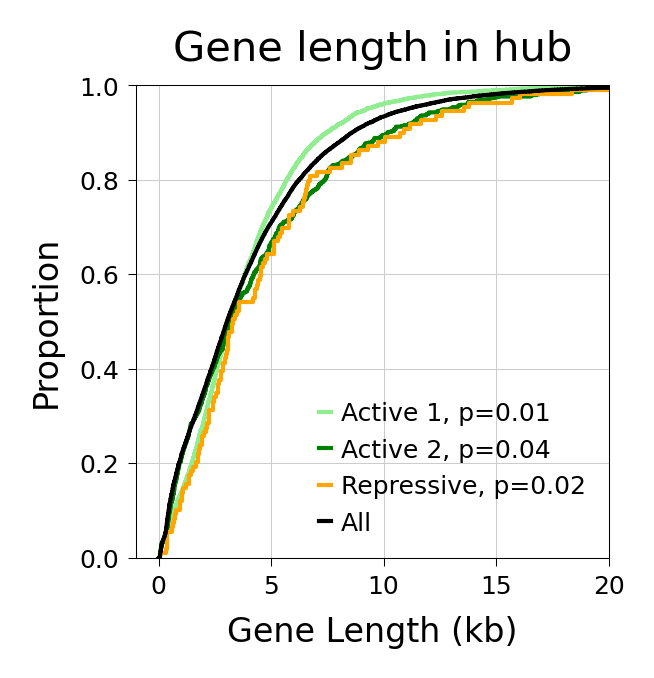

In [774]:
from supp_figures_plotting_functions import gene_length_per_hub

fig = gene_length_per_hub(self, gene_to_ind, ind_to_gene, columns_to_names, row_colors_dict, geneLengths)
fig.savefig('./plots/paper/s15/gene_length_in_hub.pdf', bbox_inches='tight')

G

Imported plotting functions


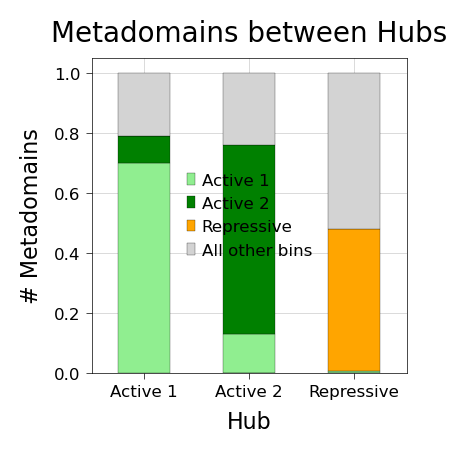

In [588]:
from supp_figures_plotting_functions import metadomain_between_hub_barplot

fig = metadomain_between_hub_barplot(all_inter_metadomains, self, columns_to_names,
                                row_colors, dpi = 100)
fig.savefig(f'./plots/paper/s15/F_metadomain_hubs.pdf', bbox_inches='tight')

H.

Imported plotting functions
9263
7263
267


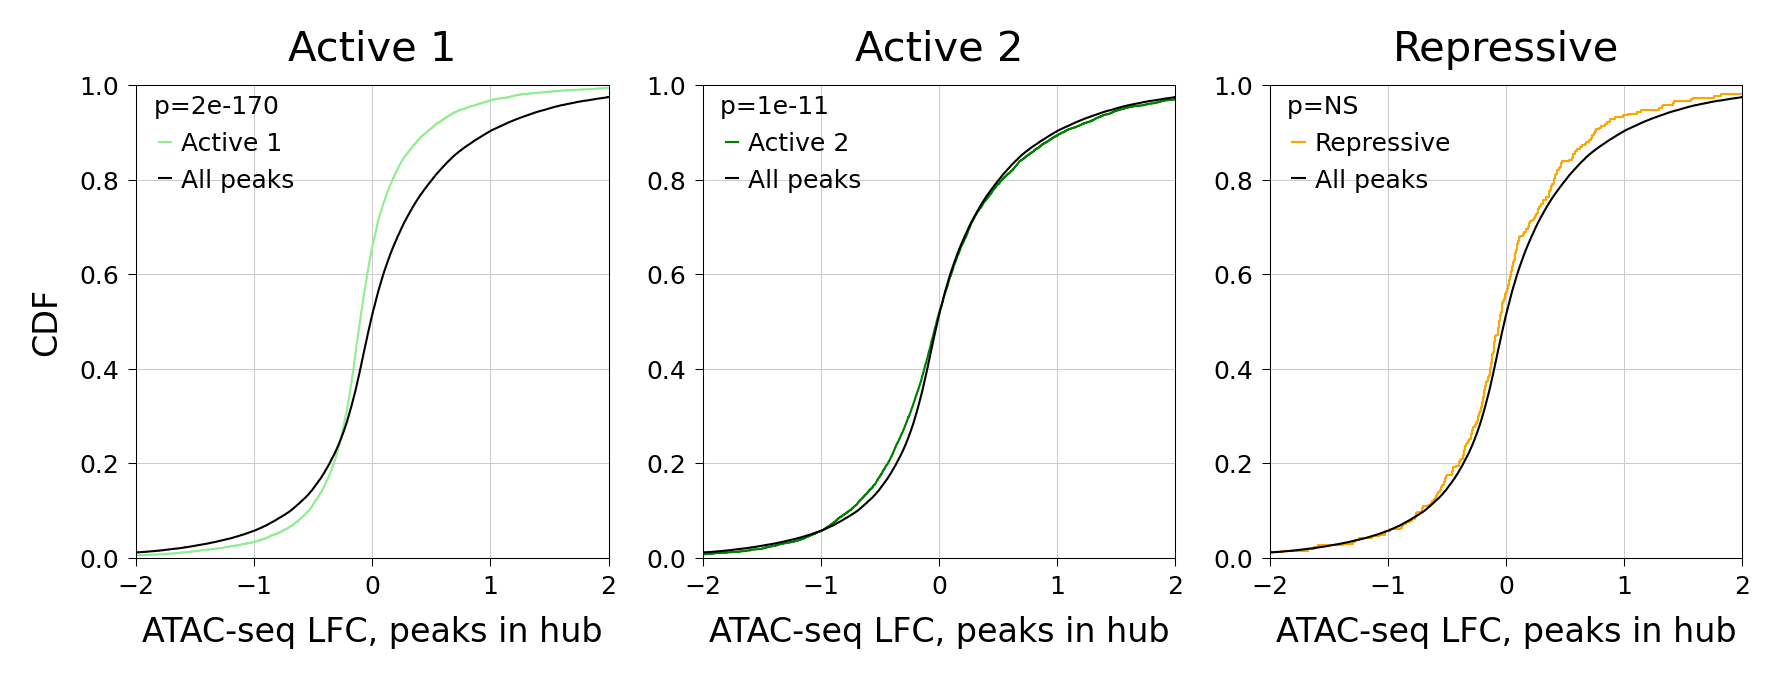

In [329]:
from supp_figures_plotting_functions import make_atac_enrichments_in_hub_quant

make_atac_enrichments_in_hub_quant(atac_peaks,  self, all_ind_to_region, columns_to_names, row_colors_dict)

Imported plotting functions
Active 2 Treg
Active 2 Common


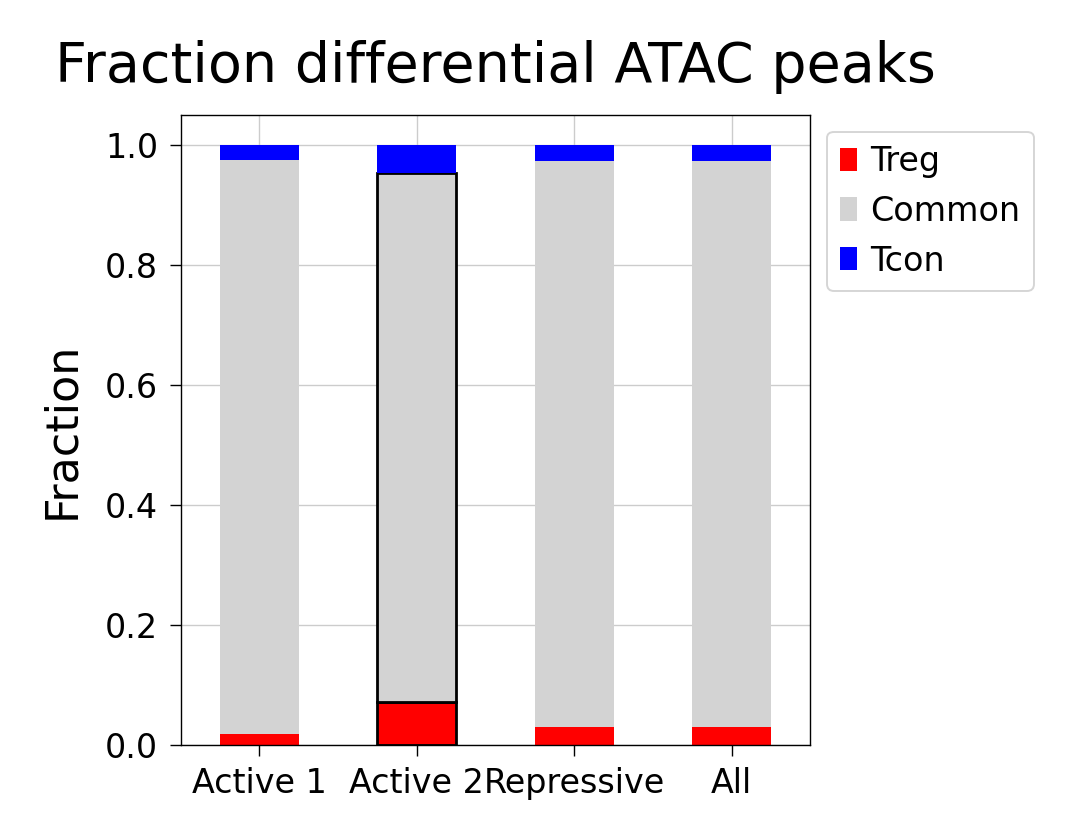

In [759]:
from supp_figures_plotting_functions import make_atac_enrichments_in_hub_with_pvals

data = make_atac_enrichments_in_hub_with_pvals(self, all_ind_to_region, columns_to_names)

I. mESC Pileups in "Pileups_mESC pileups"

#### Figure S14

A. GO terms

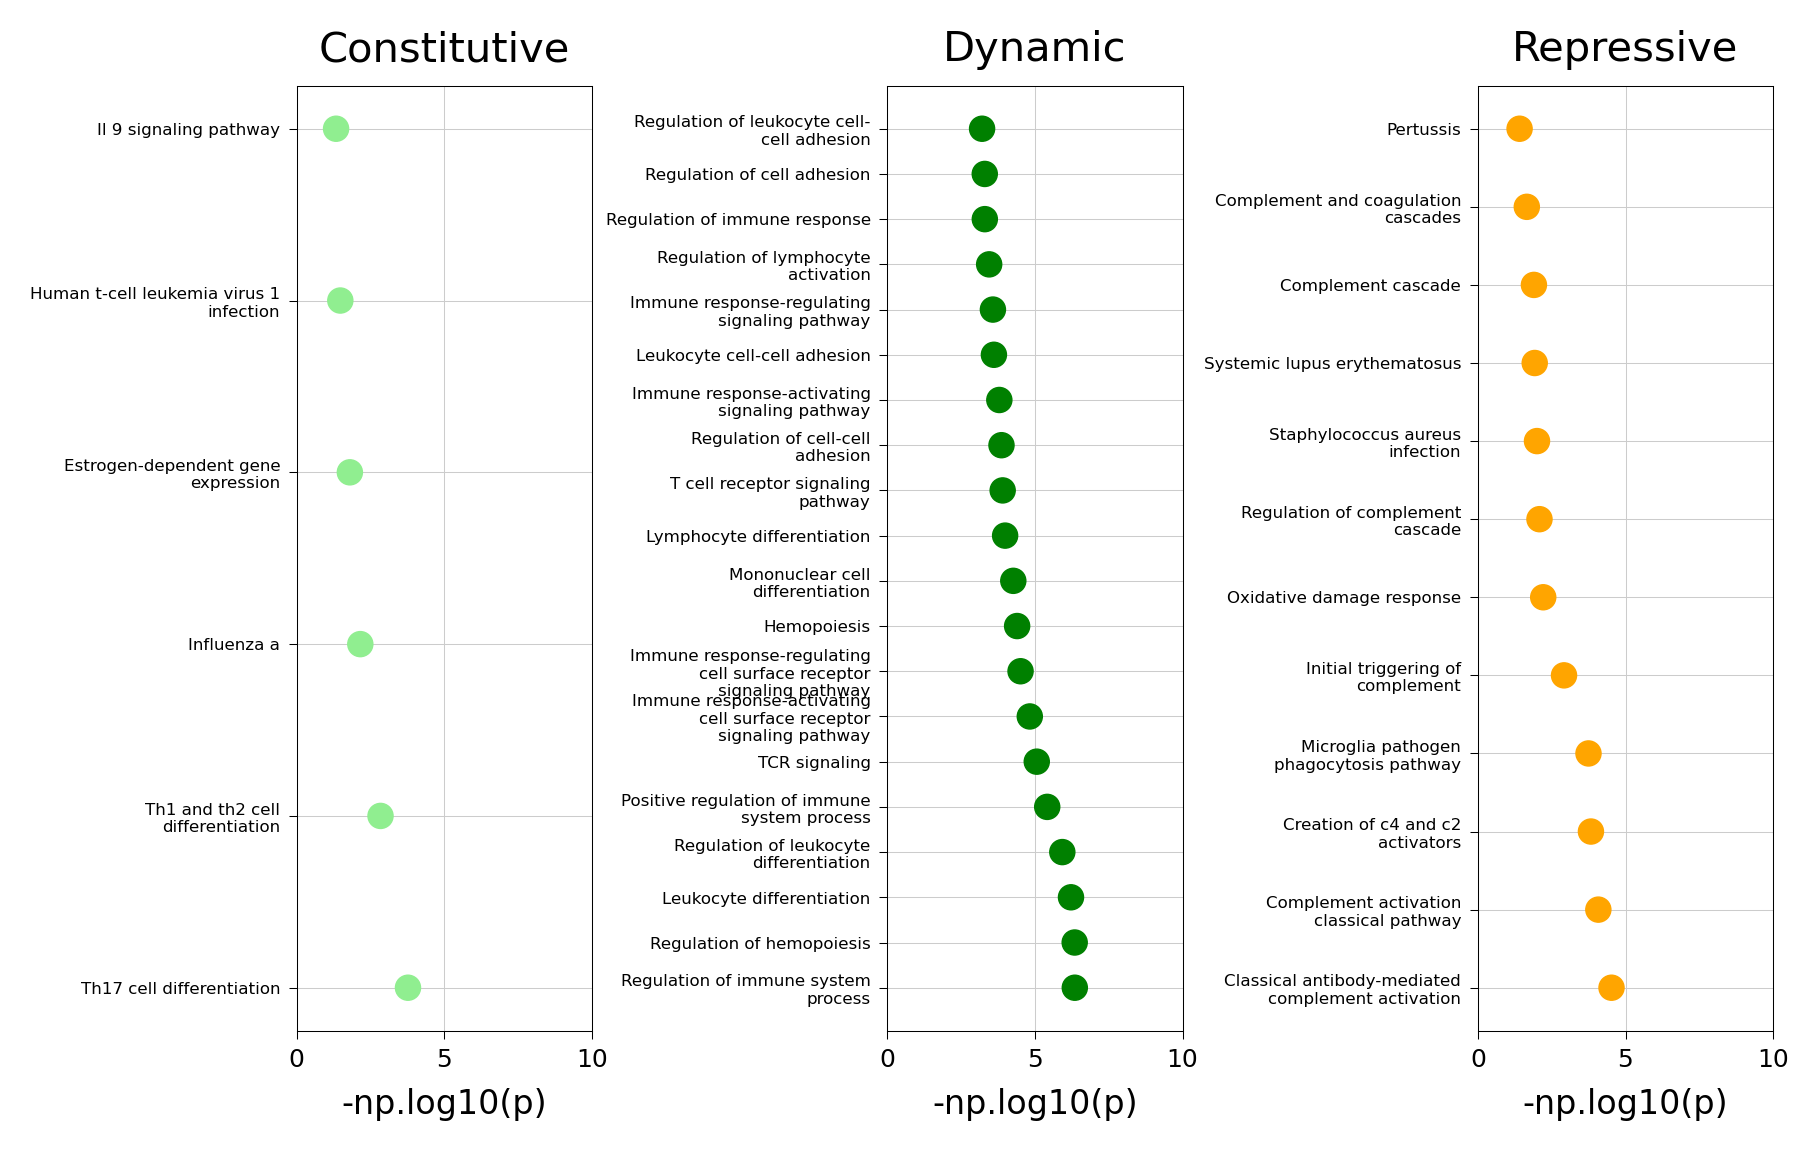

In [351]:
from supp_figures_plotting_functions import make_go_enrichment_plot

r = make_go_enrichment_plot(my_tss_df, columns_to_names, row_colors_dict, control_key='Other genes')

B. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1978: RuntimeWarning: divide by zero encountered in log2
  vals.append([col, p, delta])


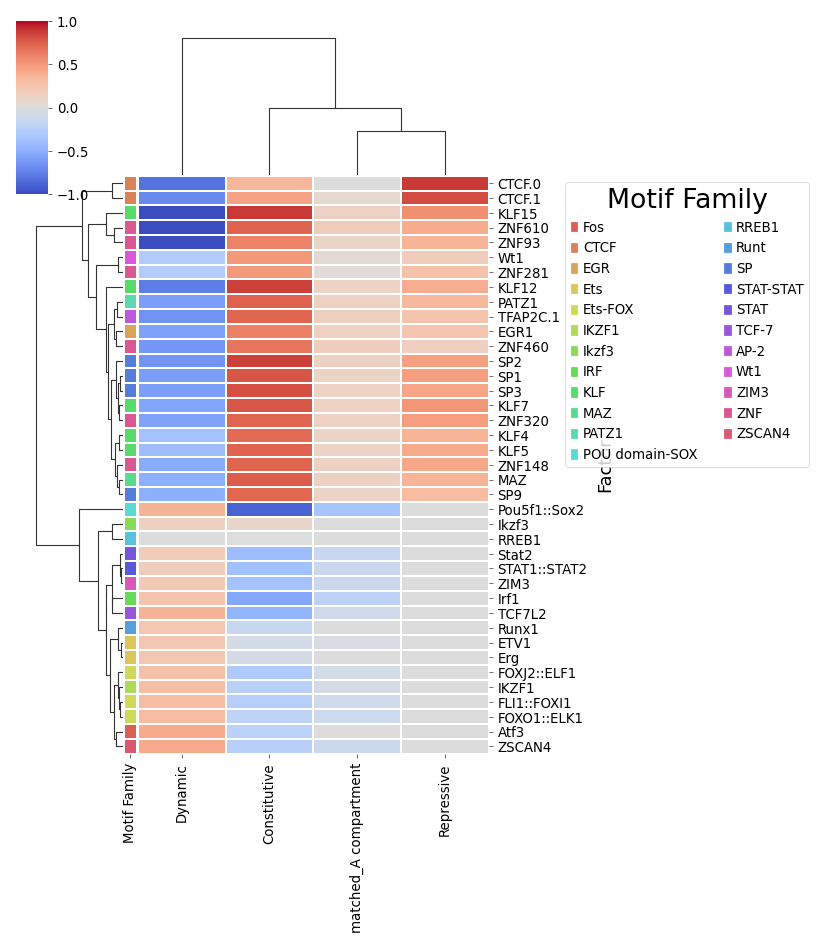

In [507]:
from supp_figures_plotting_functions import make_motif_enrichment_plot

results = make_motif_enrichment_plot(self, _250kb_hub_annotations, all_ind_to_region, meme_motif_df, motif_metadata, columns_to_names)

C. Pileup shown in Pileup_JesseYe

#### Figure S15

A.

Imported plotting functions


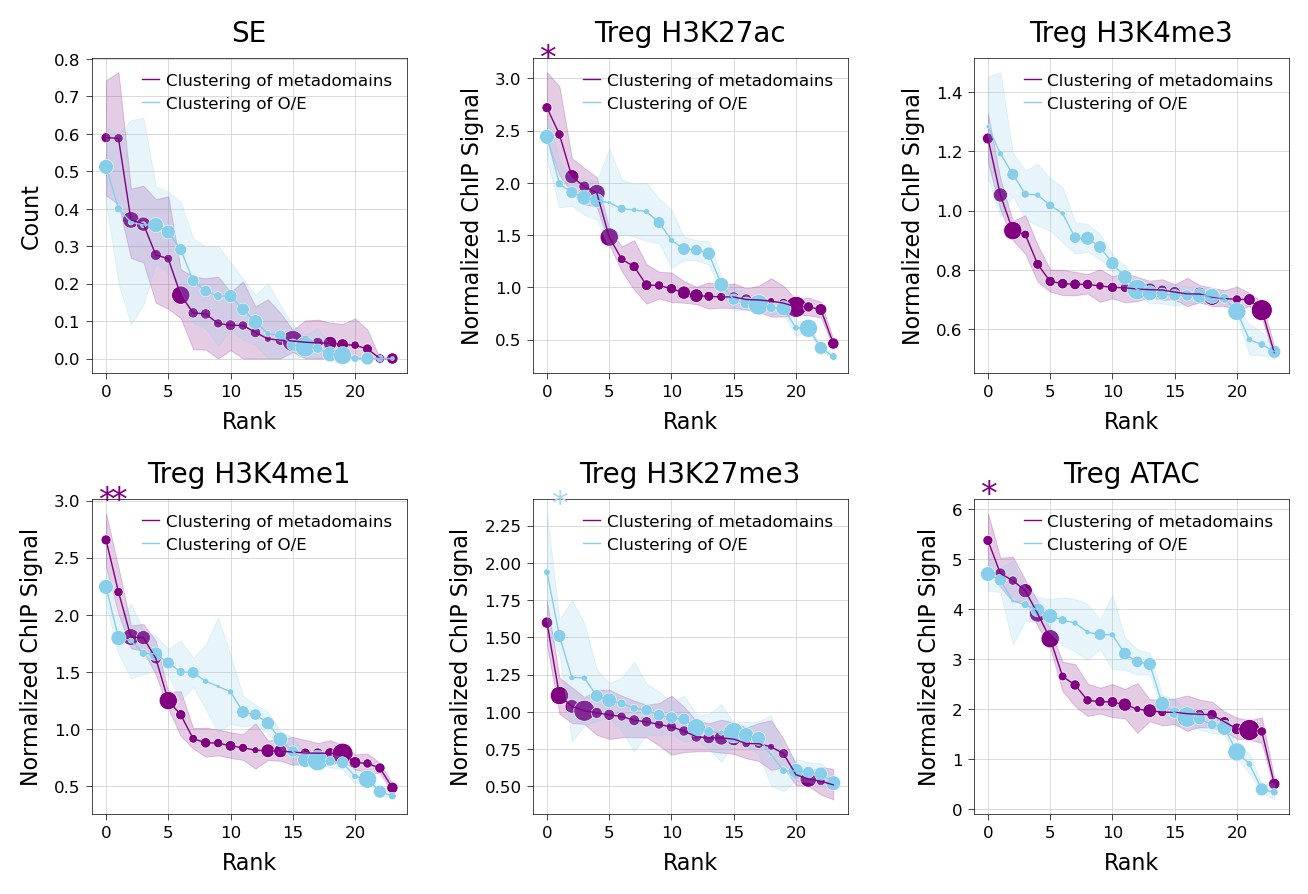

In [349]:
from supp_figures_plotting_functions import metadomain_vs_random_bin_clustering

treal_overlap, trand_overlap = metadomain_vs_random_bin_clustering(self, sep_oe_mat_treg, 
                                         sep_oe_mat_tcon, bw_val_df_all_250kb,
                                         my_treg_comp, {'common_SE': SE_common_count},
                                         all_ind_to_region, method='same'
                                    )

B.

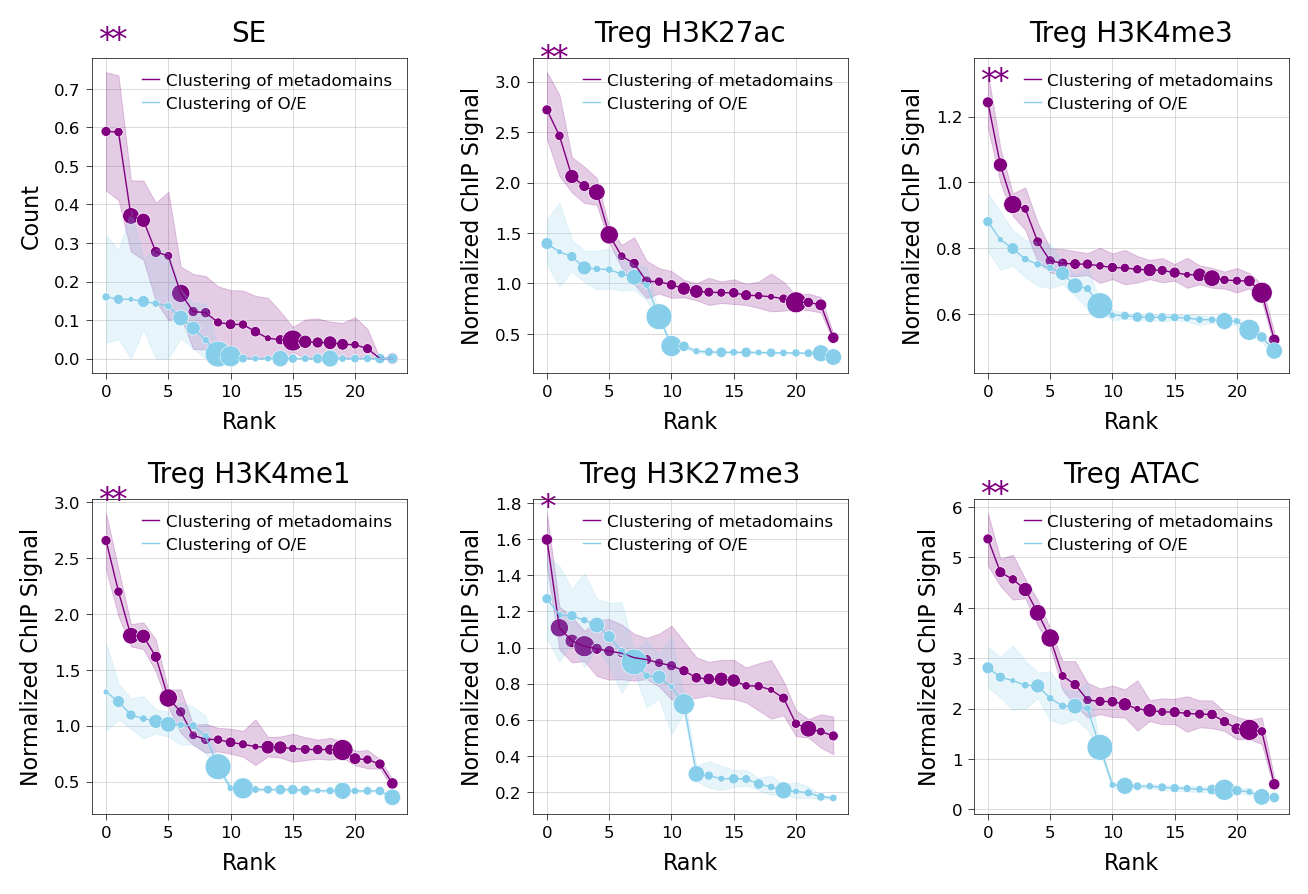

In [348]:
from supp_figures_plotting_functions import metadomain_vs_random_bin_clustering

treal_overlap, trand_overlap = metadomain_vs_random_bin_clustering(self, sep_oe_mat_treg, 
                                         sep_oe_mat_tcon, bw_val_df_all_250kb,
                                         my_treg_comp, {'common_SE': SE_common_count},
                                         all_ind_to_region, method='random'
                                    )

C.

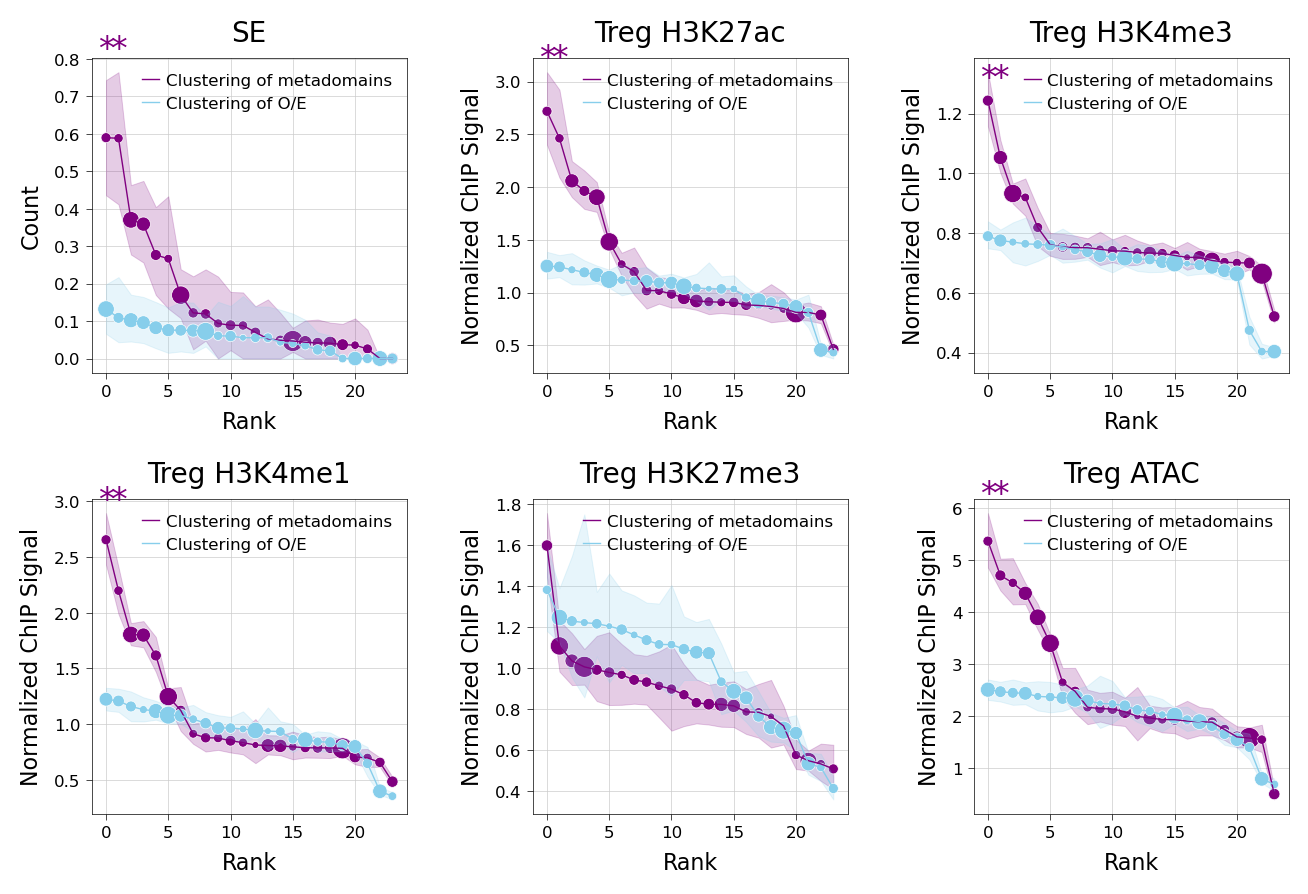

In [347]:
from supp_figures_plotting_functions import metadomain_vs_random_bin_clustering

treal_no_overlap, trand_no_overlap = metadomain_vs_random_bin_clustering(self, sep_oe_mat_treg, 
                                         sep_oe_mat_tcon, bw_val_df_all_250kb,
                                         my_treg_comp, {'common_SE': SE_common_count},
                                         all_ind_to_region, method='acomp_no_overlap'
                                    )

D. 

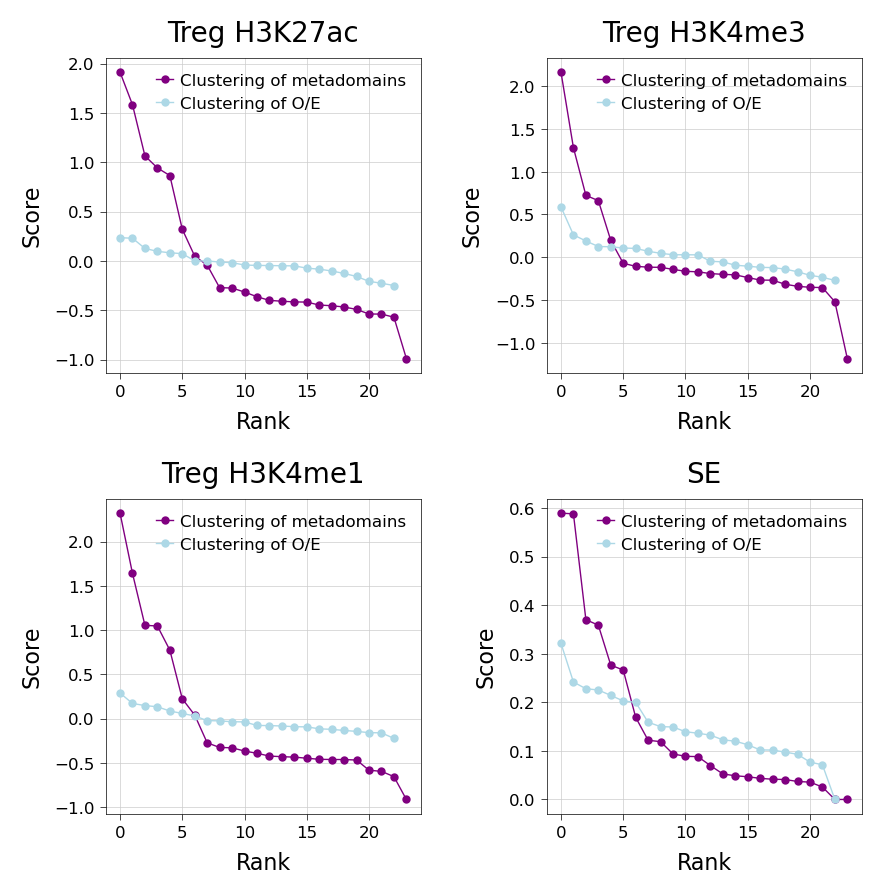

In [413]:
from supp_figures_plotting_functions import metadomain_vs_random_clustering

metadomain_vs_random_clustering(self, sep_oe_mat_treg, bw_val_df_all_250kb)

#### Figure S16

A.

RanksumsResult(statistic=33.64082729130243, pvalue=4.2463474172948514e-248)
RanksumsResult(statistic=42.88250958643466, pvalue=0.0)
RanksumsResult(statistic=0.4987166836162656, pvalue=0.6179789895781642)


/tmp/ipykernel_1327126/1321383642.py:4: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('./plots/paper/s22/scrna_correlation_baseline.pdf', bbox_inches='tight', dpi=200)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


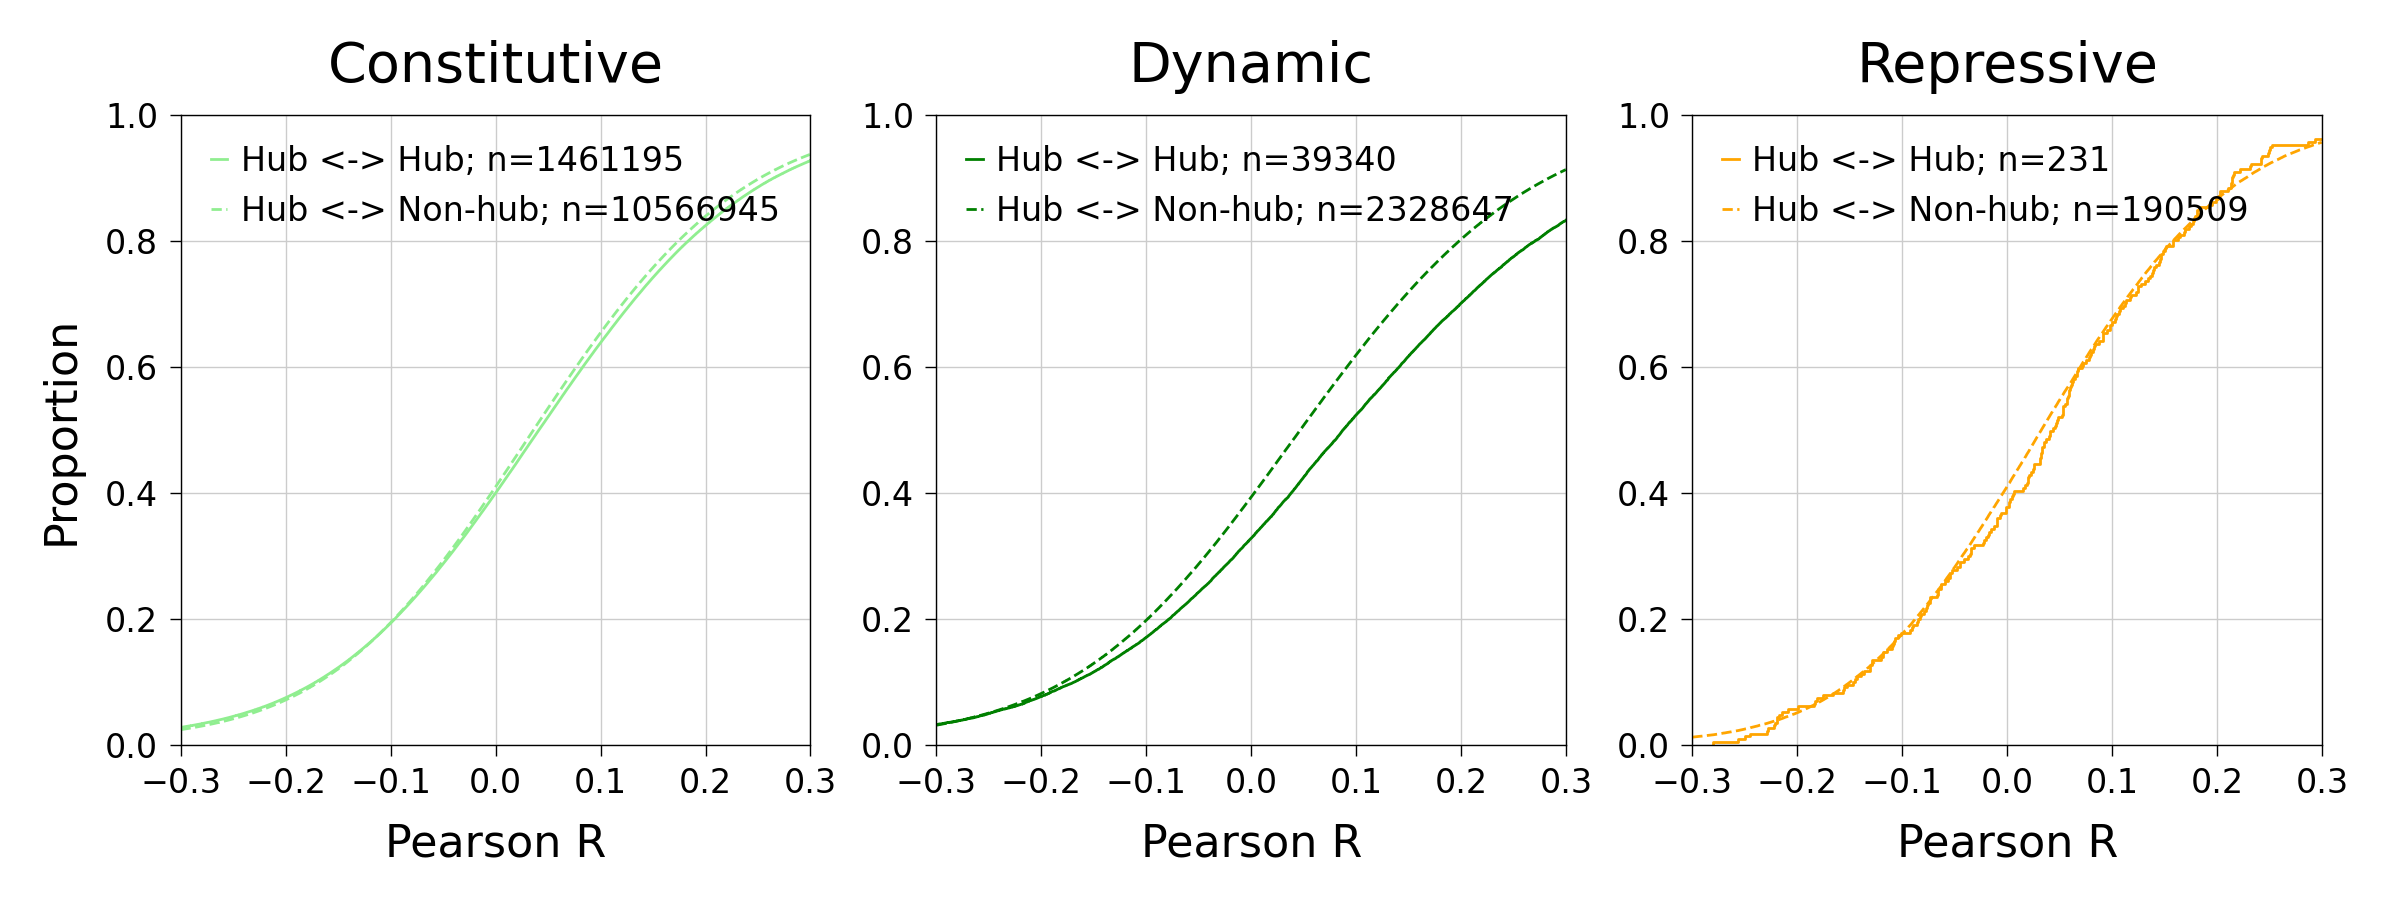

In [685]:
from supp_figures_plotting_functions import baseline_scrna_correlation

fig = baseline_scrna_correlation(gene_dict, ind_to_gene, self, tregs_rna_corr, row_colors_dict, columns_to_names)
fig.savefig('./plots/paper/s22/scrna_correlation_baseline.pdf', bbox_inches='tight', dpi=200)

B.

2024-09-10 22:40:54 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-09-10 22:40:54 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


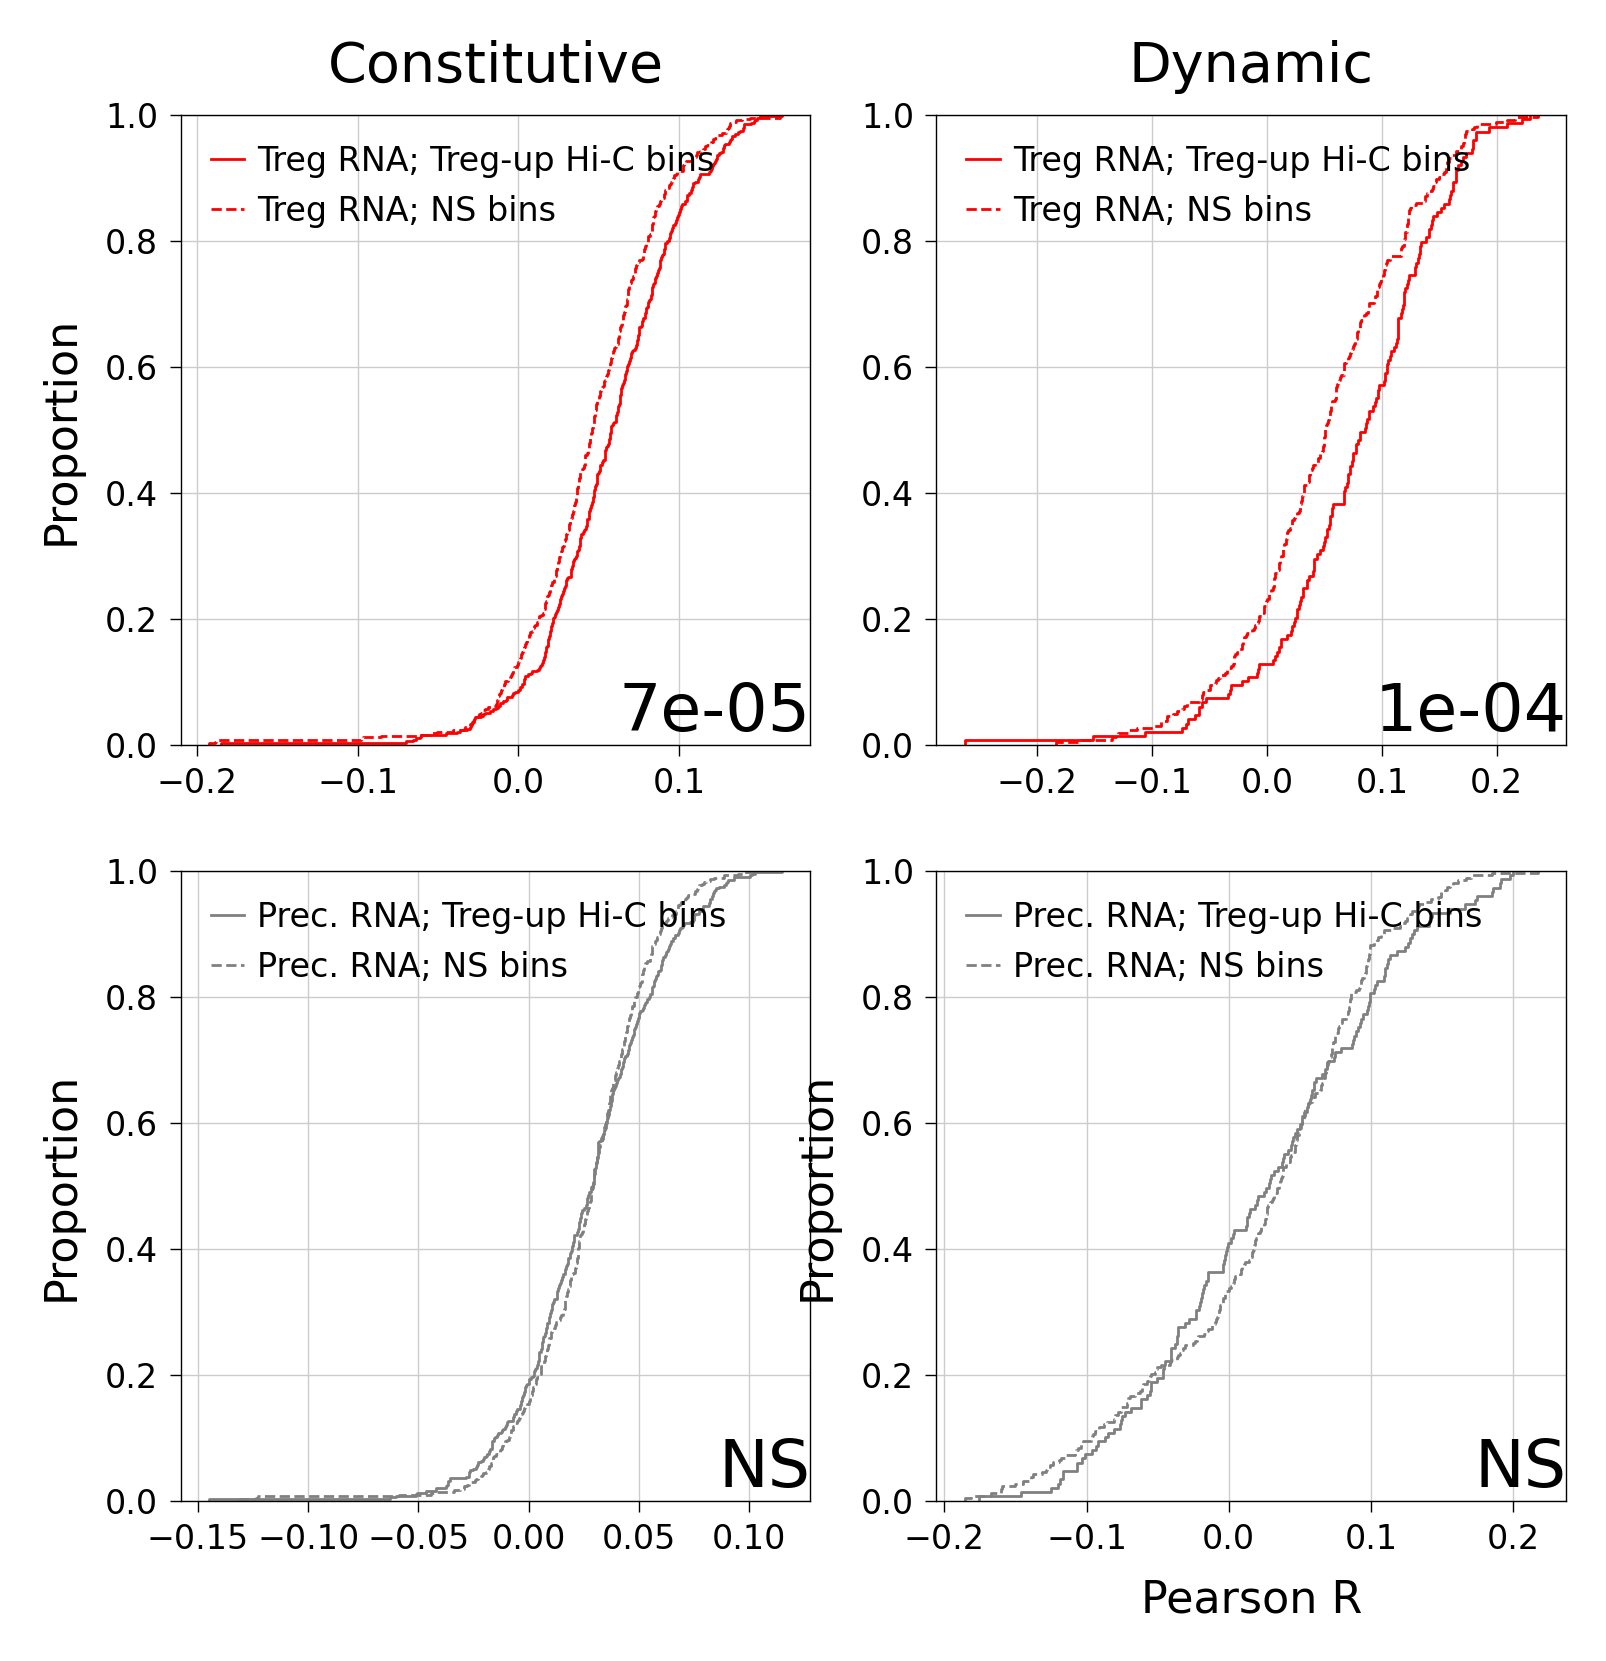

In [353]:
from supp_figures_plotting_functions import differential_scrna_correlation

fig = differential_scrna_correlation(gene_dict, ind_to_gene, self, tregs_rna_corr, treg_precursor_rna_corr, 
                                     hub_pileup_pval_df_250kb, hub_pileup_stat_df_250kb, columns_to_names,
                                    HIC_PCO, HIC_STATCO)
fig.savefig('./plots/paper/s22/scrna_treg_precursor_correlation.pdf', bbox_inches='tight', dpi=200)    

C-E. Pileups shown in Pileup_JesseYe, Pileup_Sakaguchi, and Pileup_Active_resting

#### Figure S17

A.

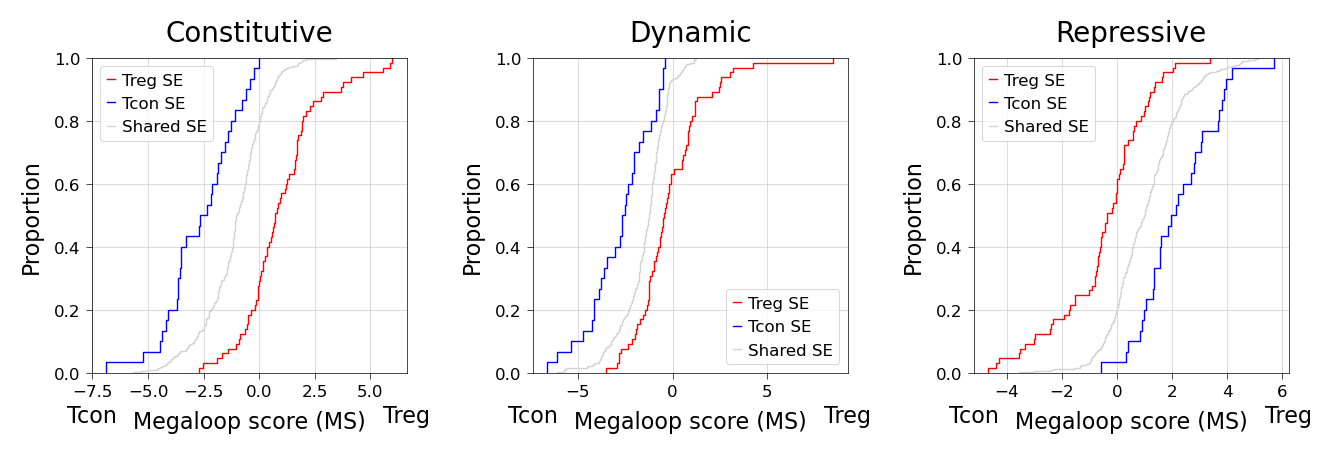

In [79]:
from supp_figures_plotting_functions import superenhancer_metadomain_score_cdf_plot

fig = superenhancer_metadomain_score_cdf_plot(hub_pileup_stat_df_250kb, SE_treg_count, SE_tcon_count, SE_common_count, columns_to_names)
# fig.savefig('./plots/paper/s24/superenhancer_metadomain_plot.pdf', bbox_inches='tight')

B. Pileups shown in Pileup_Individual Bins

C-E. Pileup shown in Pileup_Active_Resting 

#### Figure S18

Shown in plot_coolbox/Final_plot_coolbox notebook.

#### Figure S19

A-C. Shown in "hic_compendium_analysis/Final_Metaloops_Refine" Notebook

D.

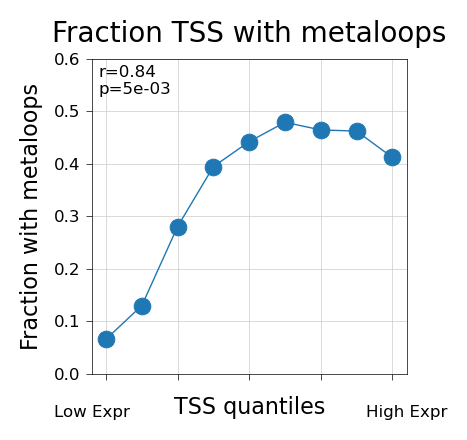

In [579]:
from supp_figures_plotting_functions import fraction_tss_with_metaloops

fraction_tss_with_metaloops(my_tss_df, metaloop_anchors, gene_dict)


E. 

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


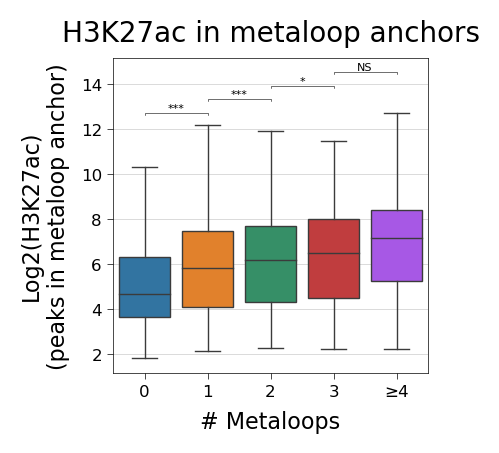

In [580]:
from supp_figures_plotting_functions import metaloop_h3k27ac_boxplot

metaloop_h3k27ac_boxplot(all_h3k27ac, metaloop_anchors)

#### Figure S20

Shown in "hic_compendium_analysis/Final_Metaloops_Refine" Notebook

#### Figure S21

A.

Imported plotting functions
1
21514


/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


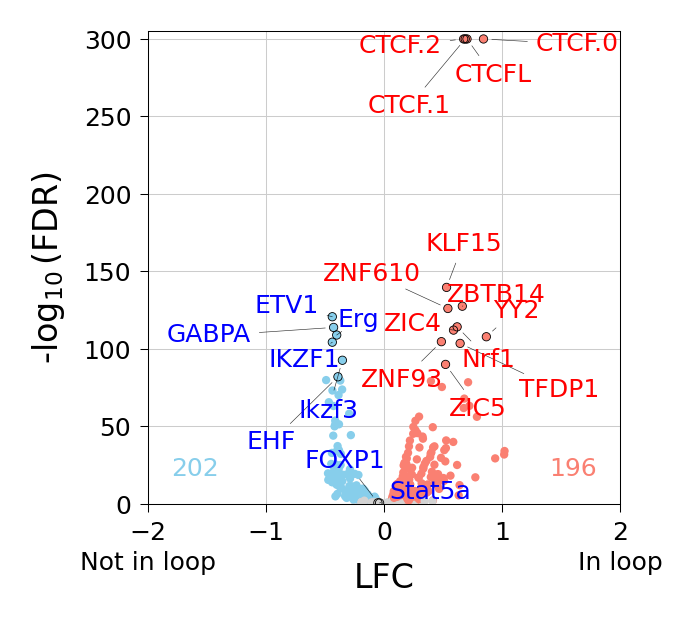

In [472]:
from supp_figures_plotting_functions import loop_vs_nonloop_motif_enrichment

df = loop_vs_nonloop_motif_enrichment(meme_motif_df, add_chr_to_bedtool(anchordict['All']))

B. 

Imported plotting functions


/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


factor     delta          pval
0           ALX3 -0.350998  3.574501e-02
1          ARGFX -0.098863  6.240807e-01
2          ARNT2  0.780044  1.008645e-15
3    ARNT::HIF1A  0.823729  6.929718e-09
4        ASCL1.0  0.014367  8.201147e-01
..           ...       ...           ...
824   Zic1::Zic2 -0.047820  3.004966e-01
825         Zic2 -0.067003  1.333549e-01
826         Zic3  0.037332  3.633962e-01
827       Znf423 -0.157598  1.927358e-02
828        mix-a -0.095658  6.097527e-01

[829 rows x 3 columns]

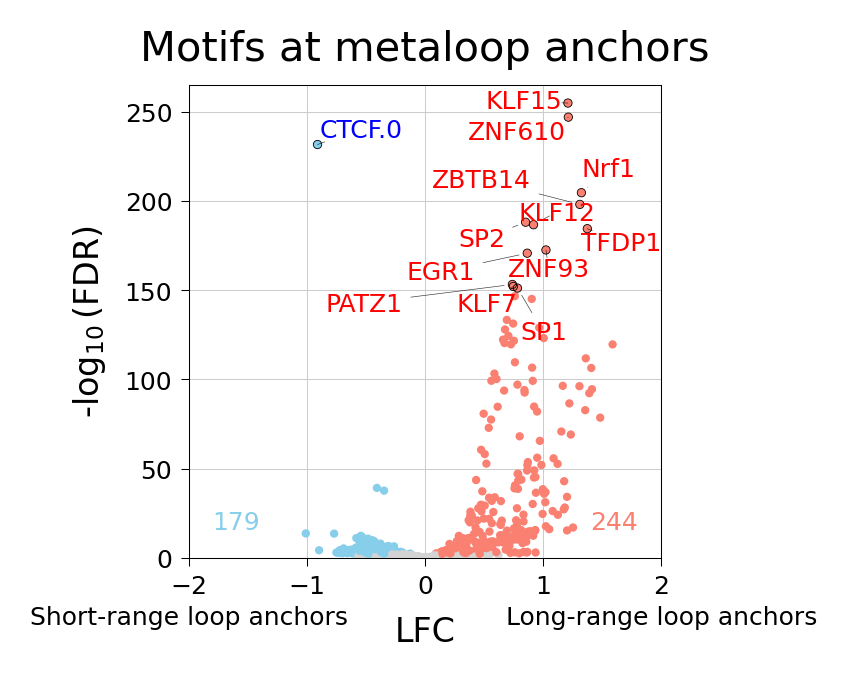

In [473]:
from supp_figures_plotting_functions import metaloop_vs_shortrange_loop_motif_enrichment

metaloop_vs_shortrange_loop_motif_enrichment(meme_motif_df, anchordict, metaloop_anchors)

C. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


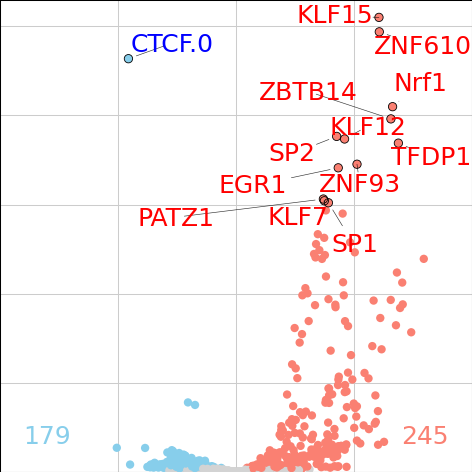

In [677]:
df = metaloop_vs_shortrange_loop_motif_enrichment(meme_motif_df)

C.

In [538]:
def treg_vs_tcon_loop_motif_enrichment(meme_motif_df, anchordict):
    def get_enrichment(meme_motif_df, anchors_treg, anchors_tcon):
        rows = []
    
        atac_has_treg_anchor = get_col(index_to_bedtool(meme_motif_df.index).intersect(anchors_treg, c=True), -1).astype(int)
        atac_has_tcon_anchor = get_col(index_to_bedtool(meme_motif_df.index).intersect(anchors_tcon, c=True), -1).astype(int)
    
        idx_treg_anchor = atac_has_treg_anchor > 0
        idx_tcon_anchor = atac_has_tcon_anchor > 0
        shared = idx_treg_anchor & idx_tcon_anchor
        idx_treg_anchor[shared] = 0
        idx_tcon_anchor[shared] = 0
        for col in meme_motif_df:
            x = meme_motif_df.loc[idx_treg_anchor, col] > 0
            y = meme_motif_df.loc[idx_tcon_anchor, col] > 0
            delta = np.log2(x.mean() / y.mean())
            
            nup = x.sum()
            ndown = y.sum()
            stat, pval = scipy.stats.fisher_exact([[nup, len(x)-nup],
                                                   [ndown, len(y)-ndown]
                                                  ]
                                               )
            rows.append([col, delta, pval])
        df = pd.DataFrame(rows, columns = ['factor', 'delta', 'pval'])
        df.loc[df['pval'] == 0, 'pval'] = 1e-305
        return df

    results_treg_ns = get_enrichment(meme_motif_df, add_chr_to_bedtool(anchordict['Treg'].subtract(anchordict['NS'], A=True)), 
                                                 add_chr_to_bedtool(anchordict['NS']),
                                                )
    
    results_tcon_ns = get_enrichment(meme_motif_df, add_chr_to_bedtool(anchordict['NS']),
                                                 add_chr_to_bedtool(anchordict['Tcon'].subtract(anchordict['NS'], A=True)), 
                                                )
    
    results_treg_tcon = get_enrichment(meme_motif_df, add_chr_to_bedtool(anchordict['Treg'].subtract(anchordict['NS'], A=True)), 
                                                 add_chr_to_bedtool(anchordict['Tcon'].subtract(anchordict['NS'], A=True)),
                                                )

    print(results_treg_ns[results_treg_ns['factor'] == 'Stat6'])
    print(results_treg_tcon[results_treg_tcon['factor'] == 'Stat6'])
    
    idx1 = results_treg_ns[(results_treg_ns['delta'] > 0) & (results_treg_ns['pval'] < 0.005)]['factor']
    idx2 = results_tcon_ns[(results_tcon_ns['delta'] < 0) & (results_tcon_ns['pval'] < 0.005)]['factor']
    idx3 = results_treg_tcon[(results_treg_tcon['pval'] < 0.05)]['factor']
    
    idx = list(set(list(idx1) + list(idx2) + list(idx3)))

    atac_has_treg_anchor = get_col(index_to_bedtool(meme_motif_df.index).intersect(add_chr_to_bedtool(anchordict['Treg']), c=True), -1).astype(int)
    atac_has_tcon_anchor = get_col(index_to_bedtool(meme_motif_df.index).intersect(add_chr_to_bedtool(anchordict['Tcon']), c=True), -1).astype(int)
    atac_has_ns_anchor   = get_col(index_to_bedtool(meme_motif_df.index).intersect(add_chr_to_bedtool(anchordict['NS']), c=True), -1).astype(int)

    data = pd.concat([meme_motif_df.loc[atac_has_treg_anchor>0].mean(axis=0),
               meme_motif_df.loc[atac_has_tcon_anchor>0].mean(axis=0),
               meme_motif_df.loc[atac_has_ns_anchor>0].mean(axis=0),],
             axis=1)
    
    data.columns = ['Treg', 'Tcon', 'NS']    
    
    g = sns.clustermap(data.loc[idx], z_score = 0, cmap='coolwarm', figsize=(4, 4))
    g.fig.savefig('./plots/paper/s31/atac_in_treg_anc_vs_tcon_anc.svg', bbox_inches='tight', dpi = 3000)
    return data.loc[idx]

    factor     delta      pval
657  Stat6  0.401736  0.003554
    factor     delta      pval
657  Stat6  0.296958  0.088083


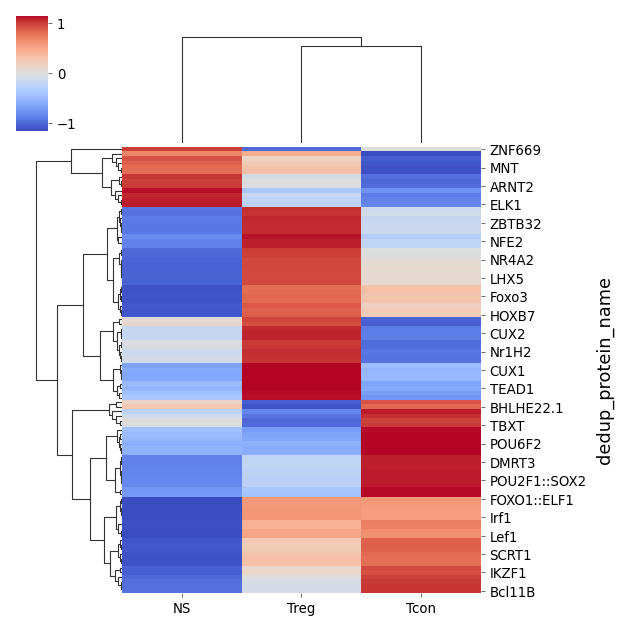

In [535]:
data = treg_vs_tcon_loop_motif_enrichment(meme_motif_df, anchordict)
g = sns.clustermap(data, z_score = 0, cmap='coolwarm', figsize=(4, 8), yticklabels=True)
g.fig.savefig('./plots/paper/s31/atac_in_treg_anc_vs_tcon_anc.svg', bbox_inches='tight', dpi = 3000,
             )

D. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


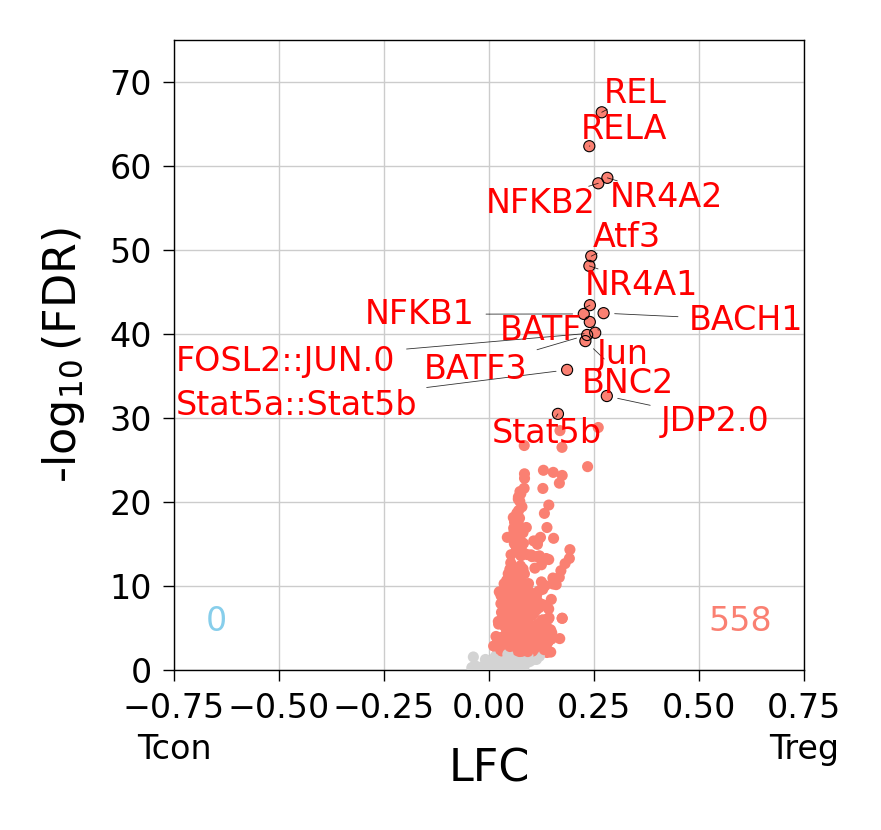

In [541]:
from supp_figures_plotting_functions import make_h3k27ac_motif_enrichment_plot
motif_data = make_h3k27ac_motif_enrichment_plot(h3k27ac_motif_df)

E. Looping ChIP enrichment

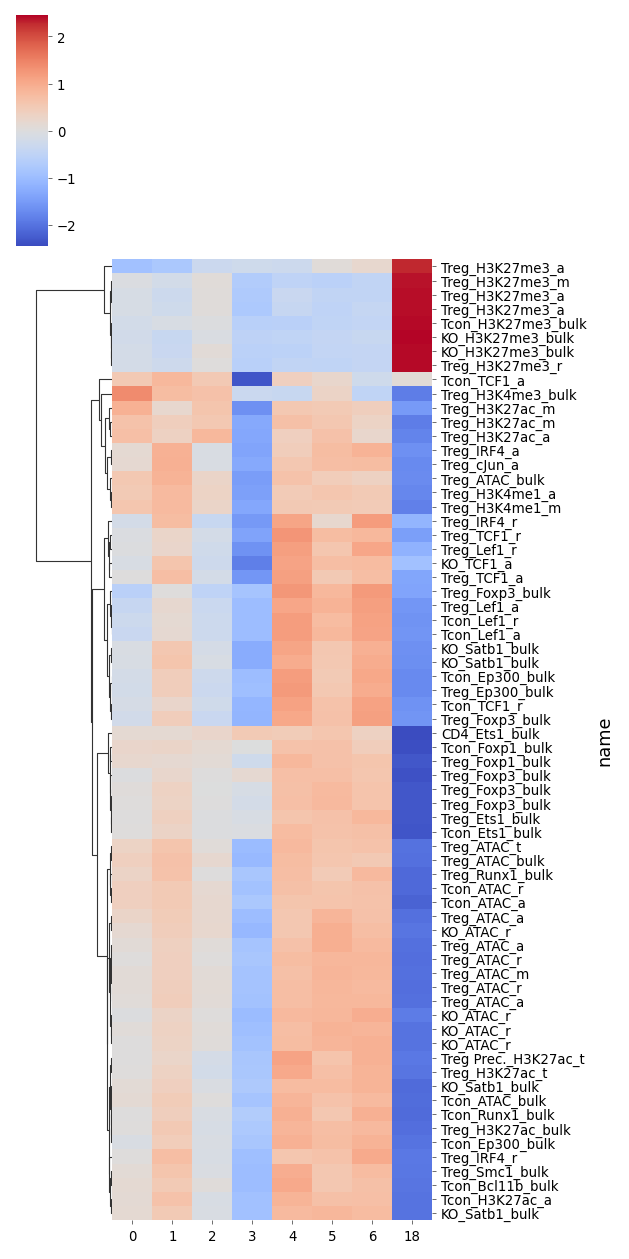

In [571]:
val_df = pd.DataFrame()
cldict = {}
for i in self.cluster_to_subset_for_further_clustering:
    cl0 = pd.Series(list(bedtool_to_grange_set(metaloop_anchors.intersect(add_chr_to_bedtool([all_ind_to_region[x] 
                                                                                              for x in self.goodinds[self.clustdict['all']==i]]),
                          u=True))))
    cl0 = cl0[cl0.isin(adata.obs.index)]
    cldict[i] = cl0
    val_df[i] = adata[cl0].X.mean(axis=0)
val_df.index = adata.var['name']

g = sns.clustermap(val_df.iloc[::3], cmap='coolwarm', z_score=0,  col_cluster=False,  yticklabels=True,  figsize=(4, 8), method='ward')
g.fig.savefig('./plots/paper/s31/chip_at_metaloop_anchors.pdf', bbox_inches='tight')

F. Found in  Final_ChIP_Compendium_Analysis

G. 

In [573]:
loop_adata = sc.read_h5ad('./final_chipseq_adata/FINAL_loop_adata')

oe_df = pd.read_csv('./data_for_enhancer_umap/oe_df.csv', sep='\t', index_col=0)
with open('./full_pileup_dict', 'rb') as f:
    full_pileup_dict = pickle.load(f)

Imported plotting functions


/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:2942: UserWarning: The figure layout has changed to tight
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:2928: RuntimeWarning: Mean of empty slice


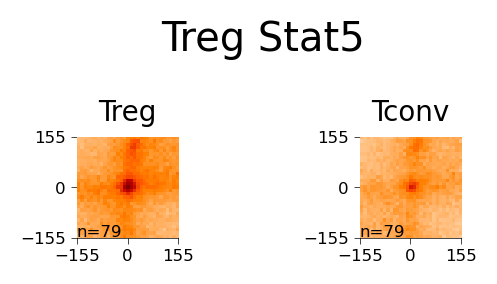

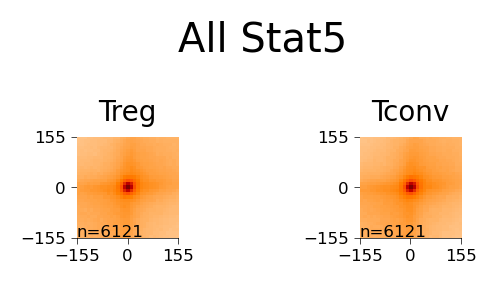

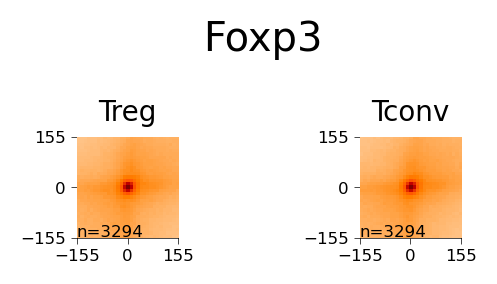

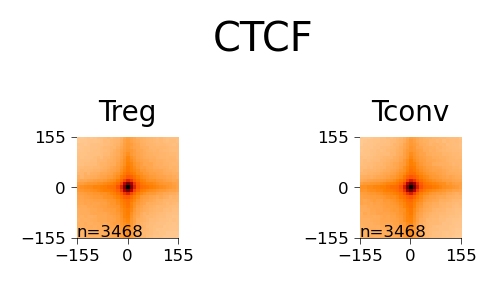

In [574]:
import math
from supp_figures_plotting_functions import loop_apa_pileup

plt.rcParams['pdf.fonttype'] = 42

loop_apa_pileup(loop_adata, full_pileup_dict, oe_df)

H. Found in Final_ChIP_Compendium_Analysis notebook

I. 

/tmp/ipykernel_3274312/3221240399.py:27: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(pileup_1[:, n-d:n+d+1, n-d:n+d+1], axis=(1, 2))


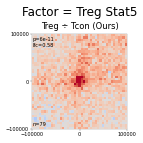

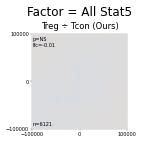

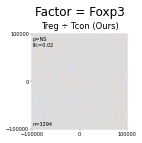

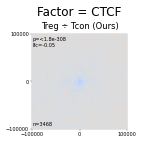

In [576]:
import math
from plotting_functions import *

indsoi_dict = {
    'Treg Stat5' : (loop_adata.obs['new_treg_stat'] > 0), 
    'All Stat5' : (loop_adata.obs['new_ns_stat'] > 0), 
    'Foxp3' : (loop_adata.obs['foxp3_peaks_yuri'] > 0), 
    'CTCF' : (loop_adata.obs['ctcf_p=1e-05'] > 1), 
}

for key, indsoi in indsoi_dict.items():
    comparisons = {
        'Treg ÷ Tcon (Ours)' : ['Rename_Treg_all_no_chrM', 'Rename_Tconv_all_no_chrM'],
    }
    rows = 1
    cols = math.ceil(len(comparisons)/rows)
    fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 40*mm), as_list=True)
    for c, (label, (comp1, comp2)) in enumerate(comparisons.items()):
        ax = axs[c]
        pileup_1 = full_pileup_dict[comp1][oe_df.index.isin(loop_adata.obs.index)][indsoi].copy()
        pileup_2 = full_pileup_dict[comp2][oe_df.index.isin(loop_adata.obs.index)][indsoi].copy()
        m1 = np.nanmean(pileup_1, axis=0)
        m2 = np.nanmean(pileup_2, axis=0)

        n = len(m1)//2
        d = 2
        v1 = np.nanmean(pileup_1[:, n-d:n+d+1, n-d:n+d+1], axis=(1, 2))
        v2 = np.nanmean(pileup_2[:, n-d:n+d+1, n-d:n+d+1], axis=(1, 2))
        pval = samesize_nonan_test(v1, v2)[1]
        lfc = np.log2(np.nanmean(v1)/np.nanmean(v2))
        delta_mat = m1-m2
        ax.matshow(delta_mat, vmin=-2, vmax=2, cmap='coolwarm',
                   extent = [-res*n, res*n, -res*n, res*n], zorder=3
                  )
        ax.set_xticks([-res*n, 0, res*n])
        ax.set_yticks([-res*n, 0, res*n])
        ax.tick_params(bottom=True, labelbottom=True, top=False, labeltop=False, left=True, labelleft=True)

        p = format_pvalue(pval)
        plt.title(label)
        if np.abs(lfc) < .02:
            p = 'NS'
        ax.text(-res*n, res*(n-1), f'p={p}\nlfc={lfc.round(2)}', fontsize=6,
               va='top')
        
        ax.text(-res*n, -res*(n-1), f'n={len(v1)}', fontsize=6)
        fig.suptitle(f'Factor = {key}', y=1.3)
    fig.savefig(f'./plots/paper/s31/differential_apa_{key}.pdf', bbox_inches = 'tight')